In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
# Import manipulating files libraries
import os, glob
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   #if like me you do not have a lot of memory in your GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "" #then these two lines force keras to use your CPU

# Import graph/image plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Import loading and manipulating neuroimaging data library
import nibabel as nib

# Import array manipulating libraries
import numpy as np
import pandas as pd

# Import deep learning model libraries
import tensorflow as tf
import keras
from keras.callbacks import TensorBoard
from keras.models import Model, Sequential

from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization

from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Import date/time library to save models with date/time
from datetime import datetime
from tensorflow.keras.regularizers import l2
###################################
plt.rcParams['figure.dpi'] = 600 #TO SET THE DPI TO 600
plt.rcParams['savefig.dpi'] = 600 #TO SET THE DPI T0 600

In [3]:
# Load the data from the .npy file
data_con = np.load('/content/drive/MyDrive/Vit_GradCam/non_dyslexic_data.npy')

# Print the loaded data
print(data_con.shape)

(5310, 64, 64)


(64, 64)


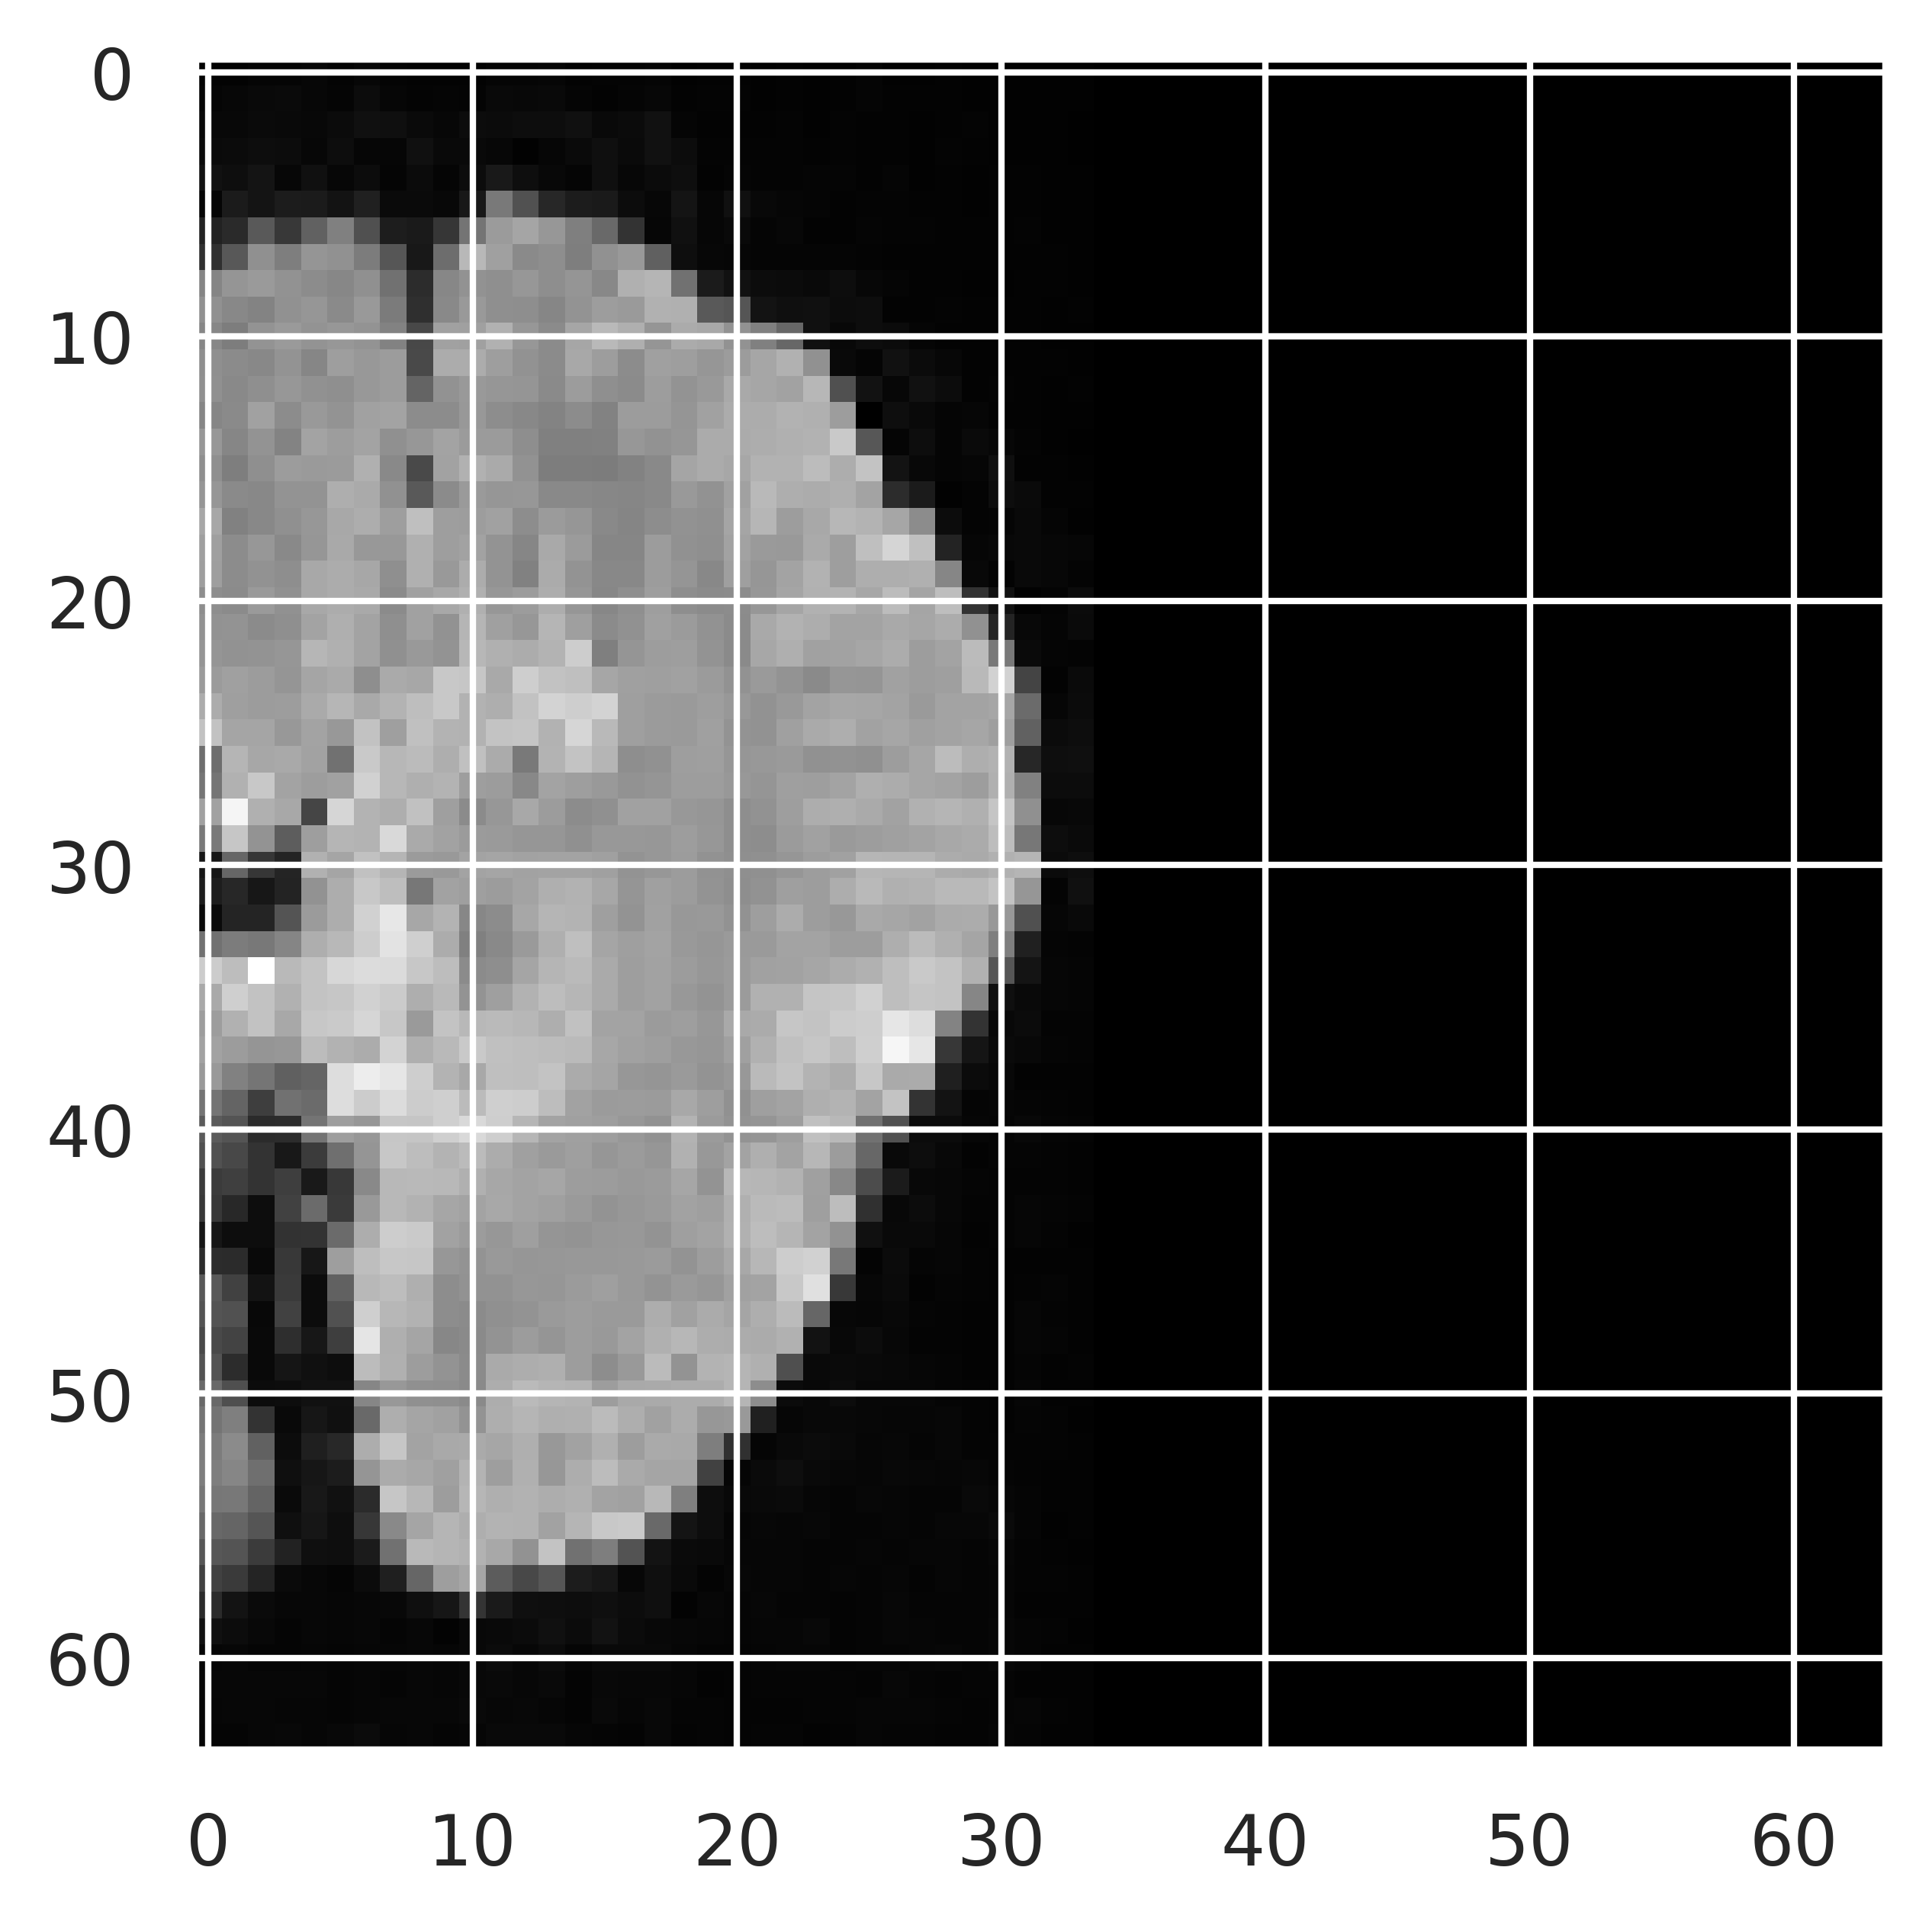

In [30]:
# Generate a random 2D numpy array
img = data_con[5200]
print(img.shape)

# Plot the image using matplotlib
plt.imshow(img, cmap='gray')

# Show the plot
plt.show()

In [5]:
# Load the data from the .npy file
data_dys = np.load('/content/drive/MyDrive/Vit_GradCam/dyslexic_data.npy')

# Print the loaded data
print(data_dys.shape)

(5310, 64, 64)


(64, 64)


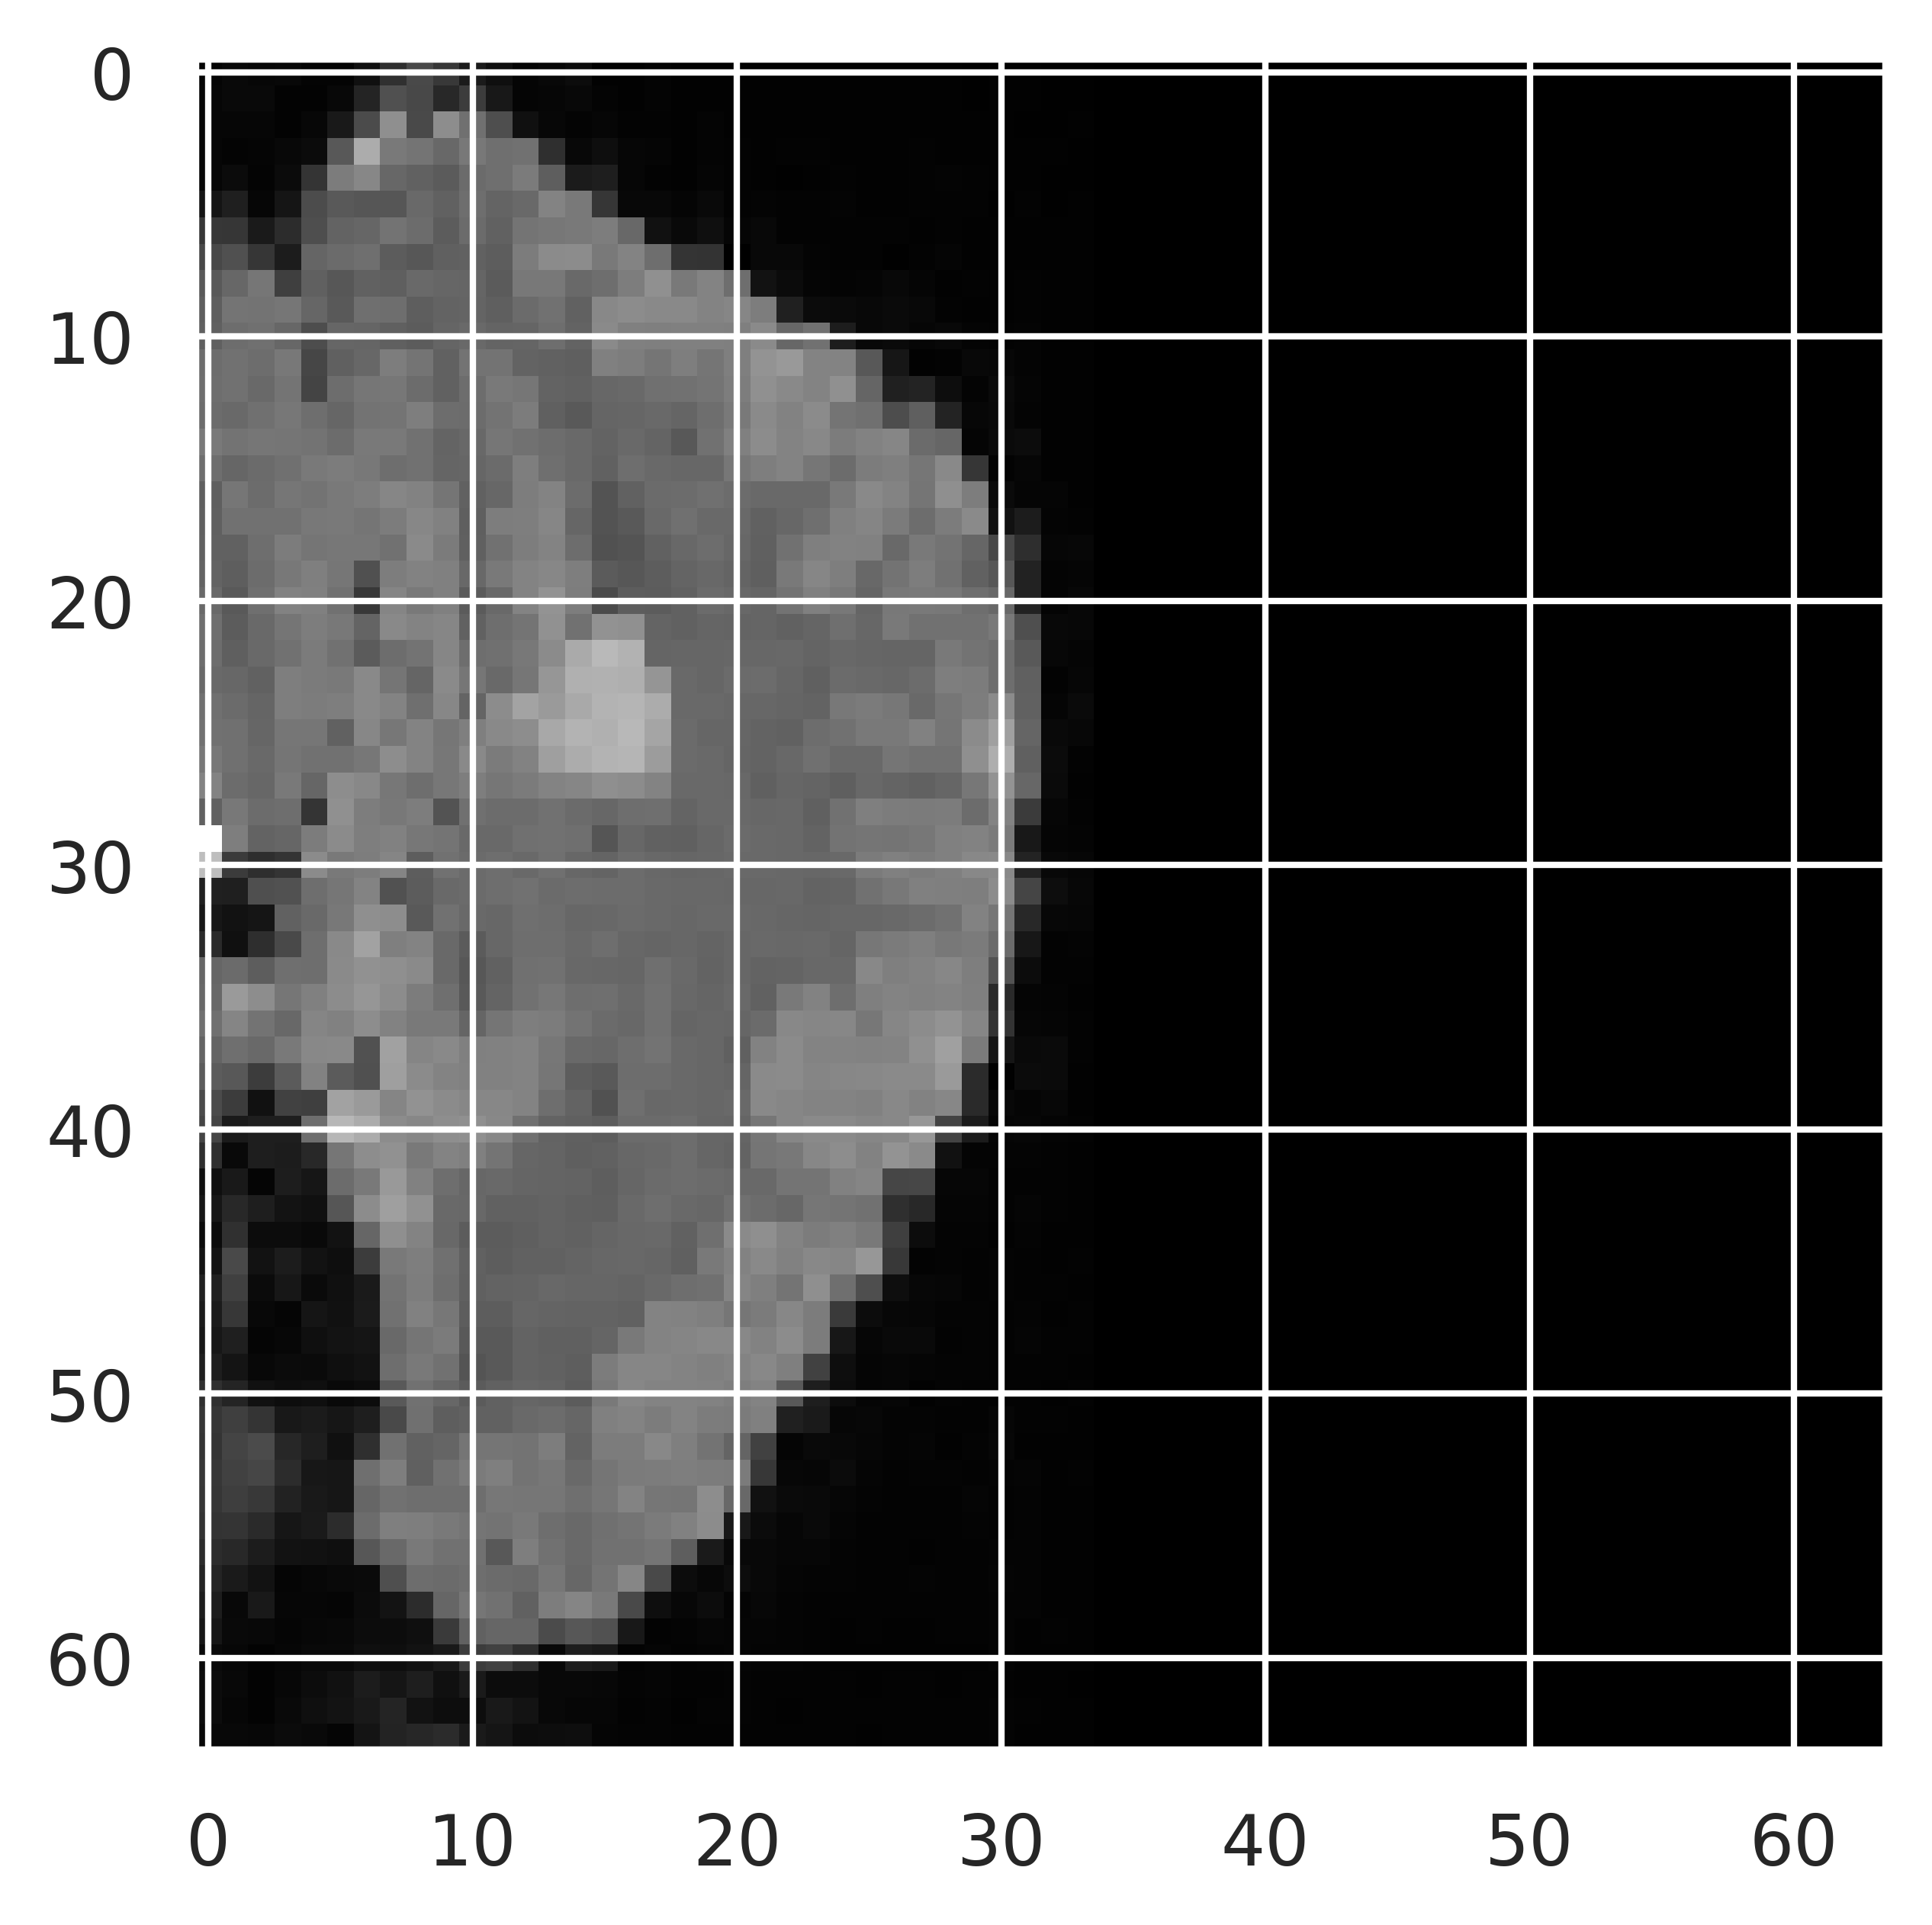

In [31]:
# Generate a random 2D numpy array
img1 = data_dys[5200]
print(img1.shape)

# Plot the image using matplotlib
plt.imshow(img1, cmap='gray')

# Show the plot
plt.show()

In [7]:
concatenated_array = np.concatenate((data_dys, data_con))

# print the concatenated array
print(concatenated_array.shape)

(10620, 64, 64)


(64, 64, 1)


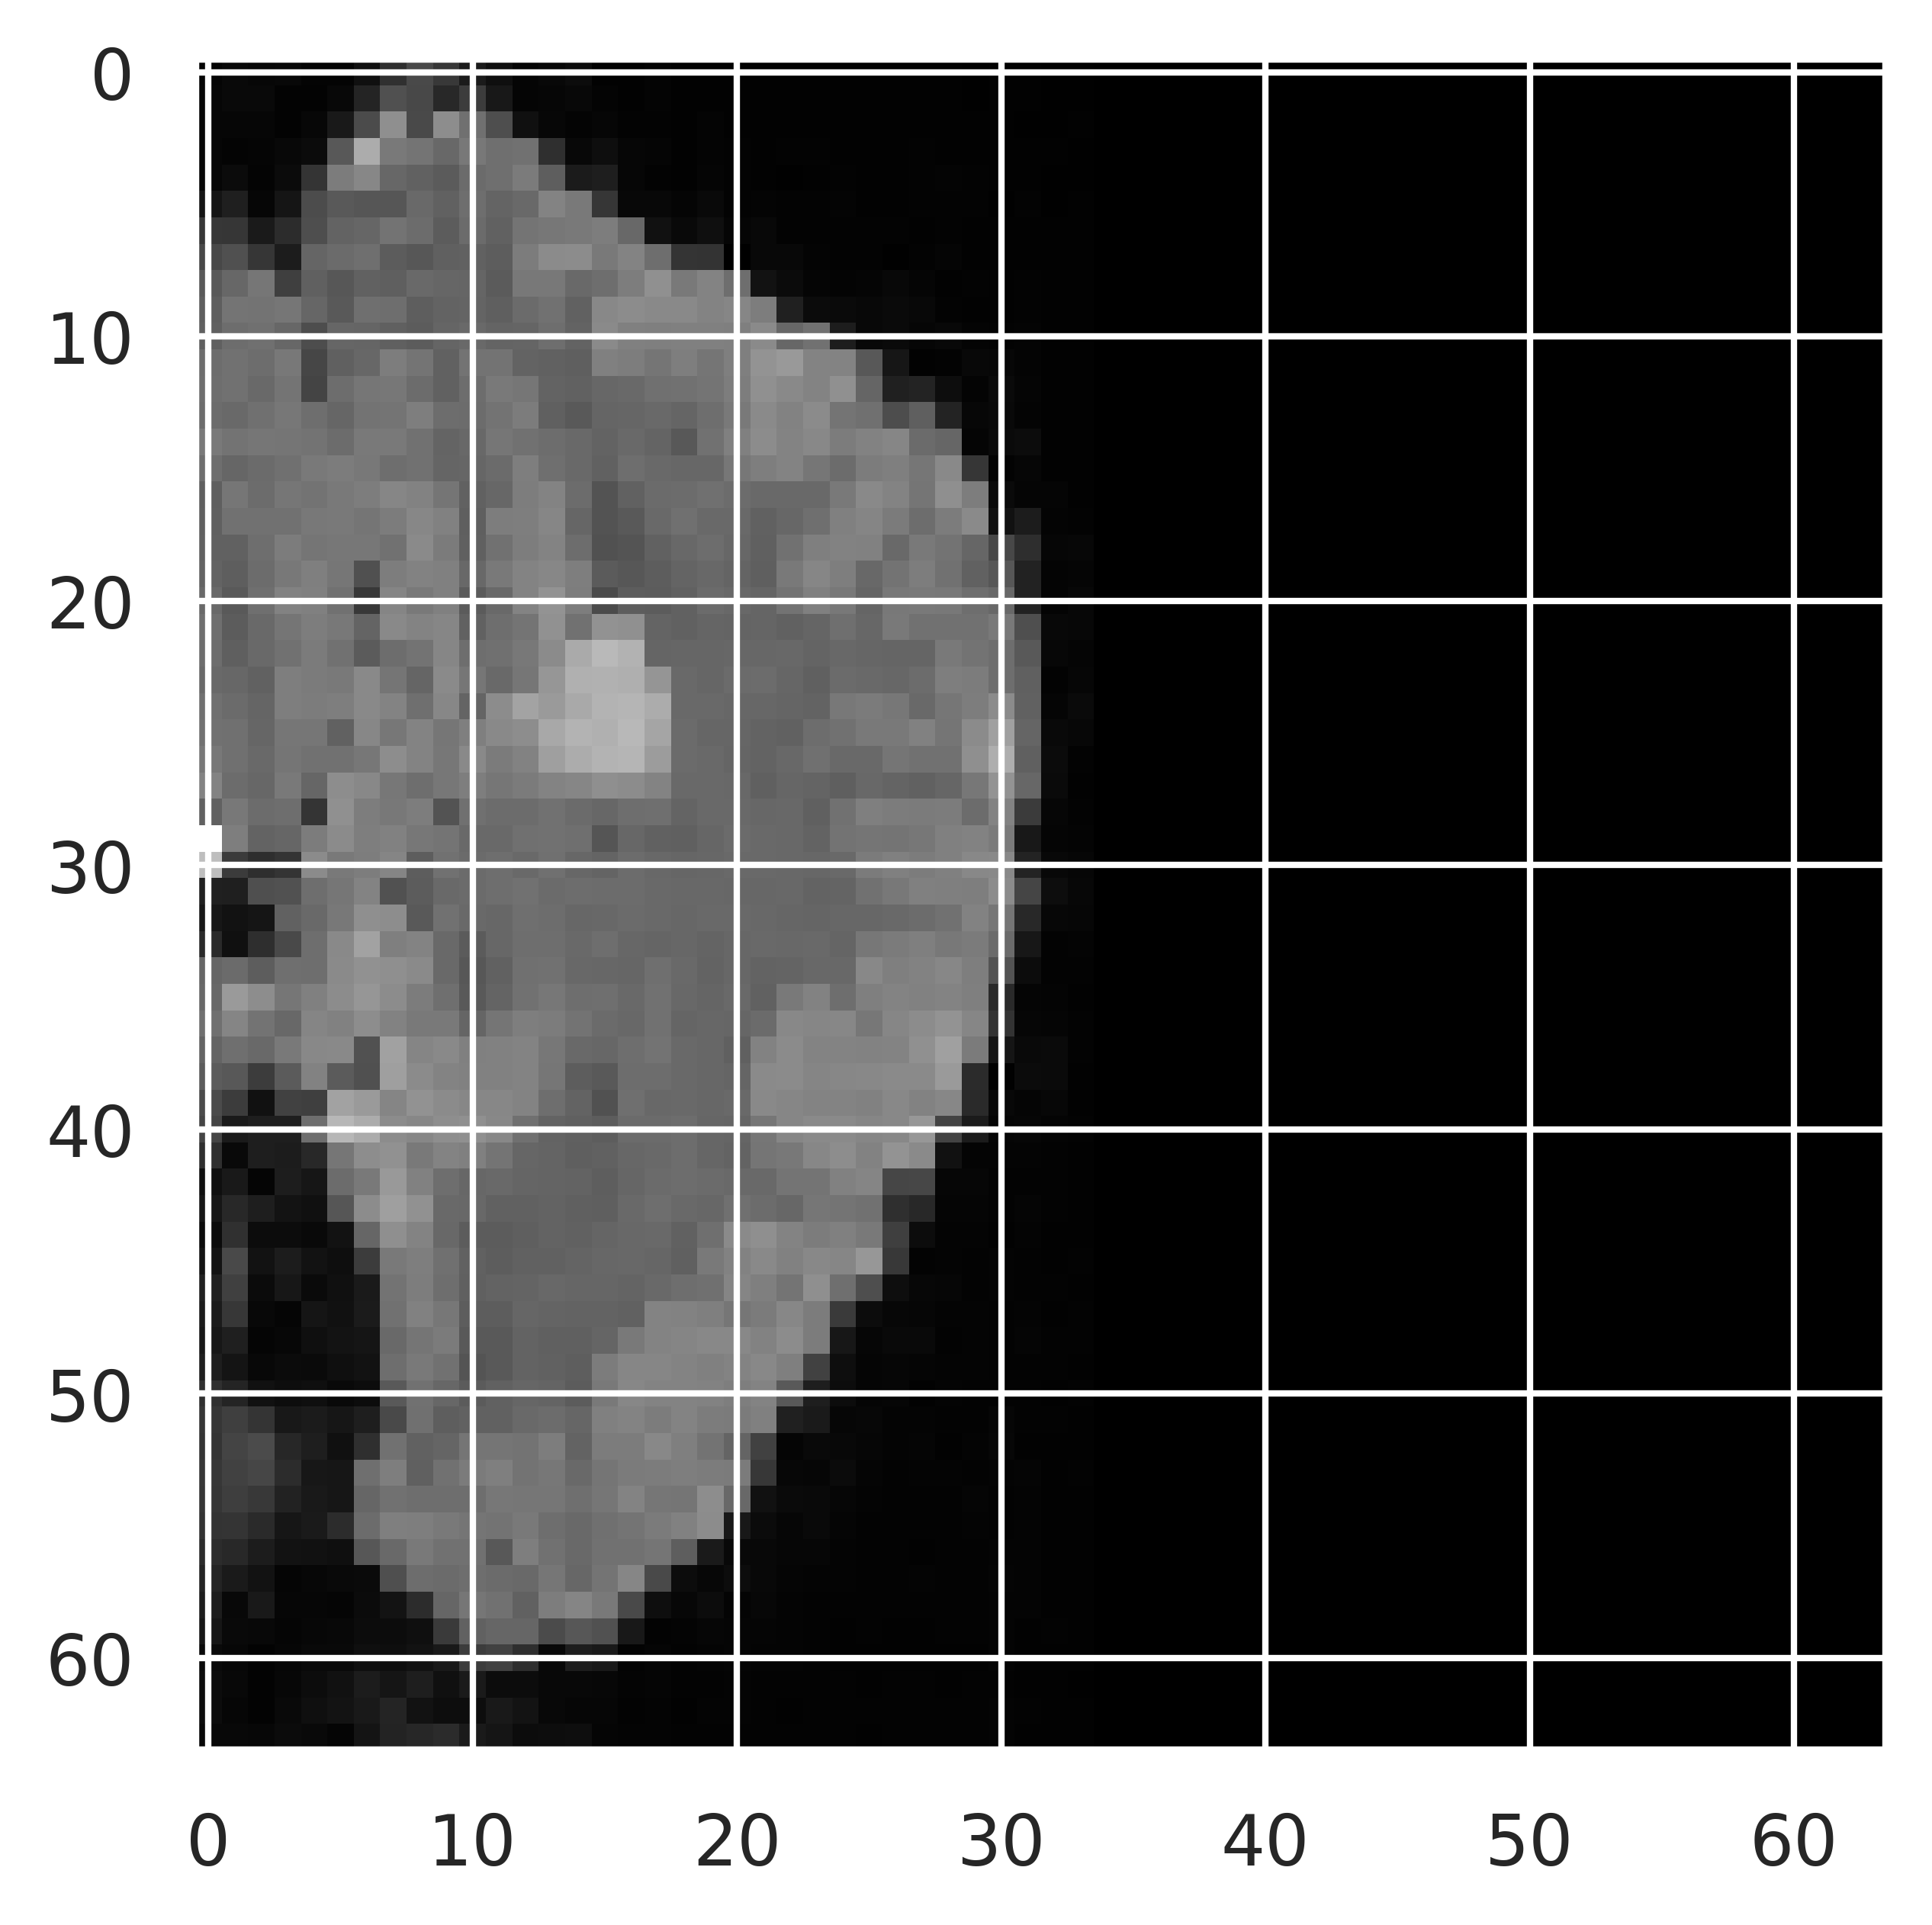

In [32]:
# Generate a random 2D numpy array
img2 = concatenated_array[5200]
print(img2.shape)

# Plot the image using matplotlib
plt.imshow(img2, cmap='gray')

# Show the plot
plt.show()

In [9]:
print(img1 == img2)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [10]:
# Get the labels for our data from our csv file
Labels = pd.read_csv('/content/drive/MyDrive/Vit_GradCam/labeled_data.csv')
# Define our target from the column "Labels" as our y in our model
target = Labels['Label']

In [11]:
# Add a fourth dimension with a value of 3
concatenated_array = np.expand_dims(concatenated_array, axis=-1)
full_data = np.repeat(concatenated_array, 3, axis=-1)

# The resulting shape of arr will be (120, 4096, 4096, 3)
print(full_data.shape)

(10620, 64, 64, 3)


In [12]:
target.head

<bound method NDFrame.head of 0        0
1        0
2        0
3        0
4        0
        ..
10615    1
10616    1
10617    1
10618    1
10619    1
Name: Label, Length: 10620, dtype: int64>

In [13]:
# Create list of indices
N = full_data.shape[0]
indexes = np.arange(N)

# Divide our dataset into dyslexics and controls to have a balanced train, validation and test sets
dis = indexes[:5310]
con = indexes[5310:]

#  Cut the dataset at 80% to create the training, 10% validation and 10% test set
size = dis.shape[0]
split_1 = int(0.7 * size)
split_2 = int(0.85 * size)

# Shuffle our dyslexics and controls arrays to create random indexes
np.random.shuffle(np.asarray(dis))
np.random.shuffle(np.asarray(con))

# Create our indexes for our train, validation and test sets according to our previous division (80%, 10%, 10%)
indexes_train_dis, indexes_train_con = dis[:split_1], con[:split_1]
indexes_val_dis, indexes_val_con   = dis[split_1:split_2], con[split_1:split_2]
indexes_test_dis, indexes_test_con = dis[split_2:], con[split_2:]

# We concatenate our training, validation and test indexes for dyslexics and controls
# By doing that we ensure that each set is balanced with the same number of dyslexics and controls
indexes_train = np.concatenate((indexes_train_dis, indexes_train_con), axis=None)
indexes_val = np.concatenate((indexes_val_dis, indexes_val_con), axis=None)
indexes_test = np.concatenate((indexes_test_dis, indexes_test_con), axis=None)


# Split the data into training, validation and test sets according to the indexes created previously
X_train = full_data[indexes_train, ...]
X_val = full_data[indexes_val, ...]
X_test = full_data[indexes_test, ...]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(7432, 64, 64, 3)
(1594, 64, 64, 3)
(1594, 64, 64, 3)


In [14]:
print(X_train[0].shape)

(64, 64, 3)


In [15]:
# Create outcome variable for each set (training, validation and test)
y_train = target[indexes_train] 
y_val   = target[indexes_val]
y_test  = target[indexes_test]
print(y_train)

250     0
4110    0
1798    0
3342    0
3230    0
       ..
6481    1
5415    1
9161    1
8104    1
8278    1
Name: Label, Length: 7432, dtype: int64


In [16]:
# Our vectorized labels
y_train = np.asarray(y_train).astype('int32')
y_test = np.asarray(y_test).astype('int32')
y_val = np.asarray(y_val).astype('int32')

In [17]:
y_train = tf.one_hot(y_train, 2)
y_test = tf.one_hot(y_test, 2)
y_val = tf.one_hot(y_val, 2)
print(y_val) 

tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]], shape=(1594, 2), dtype=float32)


In [18]:
%pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.7 MB/s eta 0:00:00


In [19]:
from tensorflow.keras import layers
from keras_tuner.tuners import BayesianOptimization
import keras_tuner
from keras_tuner import HyperModel

In [ ]:
#%pip install bayesian-optimization==1.4.1

In [20]:
# Define the LeNet-5 architecture
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(hp.Int('conv1_filters', min_value=16, max_value=128, step=16),
                            kernel_size=3,
                            activation='relu',
                            input_shape=X_train[0].shape))
    model.add(layers.MaxPooling2D(pool_size=2))
    
    model.add(layers.Conv2D(hp.Int('conv2_filters', min_value=32, max_value=256, step=32),
                            kernel_size=3,
                            activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    
    model.add(layers.Conv2D(hp.Int('conv3_filters', min_value=64, max_value=512, step=64),
                            kernel_size=3,
                            activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense_units', min_value=32, max_value=512, step=32),
                           activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))  # Add dropout layer
    
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [33]:
from sklearn.model_selection import KFold

# Define the number of folds for cross-validation
num_folds = 5

# Create a KFold instance
kf = KFold(n_splits=num_folds, shuffle=True)

# Lists to store evaluation results for each fold
fold_accuracies = []
##??
fold_index = 1
##??
X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))
for i, (train_index, val_index) in enumerate(kf.split(X)):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
# # Perform K-fold cross-validation
    #fold_index = 1
# for train_index, val_index in kf.split(X_train):
#     print(f"Fold: {fold_index}")
    
#     # Split the data into train and validation sets for the current fold
#     fold_X_train, fold_X_val = X_train[train_index], X_train[val_index]
#     fold_y_train, fold_y_val = y_train[train_index], y_train[val_index]

    # Instantiate the tuner
    tuner = BayesianOptimization(build_model,
                                 objective='val_accuracy',
                                 max_trials=10,
                                 executions_per_trial=2,
                                 directory='path_to_directory',  # Specify a directory to save the tuning results
                                 project_name=f'my_tuning_project_fold_{fold_index}')

    # Perform hyperparameter search on the current fold
    tuner.search(X_train, y_train,
                 epochs=20,
                 validation_data=(X_val, y_val))

    # Retrieve the best model for the current fold
    best_model = tuner.get_best_models(num_models=1)[0]
    fold_evaluation = best_model.evaluate(X_test, y_test)
    
    # Store the accuracy of the best model for the current fold
    fold_accuracies.append(fold_evaluation[1])
    
    fold_index += 1

# Calculate and print the average accuracy across all folds
average_accuracy = sum(fold_accuracies) / num_folds
print(f"Average test accuracy across {num_folds} folds: {average_accuracy}")


50/50 [==============================] - 1s 7ms/step - loss: 0.1781 - accuracy: 0.9504


50/50 [==============================] - 0s 5ms/step - loss: 0.1895 - accuracy: 0.9241


50/50 [==============================] - 1s 6ms/step - loss: 0.1921 - accuracy: 0.9322


50/50 [==============================] - 0s 5ms/step - loss: 0.1725 - accuracy: 0.9460


50/50 [==============================] - 0s 5ms/step - loss: 0.2026 - accuracy: 0.9297
Average test accuracy across 5 folds: 0.9365119099617004


In [ ]:
# from sklearn.model_selection import KFold

# eval_metrics = []

# # Split data into training and validation sets
# kf = KFold(n_splits=5, shuffle=True)
# X = np.concatenate((X_train, X_val))
# y = np.concatenate((y_train, y_val))
# for i, (train_index, val_index) in enumerate(kf.split(X)):
#     X_train, X_val = X[train_index], X[val_index]
#     y_train, y_val = y[train_index], y[val_index]
    
#     # Clone the best model to ensure a fresh copy for each fold
#     model = tf.keras.models.clone_model(best_model)
#     model.set_weights(best_model.get_weights())
    
#     # Train the model
#     eval_result = best_model.fit(X_train, y_train, epochs=5, batch_size=45, validation_data=(X_val, y_val))
    
#     # Evaluate the model
#     eval_scores = model.evaluate(X_test, y_test)
#     print("Accuracy test :" + eval_scores)
    
#     # Store the evaluation metrics for the current fold
#     eval_metrics.append(eval_scores)
    

In [ ]:
evaluation = best_model.evaluate(X_test, y_test)
print(f"Test accuracy: {evaluation[1]}")

In [ ]:
#best_model.save("/content/drive/MyDrive/Vit_GradCam/bayesian_new_model.h5")

In [23]:
best_model.save("/content/drive/MyDrive/Vit_GradCam/bayesian_new_model")

In [ ]:
import matplotlib.pyplot as plt

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=10)[0]

# Access the hyperparameter values
conv1_filters = best_hyperparameters.get('conv1_filters')
conv2_filters = best_hyperparameters.get('conv2_filters')
conv3_filters = best_hyperparameters.get('conv3_filters')
dense_units = best_hyperparameters.get('dense_units')

# Create a bar chart to visualize the hyperparameters
hyperparameters = ['conv1_filters', 'conv2_filters','conv3_filters', 'dense_units']
values = [conv1_filters, conv2_filters, conv3_filters, dense_units]

plt.bar(hyperparameters, values)
plt.xlabel('Hyperparameter')
plt.ylabel('Value')
plt.title('Hyperparameters Explored in Bayesian Optimization')
plt.show()


In [38]:
# import matplotlib.pyplot as plt

# # Train the model and store the history
# history = best_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
# # history = tuner.results_summary()

# # Plot the accuracy and loss curves
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()

In [39]:
predicted = best_model.predict(X_test)
predicted[:, :]

50/50 [==============================] - 0s 4ms/step


array([[9.9999940e-01, 5.3841620e-07],
       [1.0000000e+00, 1.6999079e-09],
       [9.9996412e-01, 3.5927093e-05],
       ...,
       [2.2707365e-05, 9.9997735e-01],
       [5.8670939e-05, 9.9994135e-01],
       [2.6880483e-07, 9.9999976e-01]], dtype=float32)

In [40]:
# Import confusion matrix and classification report from scikit-learn
from sklearn.metrics import confusion_matrix, classification_report
Y_prediction = best_model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(predicted,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(target[indexes_test], Y_pred_classes) 
print(classification_report(target[indexes_test], Y_pred_classes))

50/50 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       797
           1       0.98      0.97      0.98       797

    accuracy                           0.98      1594
   macro avg       0.98      0.98      0.98      1594
weighted avg       0.98      0.98      0.98      1594



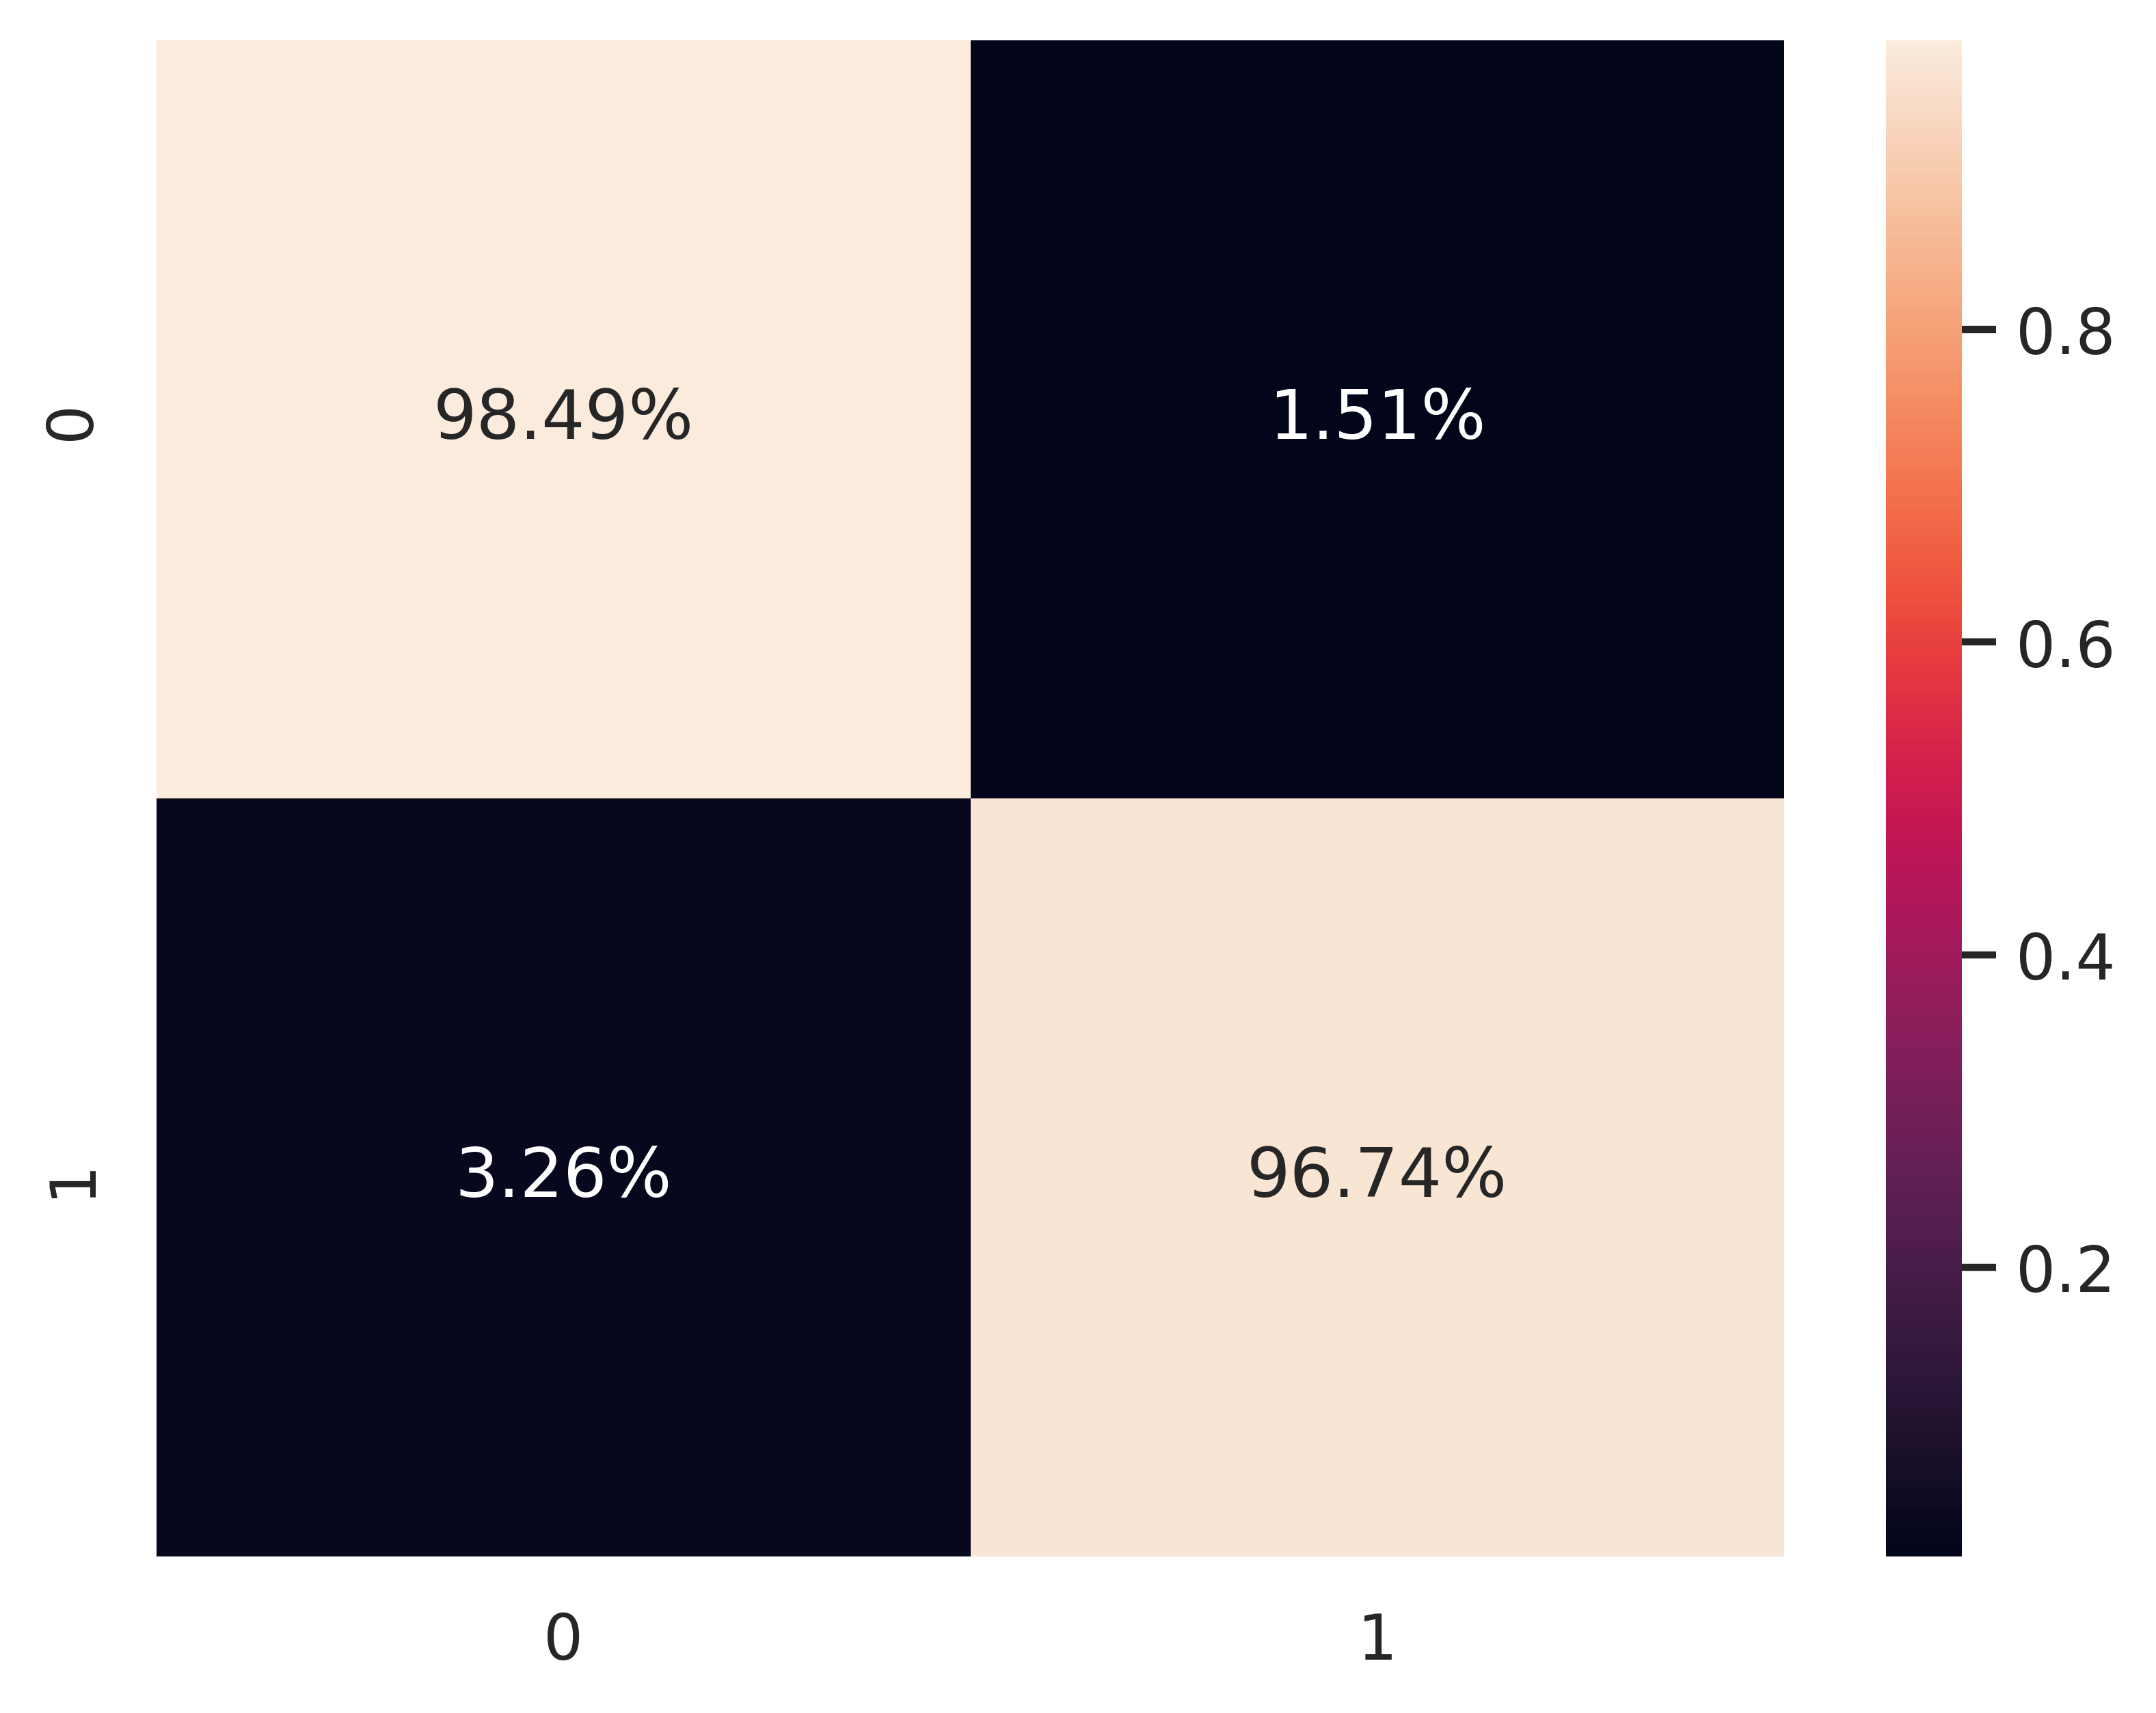

In [41]:
sns.heatmap(confusion_mtx/797, annot=True, fmt='.2%');

In [42]:
# Assume y_true and y_pred are the true and predicted labels for the test data, respectively
tn, fp, fn, tp = confusion_matrix(target[indexes_test], Y_pred_classes).ravel()

print(tn, fp, fn, tp)
specificity = tn / (tn + fp)
print(specificity)

785 12 26 771
0.9849435382685069


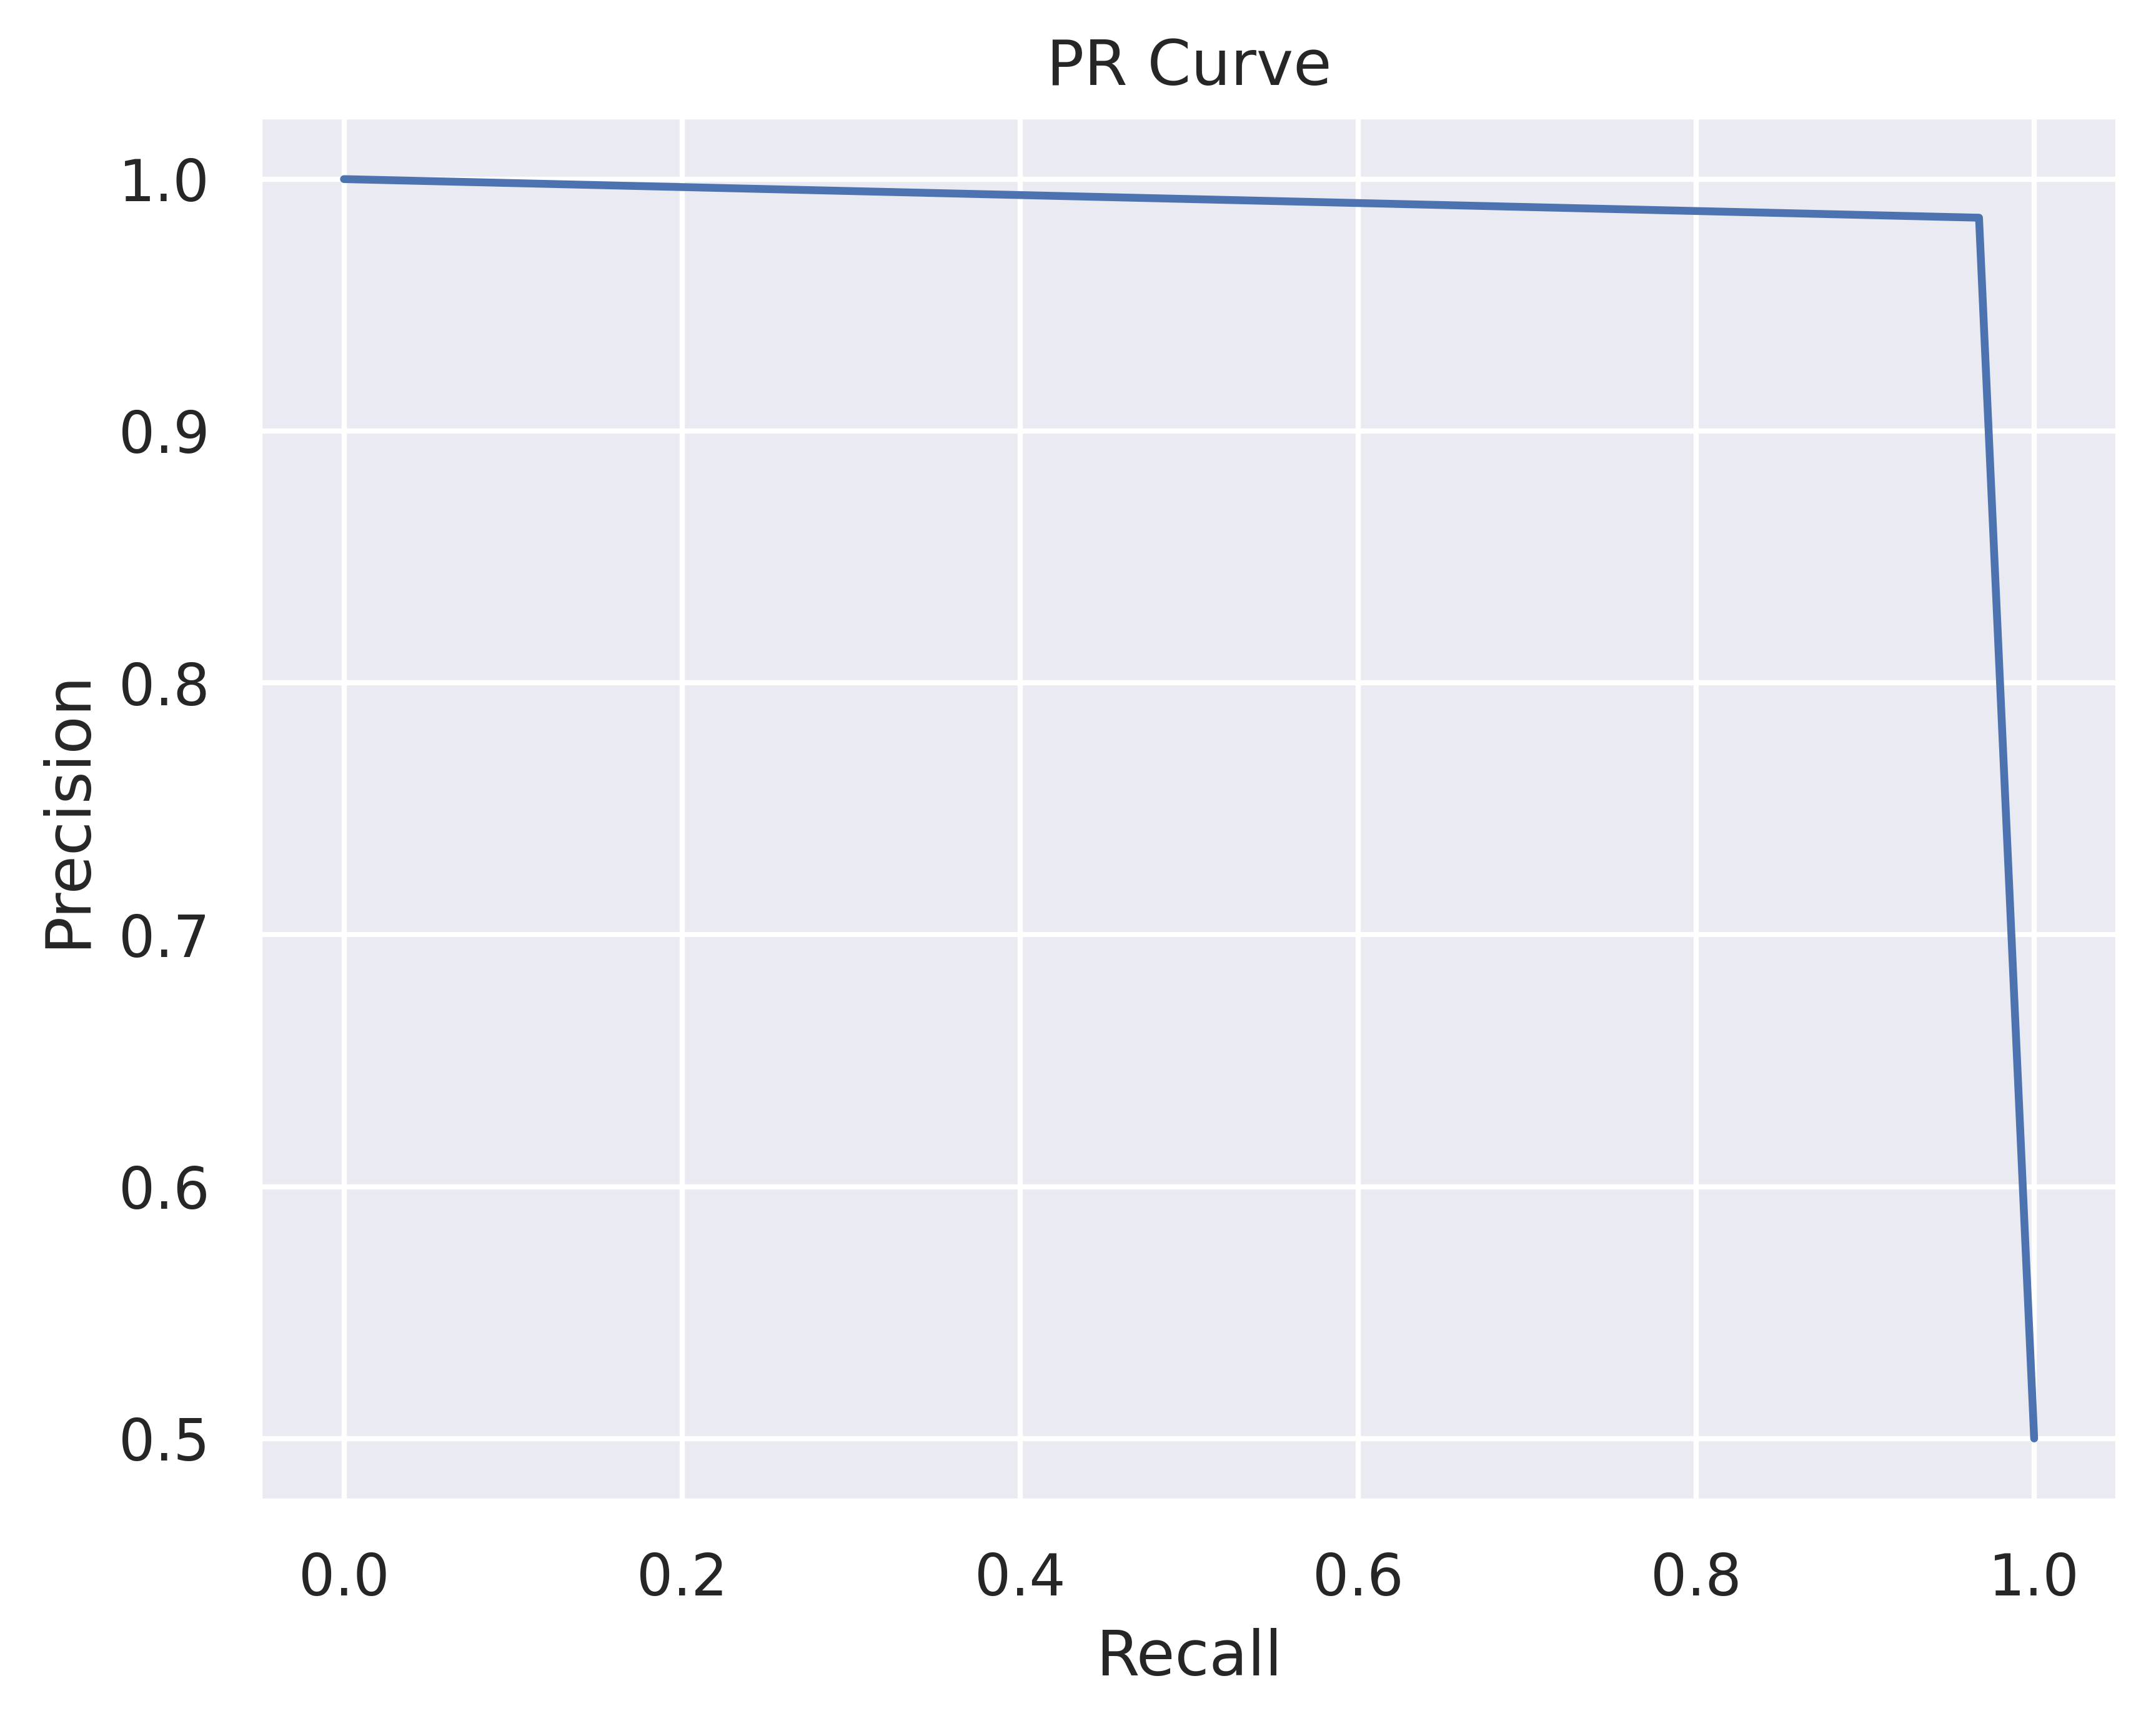

In [43]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Assume y_true and y_score are the true labels and predicted scores for the test data, respectively
precision, recall, threshold = precision_recall_curve(target[indexes_test], Y_pred_classes)

# Plot the PR curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve') 
plt.show()

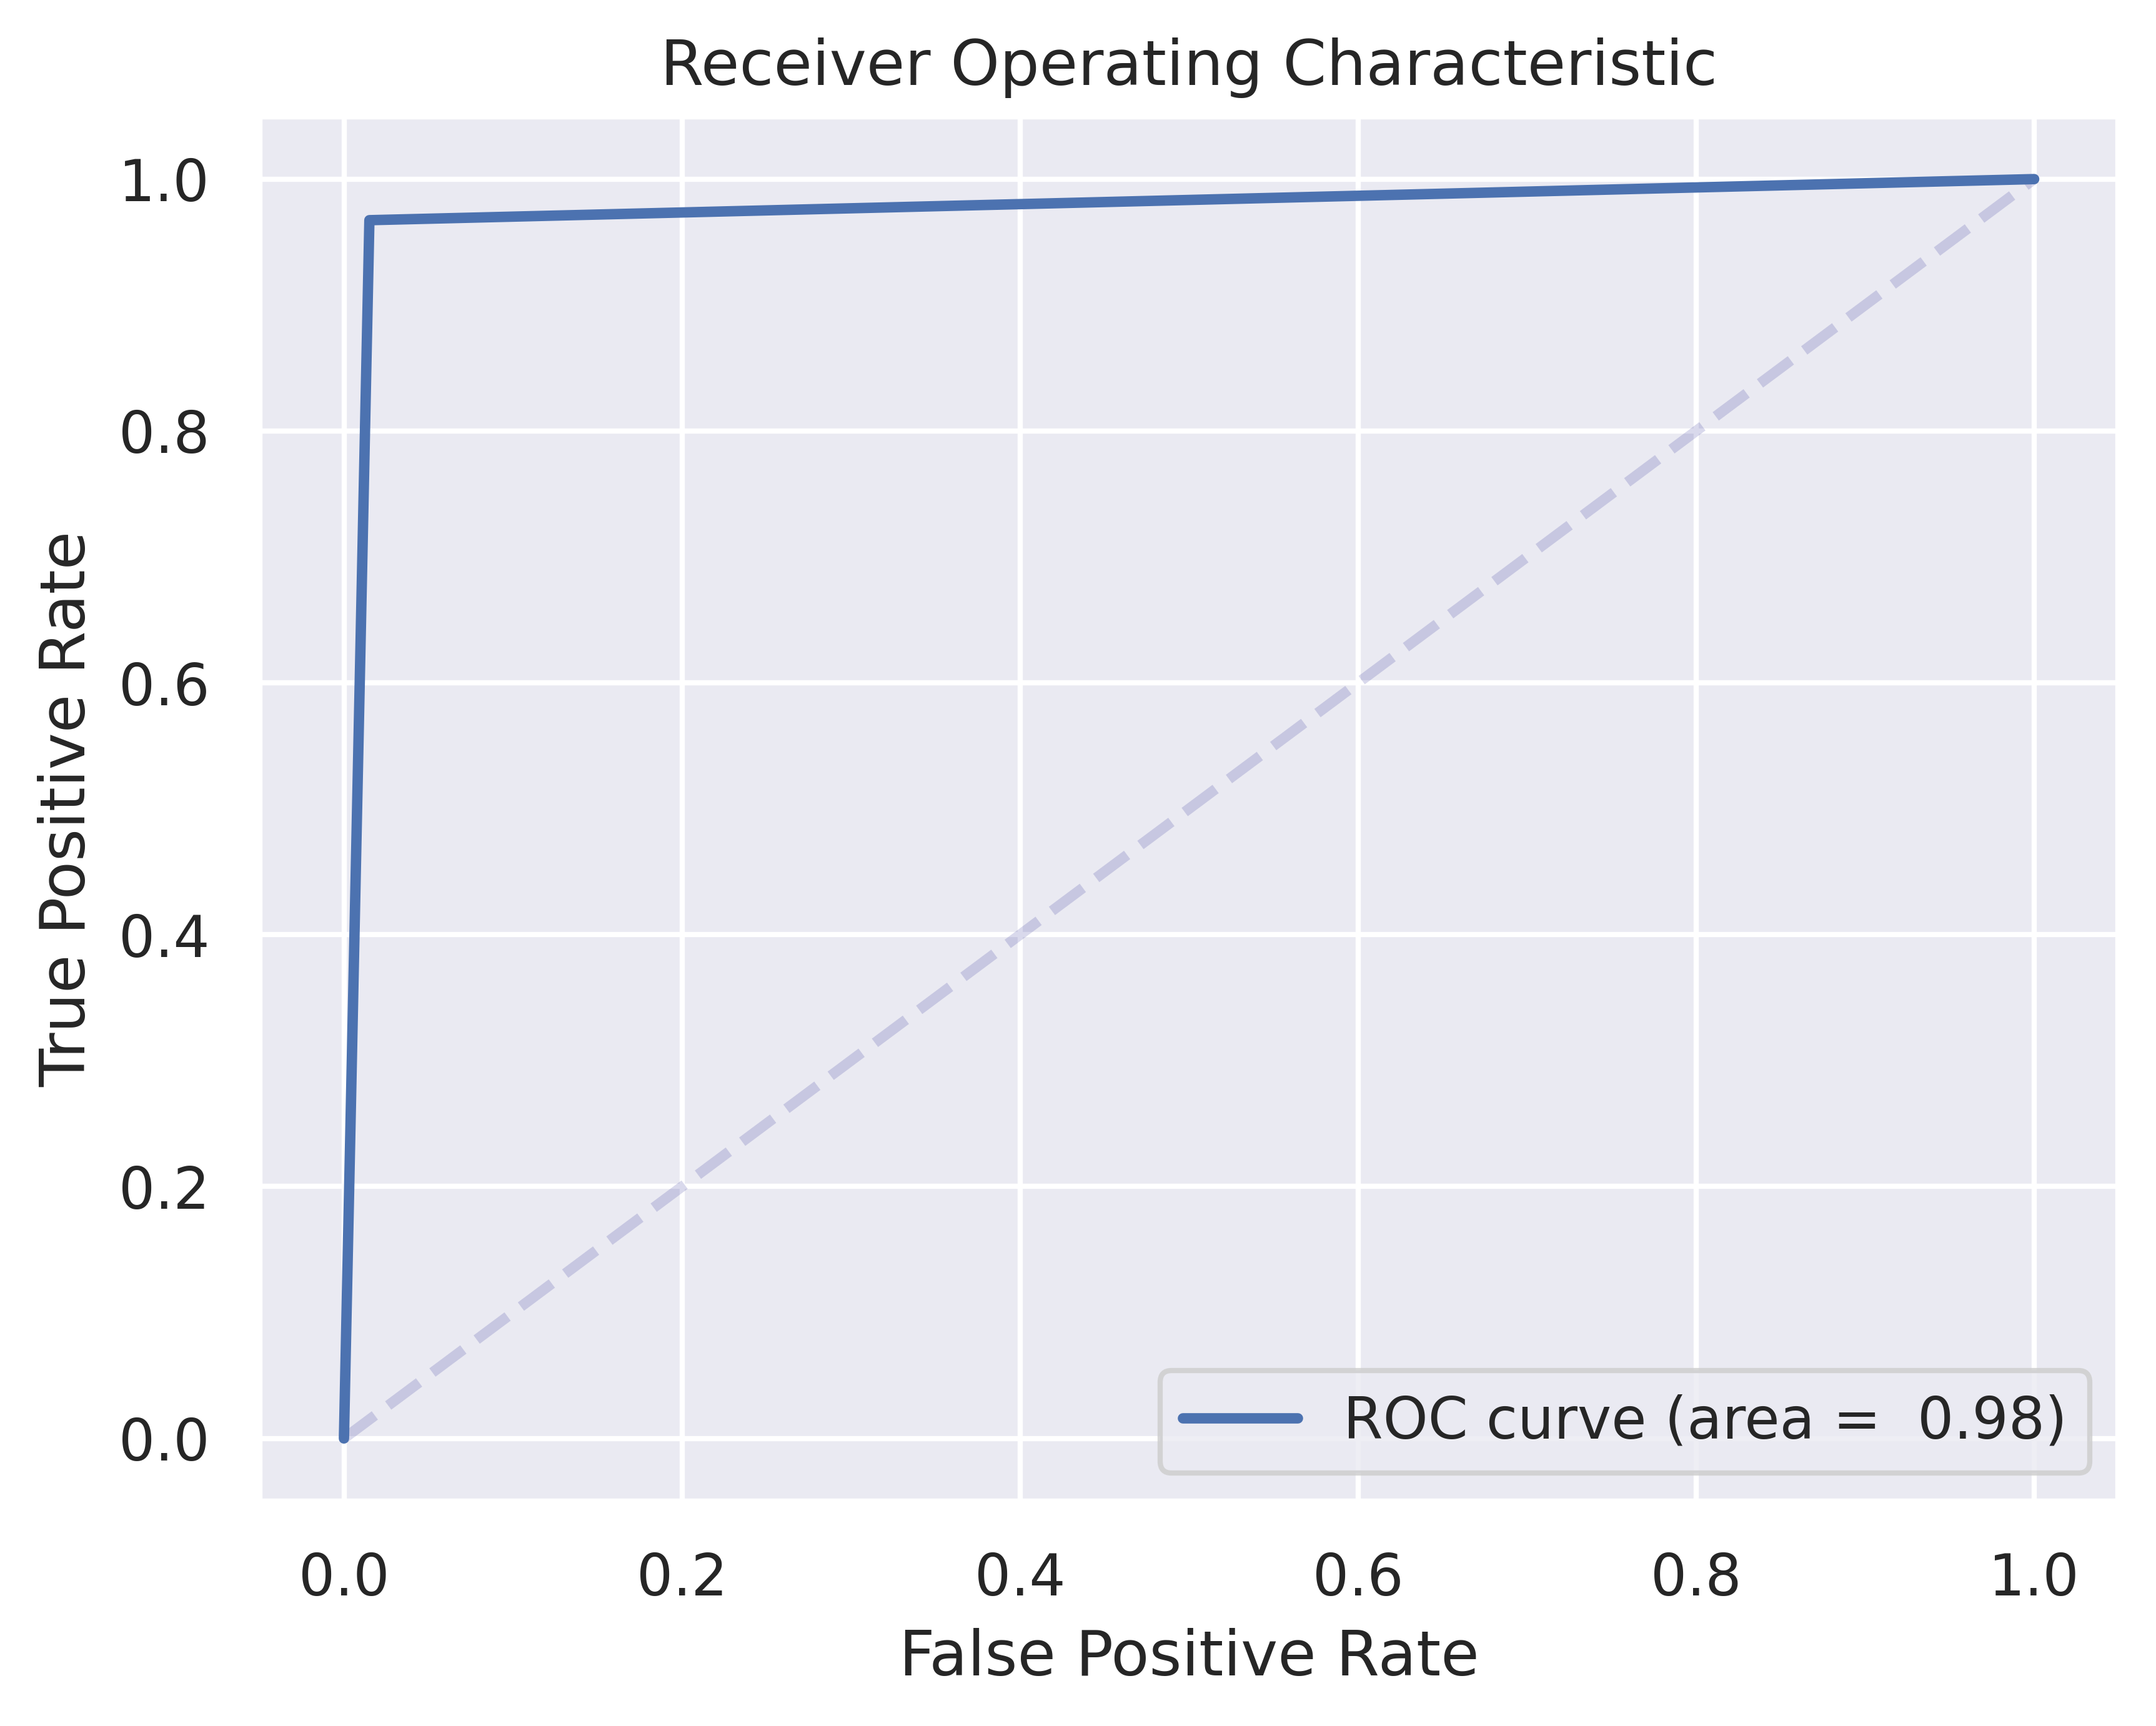

In [44]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(np.argmax(y_test, axis =1), np.argmax(predicted, axis =1), pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

lw = 2
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.15)
plt.plot(fpr, tpr, lw=lw, label=f'ROC curve (area = {roc_auc: 0.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [42]:
import matplotlib.pyplot as plt

# Retrieve the results of the hyperparameter search
tuner_results = tuner.results_summary()

if tuner_results is not None:
    # Get the hyperparameters and their corresponding values
    hyperparameters = tuner_results['hyperparameters']
    values = tuner_results['values']

    # Extract the metric values for evaluation (e.g., validation accuracy)
    metric = 'val_accuracy'
    metric_values = [trial[metric] for trial in values]

    # Plot the hyperparameters vs. metric values
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(metric_values)), metric_values, marker='o')
    plt.xticks(range(len(metric_values)), hyperparameters, rotation=45)
    plt.xlabel('Hyperparameters')
    plt.ylabel(metric)
    plt.title('Evaluation of Hyperparameters')
    plt.tight_layout()
    plt.show()
else:
    print("No tuner results available.")

Results summary
Results in path_to_directory/my_tuning_project_fold_5
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
conv1_filters: 32
conv2_filters: 160
conv3_filters: 192
dense_units: 384
dropout_rate: 0.30000000000000004
learning_rate: 0.0001
Score: 0.9310249388217926

Trial 08 summary
Hyperparameters:
conv1_filters: 32
conv2_filters: 32
conv3_filters: 320
dense_units: 320
dropout_rate: 0.4
learning_rate: 0.001
Score: 0.928808867931366

Trial 06 summary
Hyperparameters:
conv1_filters: 48
conv2_filters: 32
conv3_filters: 320
dense_units: 256
dropout_rate: 0.1
learning_rate: 0.001
Score: 0.9285318553447723

Trial 03 summary
Hyperparameters:
conv1_filters: 48
conv2_filters: 64
conv3_filters: 128
dense_units: 96
dropout_rate: 0.1
learning_rate: 0.001
Score: 0.9218836724758148

Trial 04 summary
Hyperparameters:
conv1_filters: 48
conv2_filters: 192
conv3_filters: 256
dense_units: 448
dropout_rate: 0.4
learning_rate: 0.001
Score: 0



---

---

\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::///////////////////////////////////////////////////////

---





---



---



**1st the GRAD-CAM Part**

In [46]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mm
###################################
plt.rcParams['figure.dpi'] = 600 #TO SET THE DPI TO 600
plt.rcParams['savefig.dpi'] = 600 #TO SET THE DPI T0 600

**Load the Model**

In [72]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Vit_GradCam/CNN_Bayesian222222')

In [59]:
#To get the layer's name of the model

for idx in range(len(model.layers)):
  print(model.get_layer(index = idx).name)

conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
flatten
dense
dropout
dense_1


(64, 64)


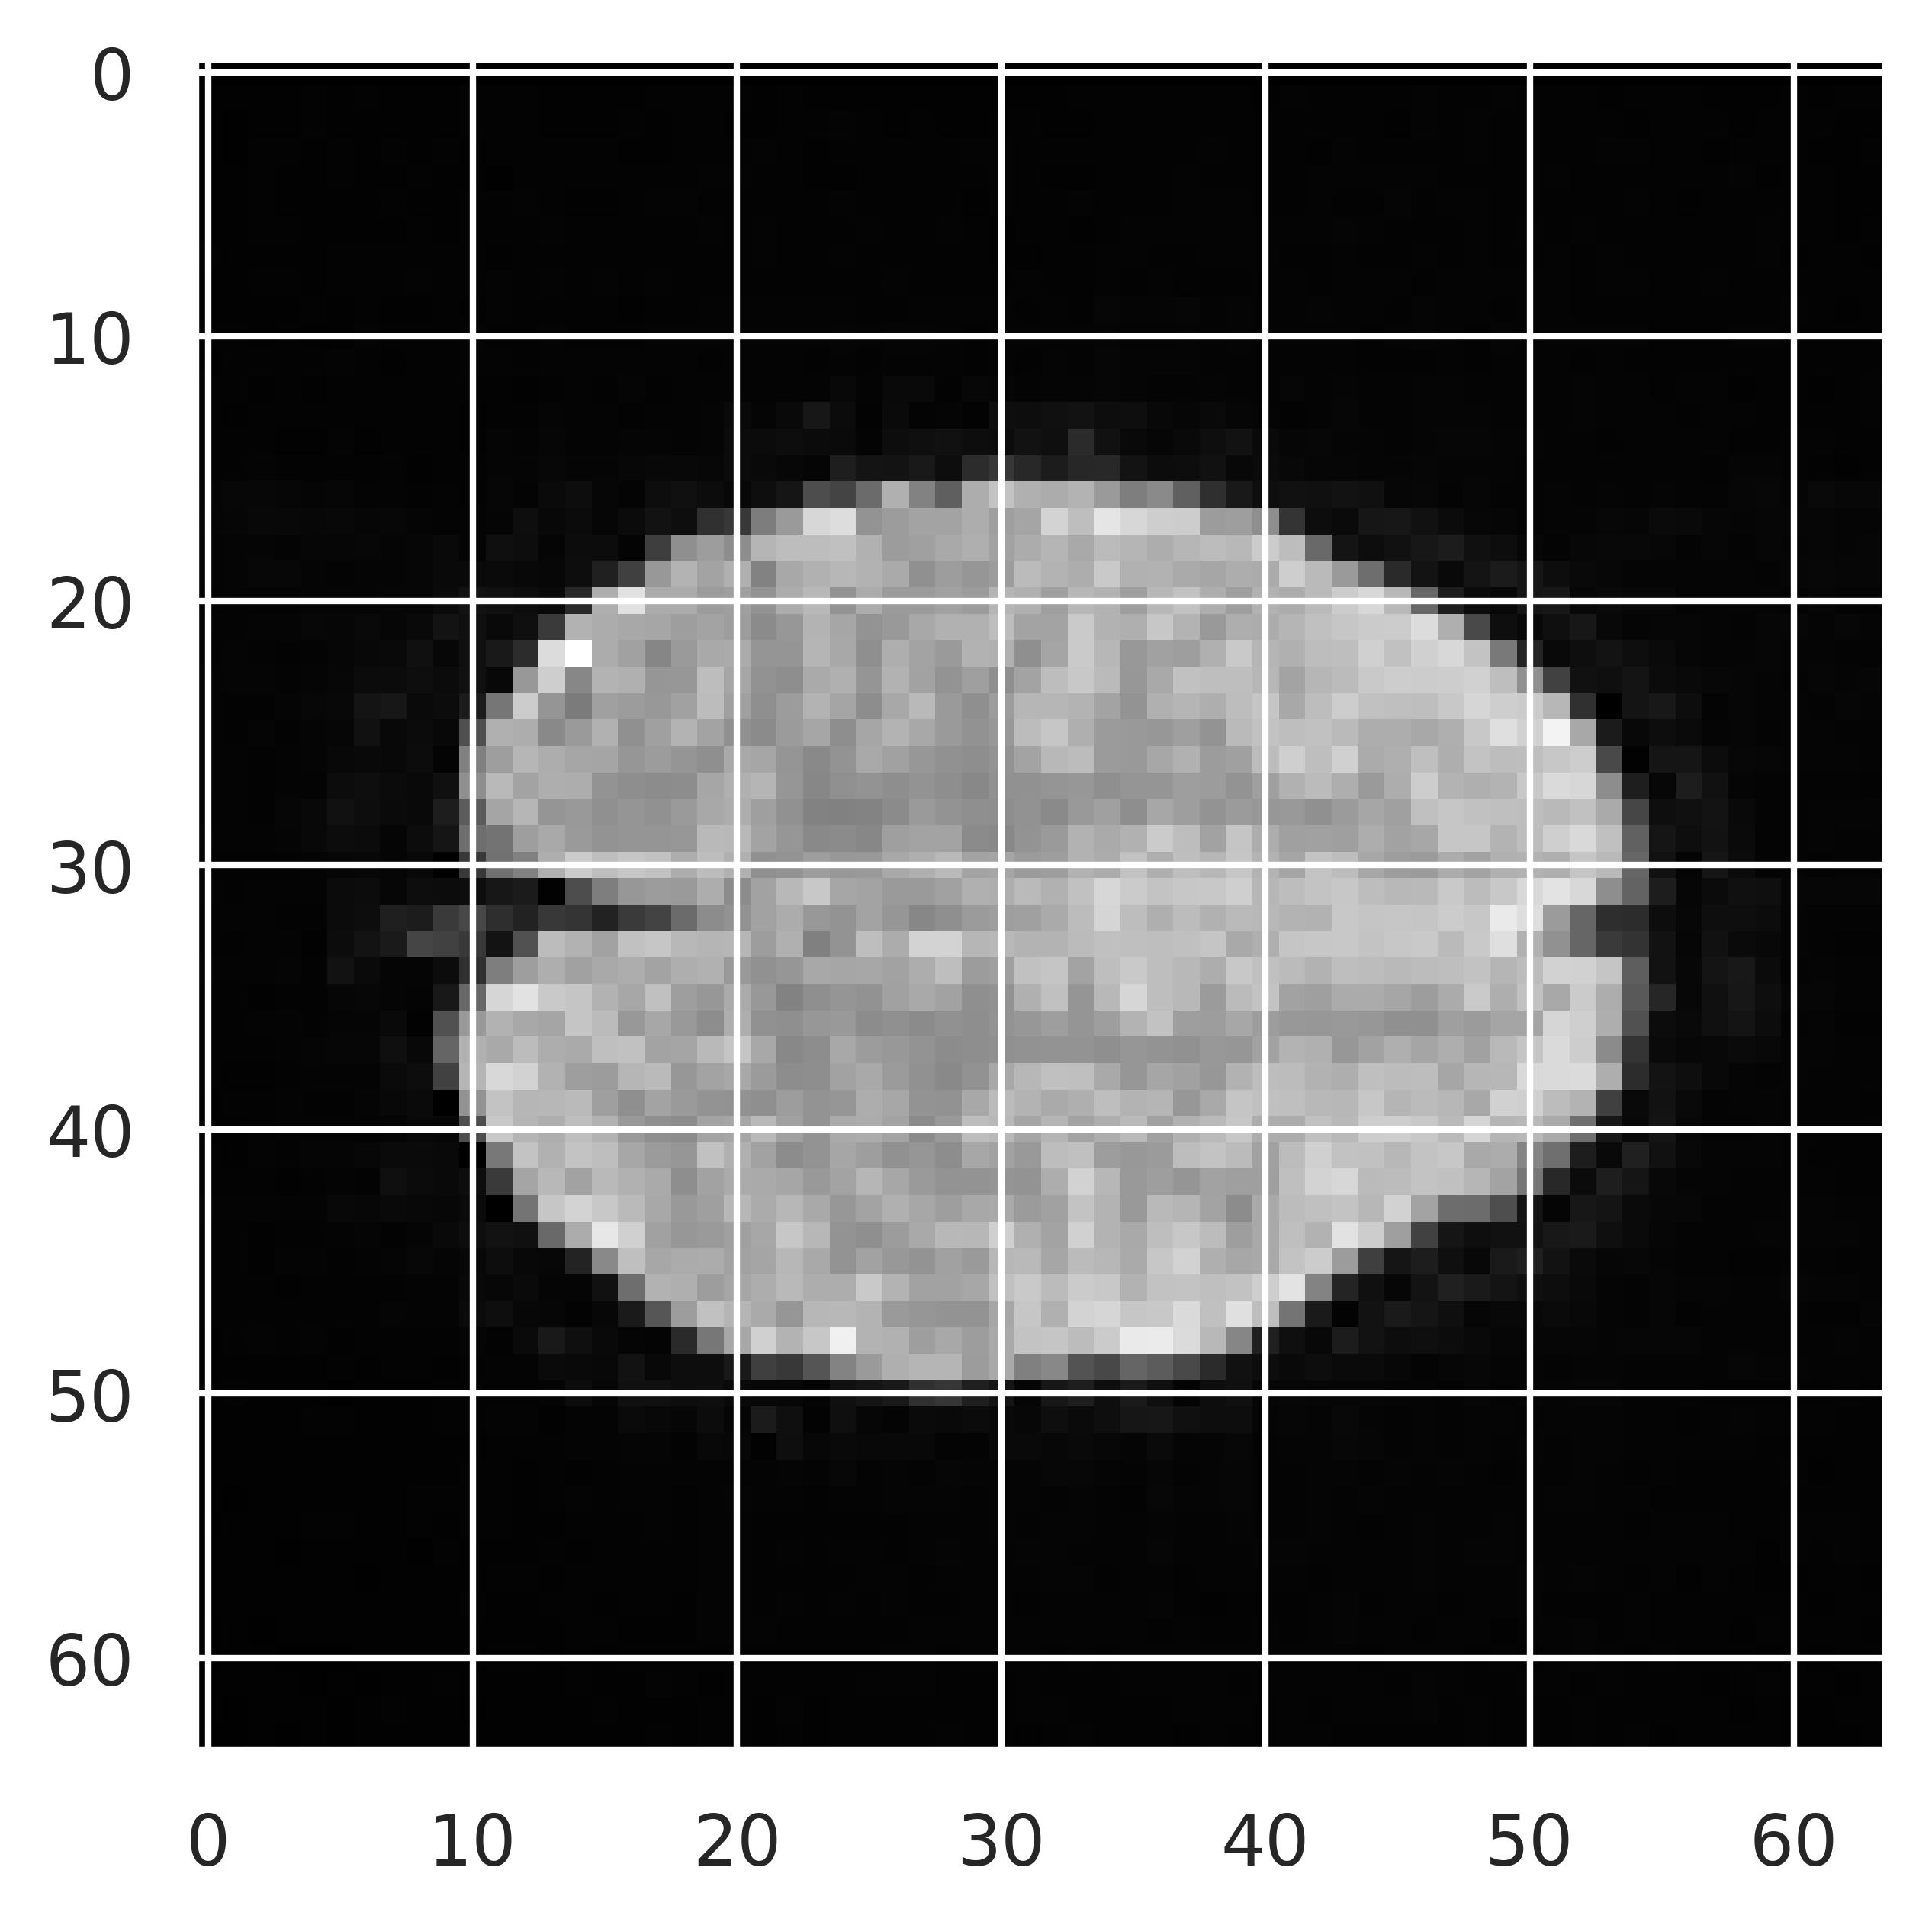

In [48]:
img_size = (64, 64)
image = full_data[55]
image1 = full_data[55]
print(image[:,:,2].shape)
plt.imshow(image[:,:,2], cmap='gray')
plt.show()

**Grad-CAM algorithm**

In [49]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

**Generate Heat-Map**

1/1 [==============================] - 0s 135ms/step
Class 0 and Class 1 %:  [0.9928508  0.00714925]
Predicted Class:  0
(12, 12)


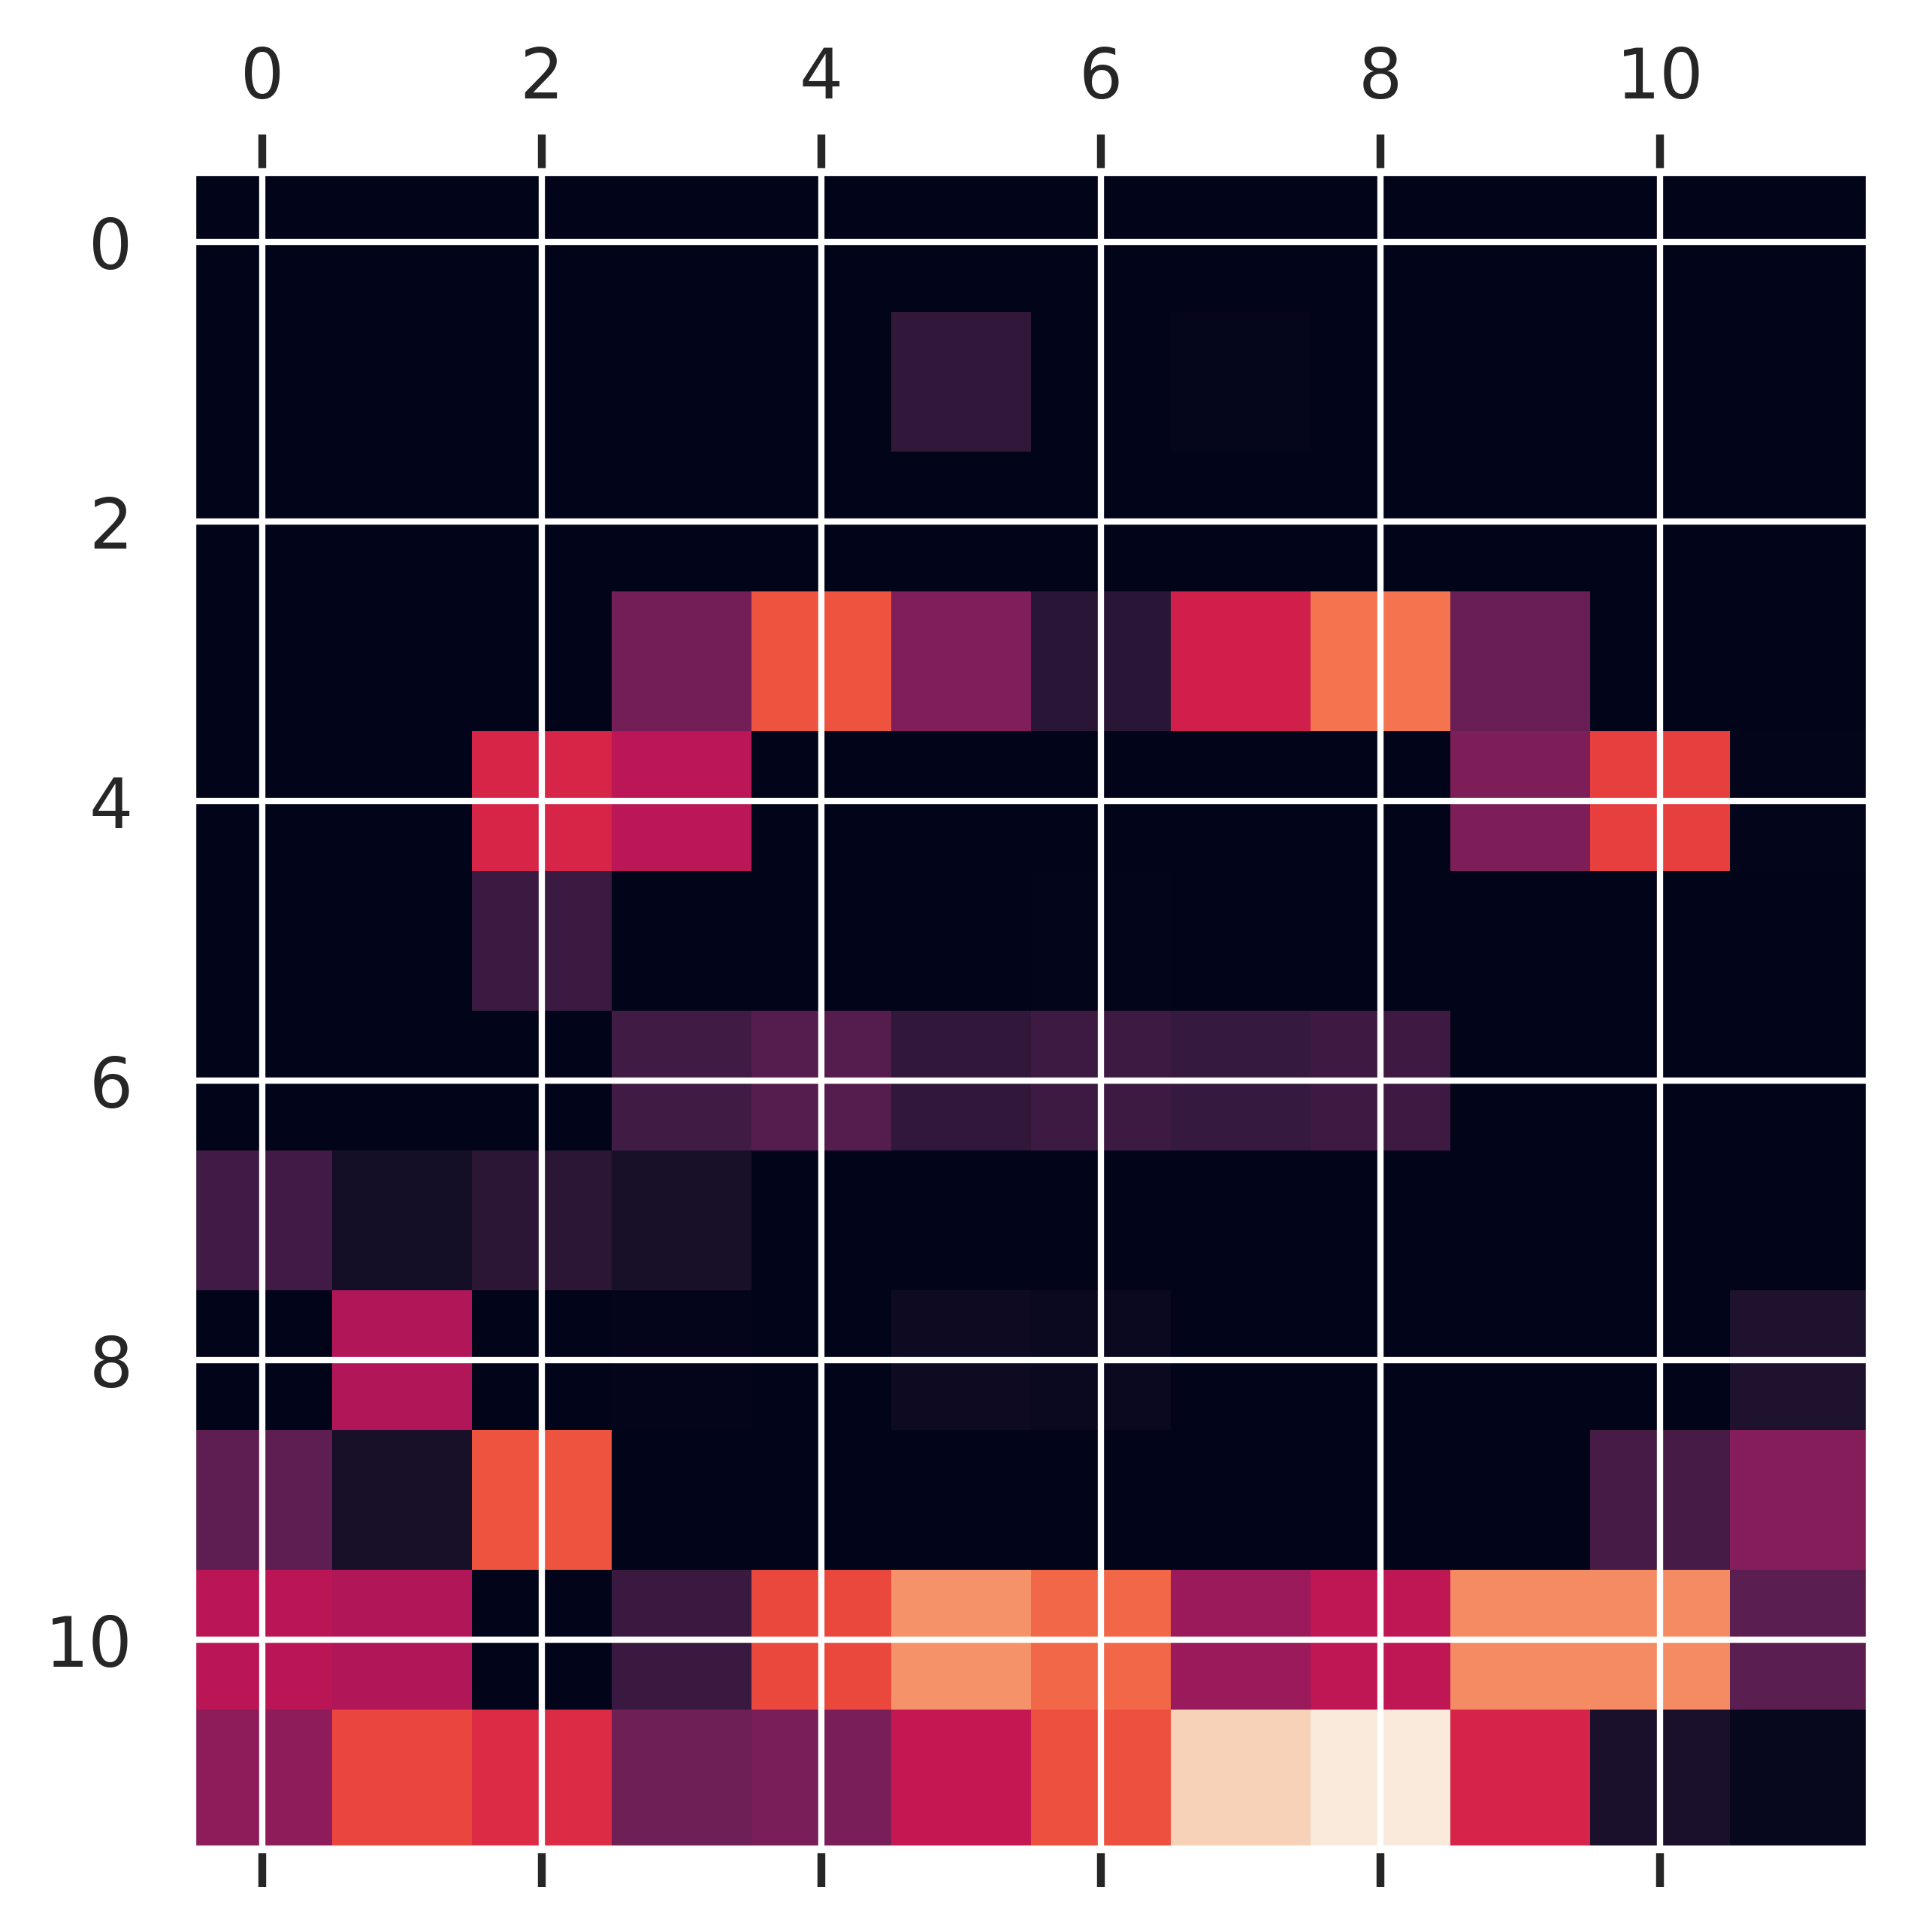

In [50]:
last_conv_layer_name = "conv2d_2"

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
image = full_data[55]
image1 = full_data[55]
image = np.expand_dims(image, axis=0)
# print(image.shape)
# print(image1.shape)
preds = model.predict(image)
i = np.argmax(preds[0])
print("Class 0 and Class 1 %: ",preds[0])
print("Predicted Class: ",i)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(image, model, last_conv_layer_name)
print(heatmap.shape)
# Display heatmap
plt.matshow(heatmap)
plt.show()

**Create a superimposed visualization**

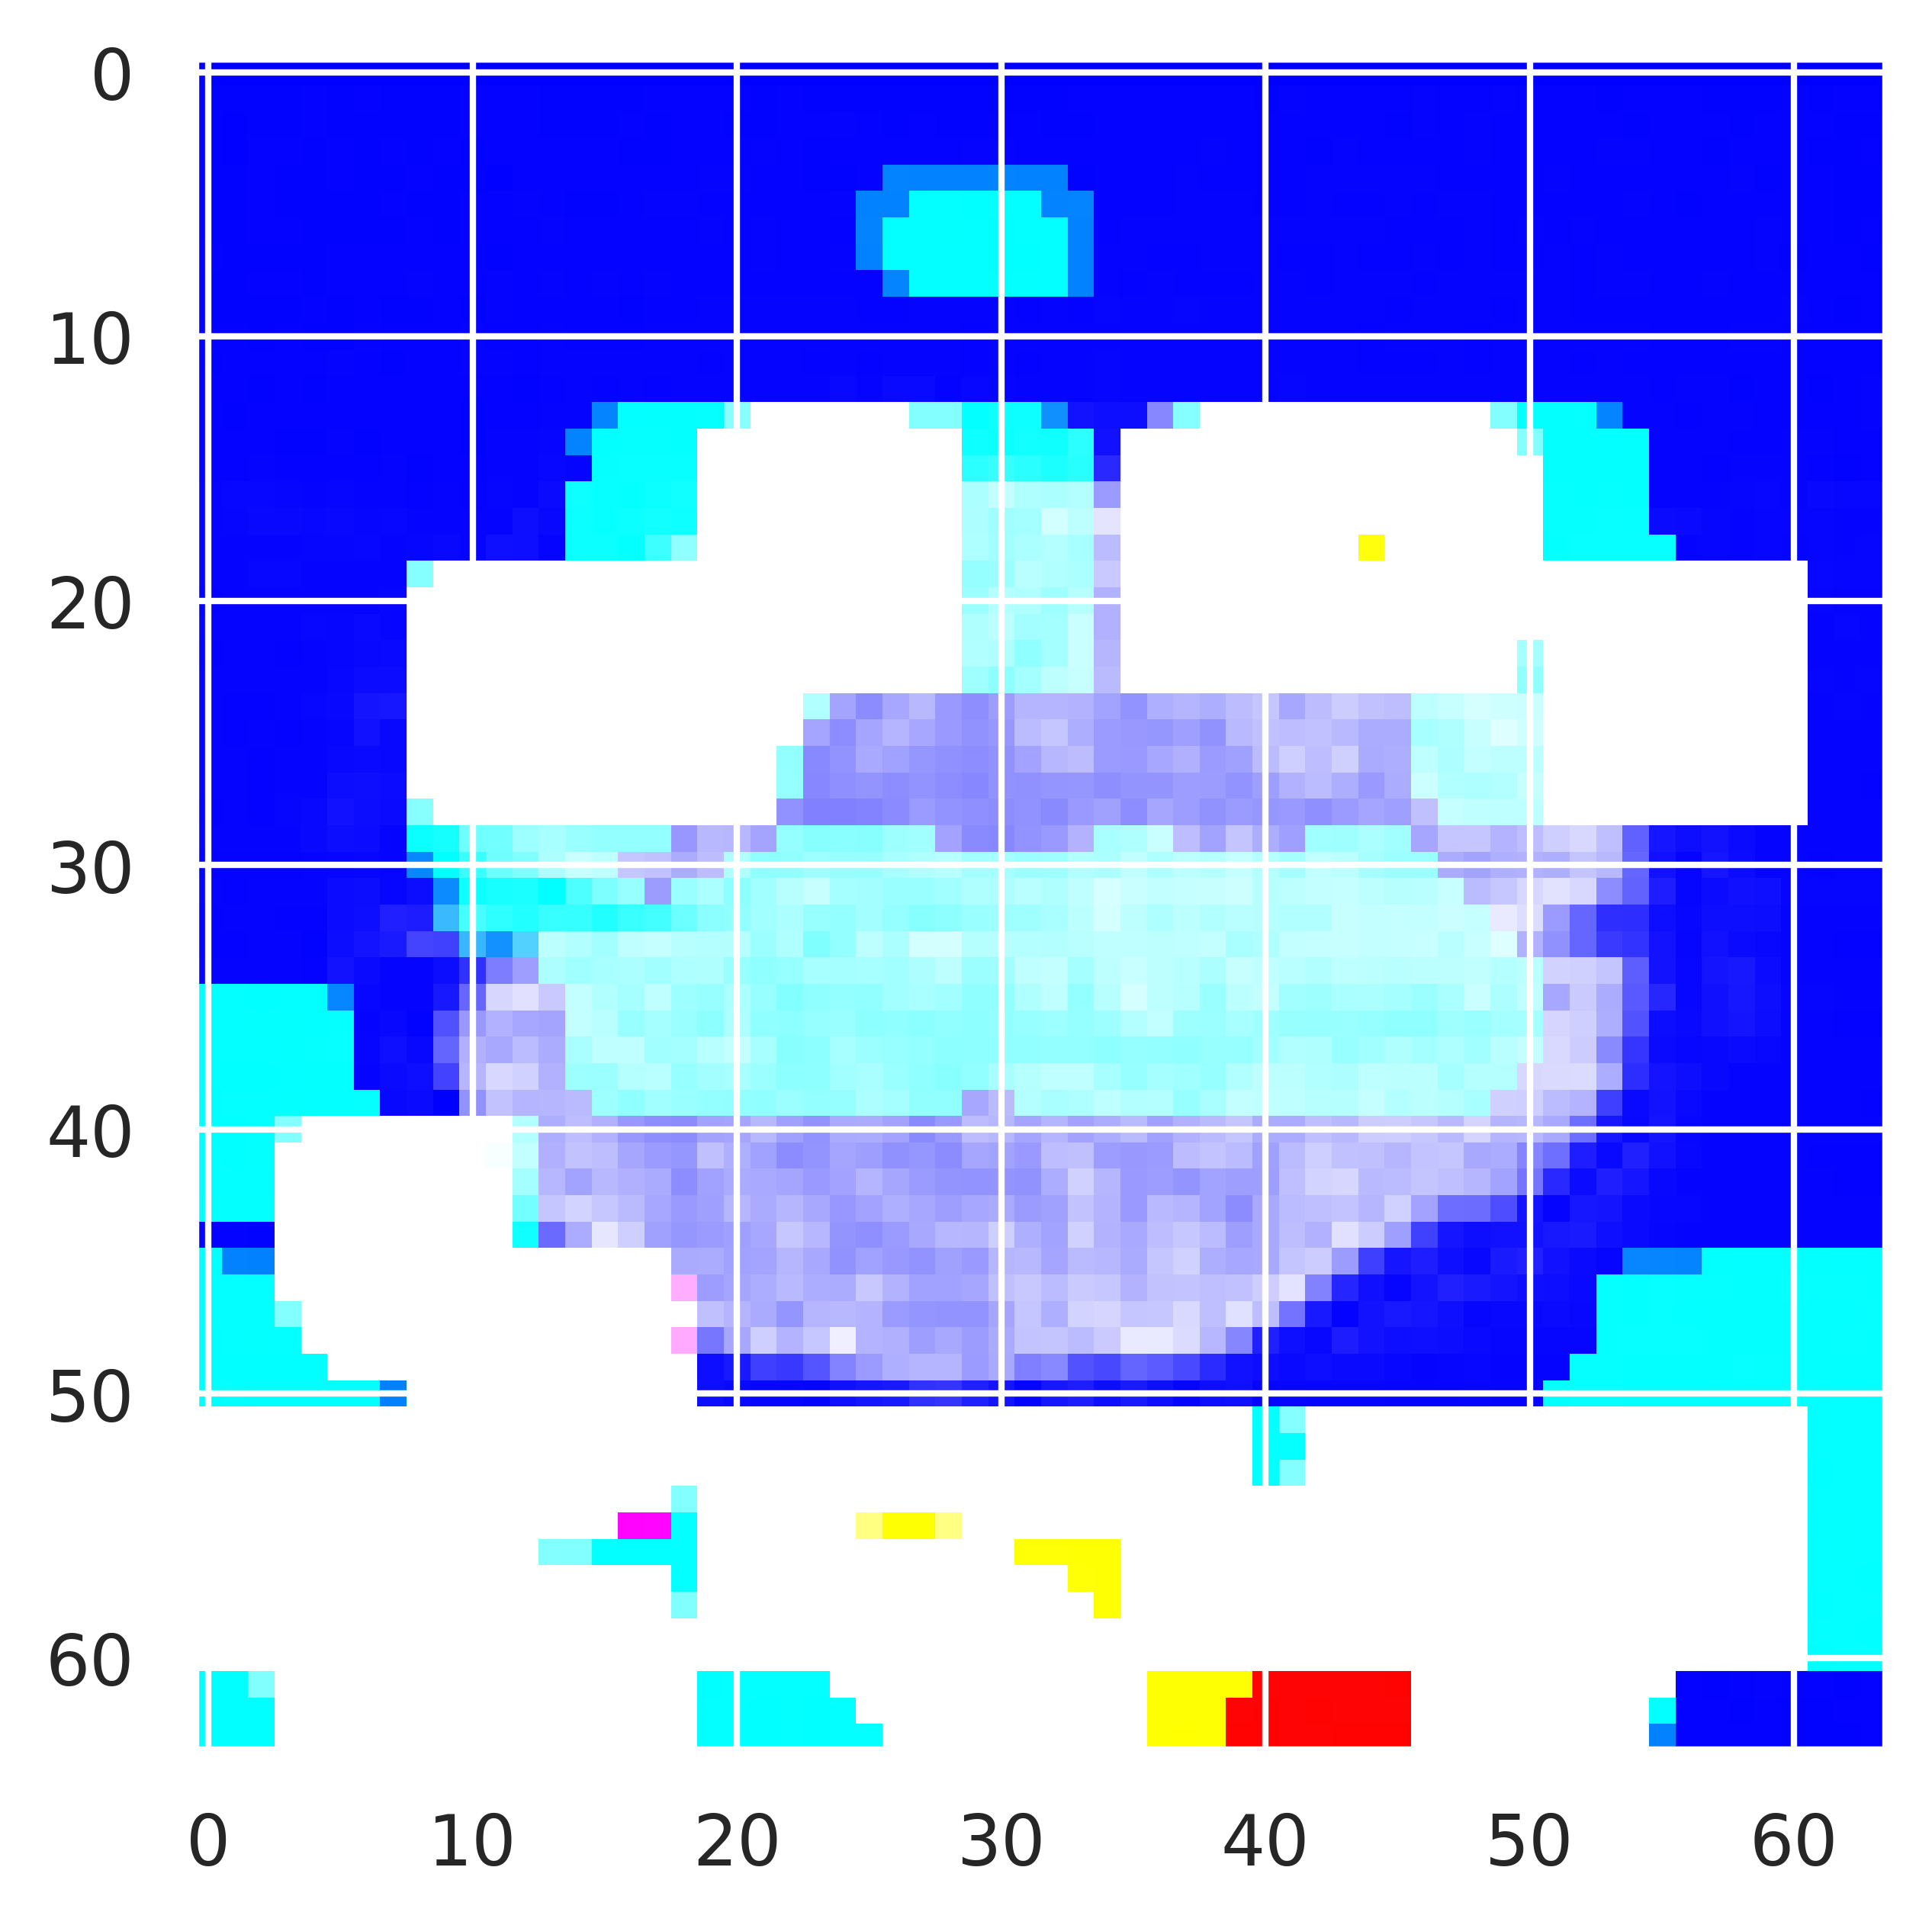

In [51]:
# Rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)
alpha=0.5

# Use jet colormap to colorize heatmap
jet = mm.colormaps.get_cmap("jet")

# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Create an image with RGB colorized heatmap
jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((image1.shape[1], image1.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
# For visualization purpose, we will also normalize the image between 0 & 1
image1 = tf.maximum(image1, 0) / tf.math.reduce_max(image1)
superimposed_img = jet_heatmap * alpha + image1

plt.imshow(superimposed_img)
plt.show()

## **Visualize Filters and Feature Maps in our CNN**

**First let us visualize the filters**

First to print a list of convolutional layer details including the convolutional layer name and the shape of the filters in the layer

In [73]:
from keras.applications.vgg16 import VGG16
from matplotlib import pyplot
import numpy as np
# load the model if it is not already loaded
'''
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Vit_GradCam/CNN_Bayesian111111111')
'''
# summarize filter shapes
for layer in model.layers:
  # check for convolutional layer
  if 'conv' not in layer.name:
    continue
  # get filter weights
  filters, biases = layer.get_weights()
  print(layer.name, filters.shape)

conv2d (3, 3, 3, 32)
conv2d_1 (3, 3, 32, 160)
conv2d_2 (3, 3, 160, 192)


**The output depends on your best model. In my case, this is the best best model and this is the output information from each of the convolutional layer. Yours might be different.**<br>
conv2d (3, 3, 3, 32)

conv2d_1 (3, 3, 32, 160)

conv2d_2 (3, 3, 160, 192)

This output means that the first convolutional layer has 32 filters with 3 channels with each filter having a size of 3×3. The second convolutional layer has 160 filters with 32 channels and a size of 3×3. The last convolutional layer has 192 filters with 160 channels and a size of 3×3.

### **Next we visualize the first six filters from the first convolutional layer from our model**

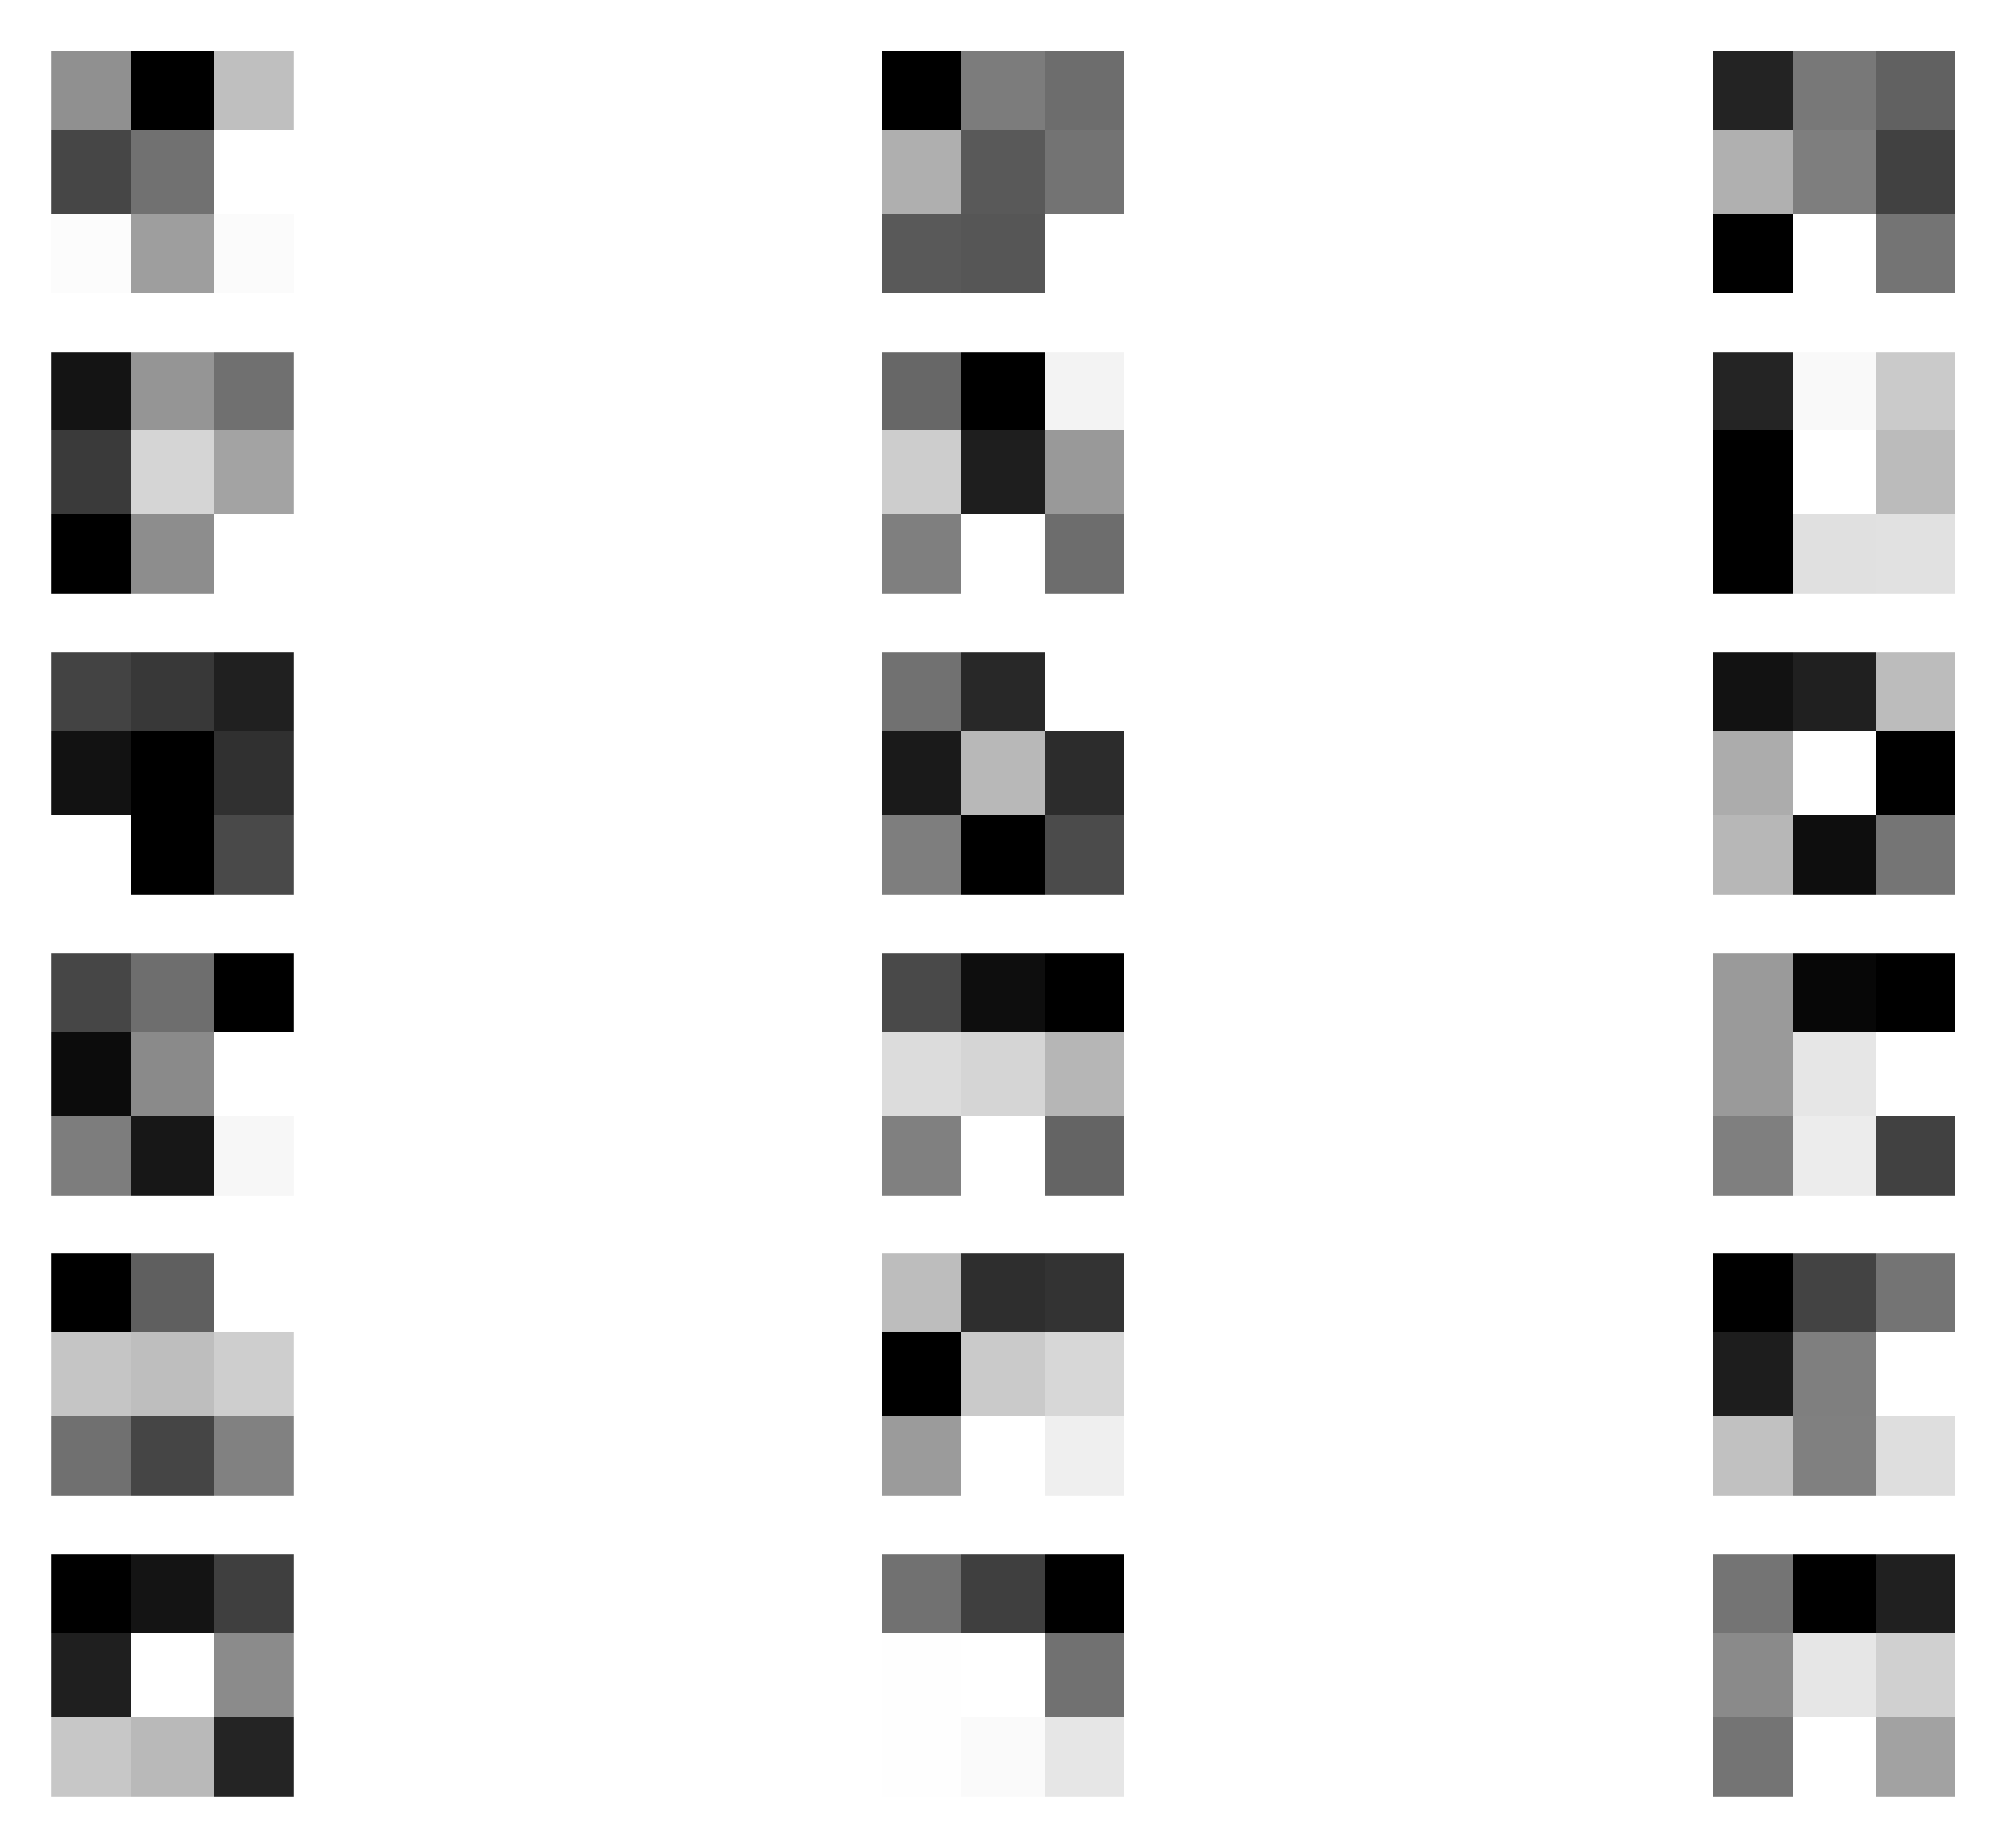

In [53]:
filters1, biases= model.layers[0].get_weights()
filters1=np.array(filters1)
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters1.min(), filters1.max()
filters1 = (filters1 - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
  # get the filter
  f = filters1[:, :, :, i]
  # plot each channel separately
  for j in range(3):
    # specify subplot and turn of axis
    ax = pyplot.subplot(n_filters, 3, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    pyplot.imshow(f[:, :, j], cmap='gray')
    ix += 1
# show the figure
pyplot.show()

In [ ]:
#Explaining how the filters are retrieved from the 1st Convolutional layer
'''
filters1, biases= model.layers[0].get_weights()
filters1=np.array(filters1)
#print(filters1[0])
#print(filters1[1])
print(filters1.shape)
print(filters1[0].shape)
print(filters1[1].shape)
print(filters1[2].shape)
#print(filters1[3].shape)
f_min, f_max = np.min(filters1), np.max(filters1)
print("--------------------------------------------------------------------------------------------------")
print("MIN, MAX: ",f_min, f_max)
'''

In [ ]:
#Explaining how the filters are retrieved from the 2nd Convolutional layer
'''
filters2, biases= model.layers[2].get_weights()
filters2=np.array(filters2)
#print(filters1[0])
#print(filters1[1])
print(filters2.shape)
print(filters2[0].shape)
print(filters2[1].shape)
print(filters2[2].shape)
#print(filters2[3].shape)
print("--------------------------------------------------------------------------------------------------")
f_min, f_max = np.min(filters2), np.max(filters2)
print("--------------------------------------------------------------------------------------------------")
print("MIN, MAX: ",f_min, f_max)
'''

In [ ]:
#Explaining how the filters are retrieved from the 3rd Convolutional layer
'''
filters3, biases= model.layers[4].get_weights()
filters3=np.array(filters3)
print(filters3.shape)
print(filters3[0].shape)
print(filters3[1].shape)
print(filters3[2].shape)
#print(filters3[3].shape)
print("--------------------------------------------------------------------------------------------------")
f_min, f_max = np.min(filters3), np.max(filters3)
print("--------------------------------------------------------------------------------------------------")
print("MIN, MAX: ",f_min, f_max)
'''

### **Next we visualize the first six filters from the second convolutional layer from our model**

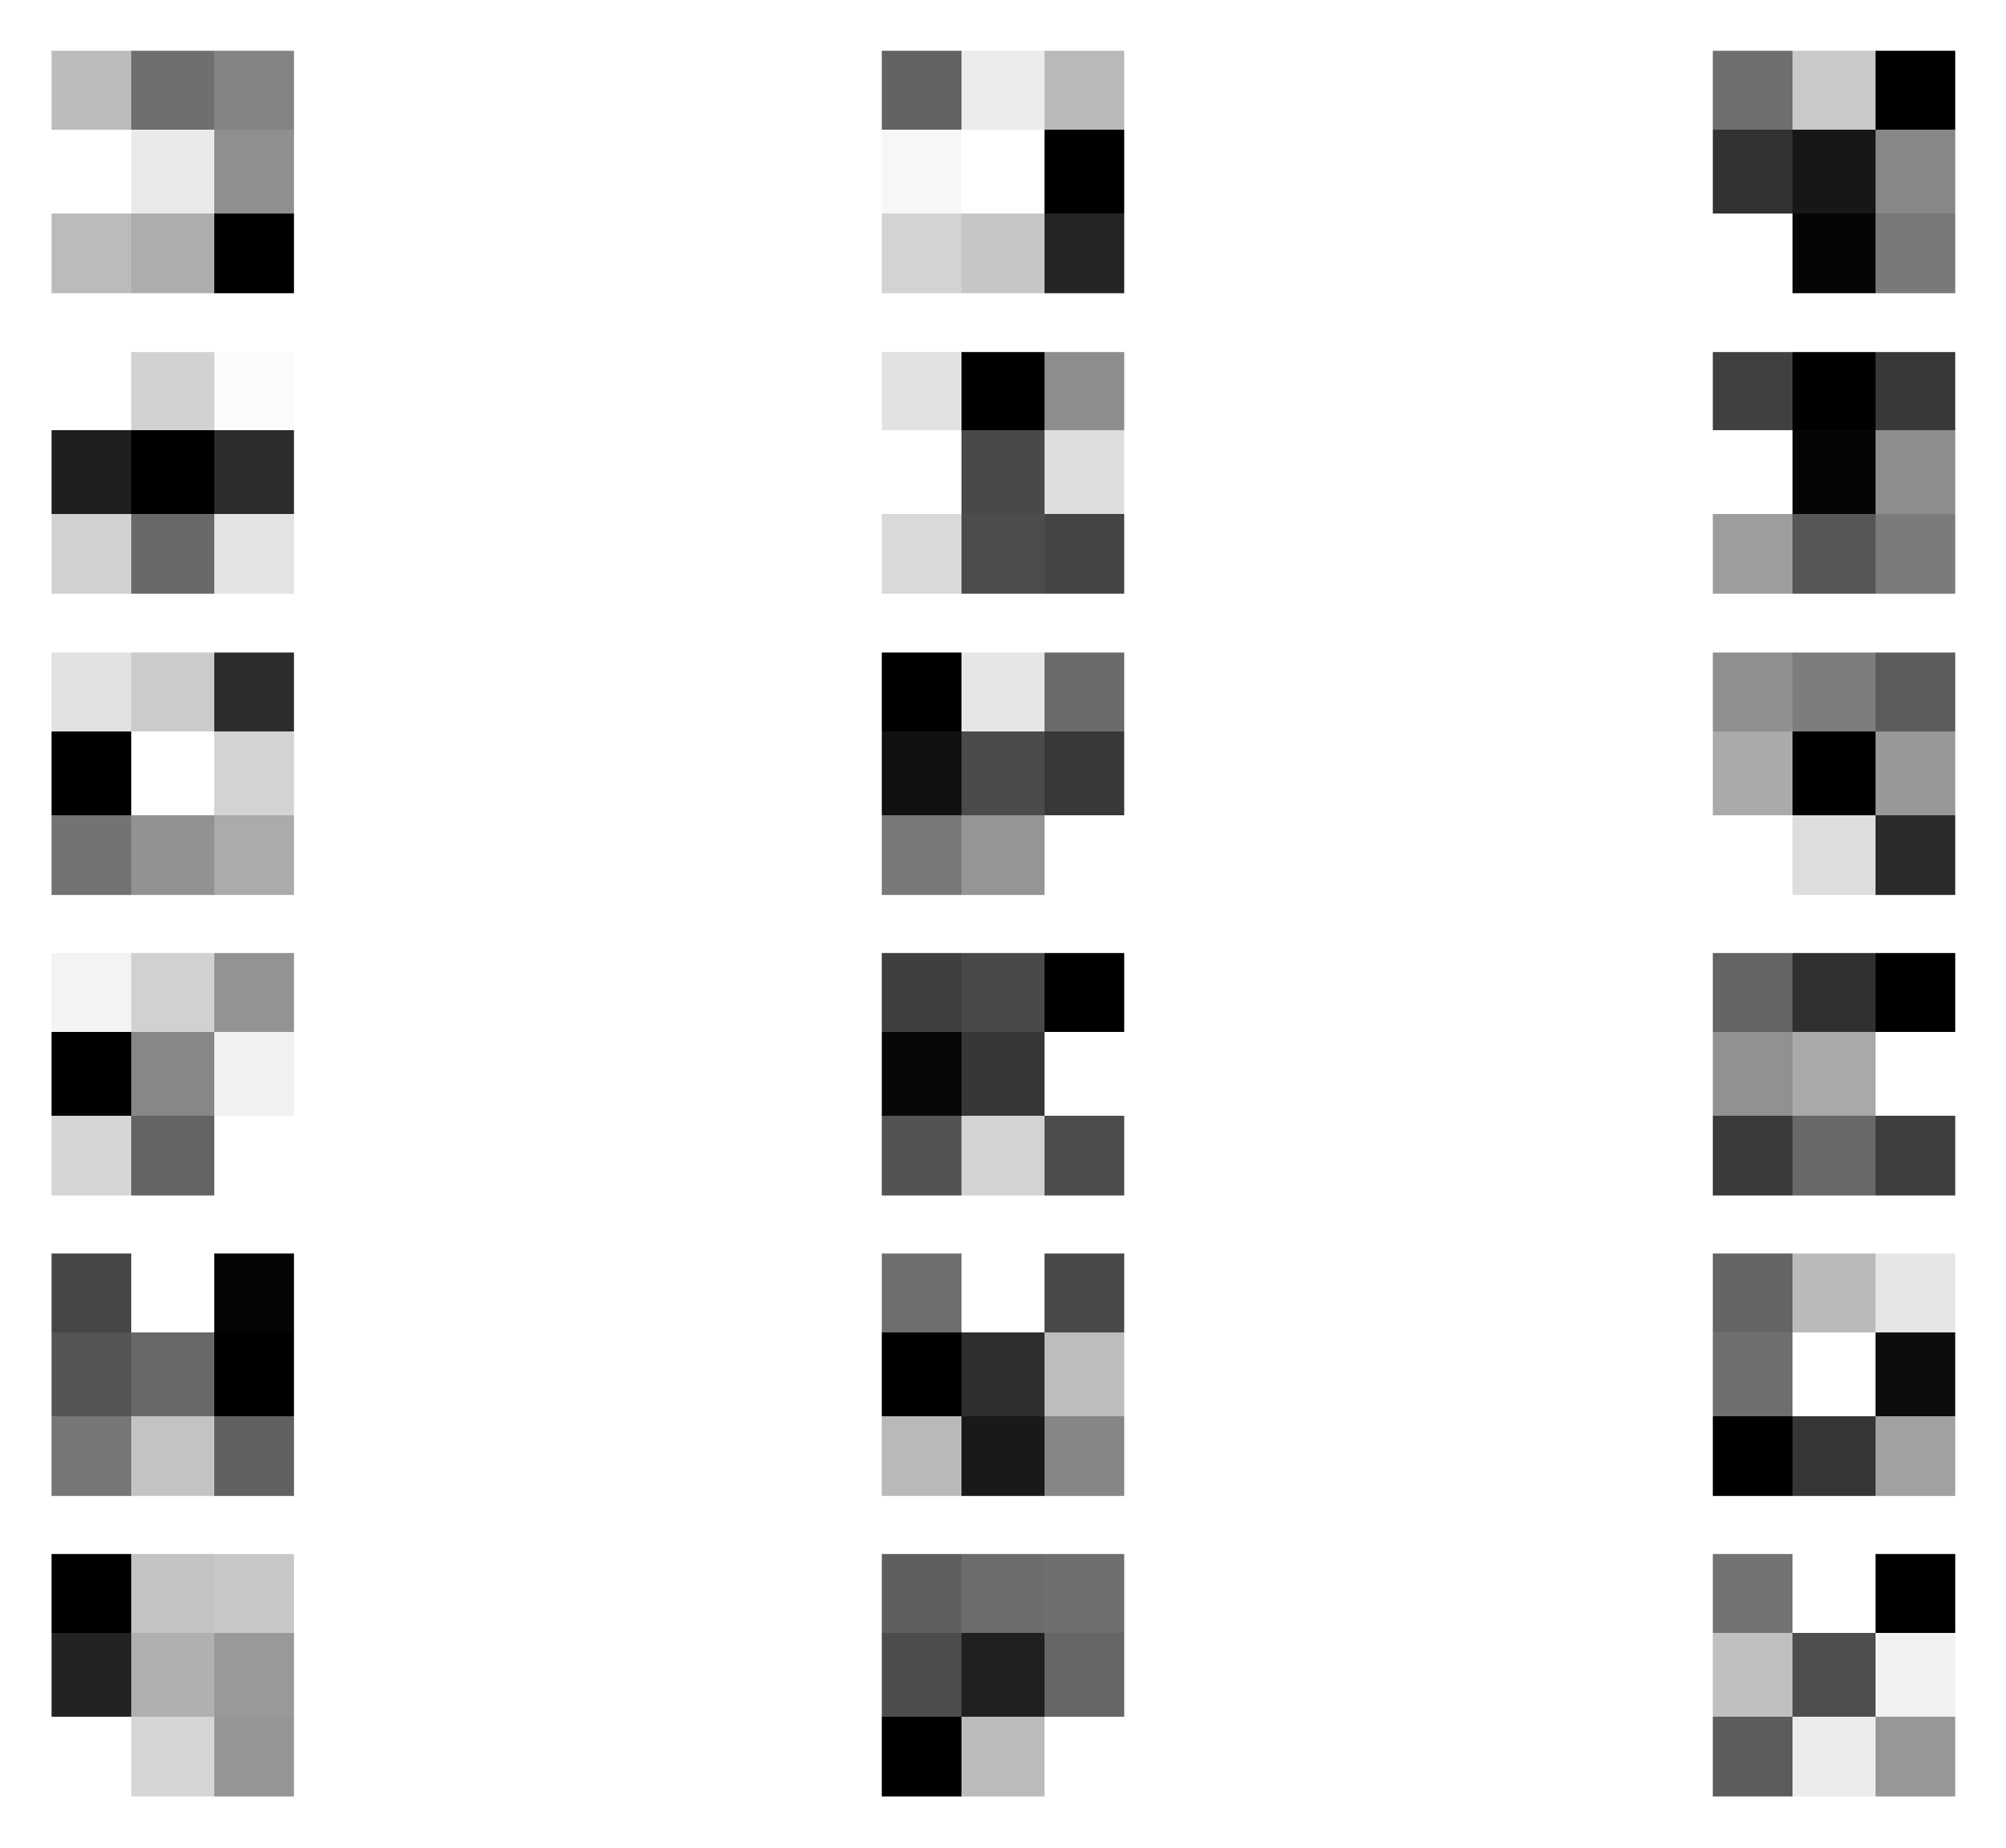

In [54]:
filters2, biases= model.layers[2].get_weights()
filters2=np.array(filters2)
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters2.min(), filters2.max()
filters2 = (filters2 - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
  # get the filter
  f = filters2[:, :, :, i]
  # plot each channel separately
  for j in range(3):
    # specify subplot and turn of axis
    ax = pyplot.subplot(n_filters, 3, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    pyplot.imshow(f[:, :, j], cmap='gray')
    ix += 1
# show the figure
pyplot.show()

### **Next we visualize the first six filters from the third convolutional layer from our model**

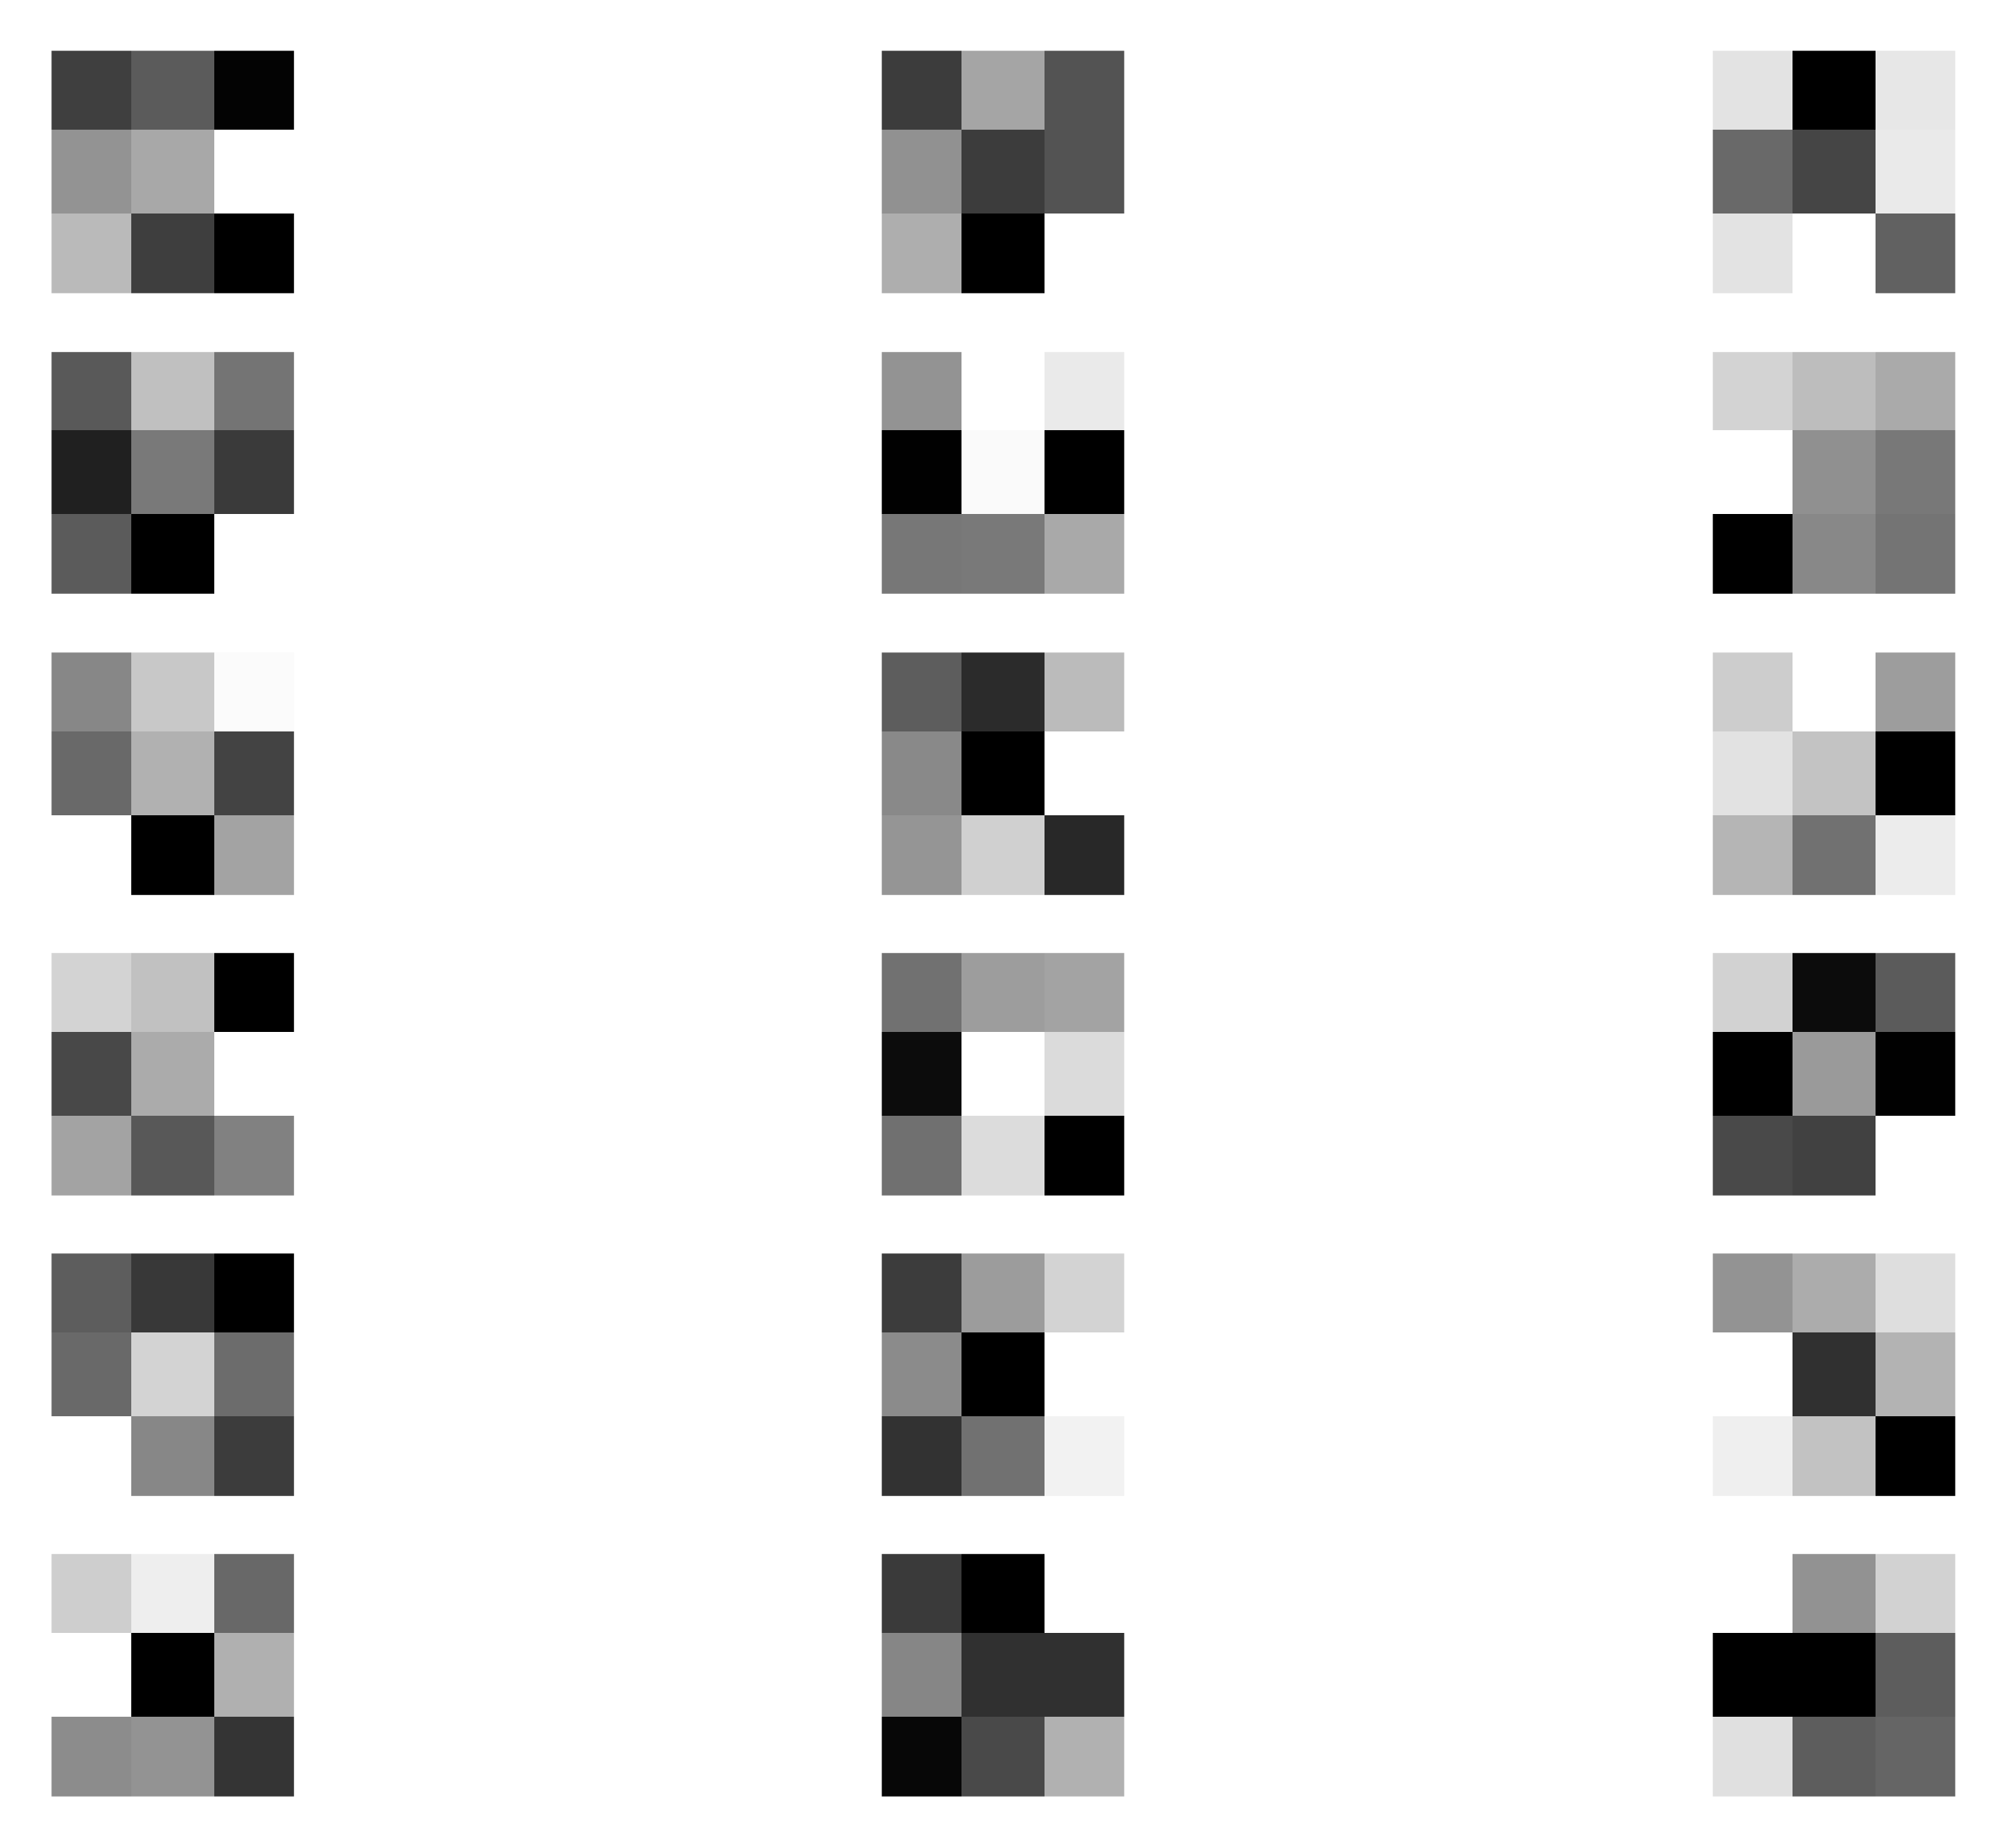

In [55]:
filters3, biases= model.layers[4].get_weights()
filters3=np.array(filters3)
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters3.min(), filters3.max()
filters3 = (filters3 - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
  # get the filter
  f = filters3[:, :, :, i]
  # plot each channel separately
  for j in range(3):
    # specify subplot and turn of axis
    ax = pyplot.subplot(n_filters, 3, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    pyplot.imshow(f[:, :, j], cmap='gray')
    ix += 1
# show the figure
pyplot.show()

## **Visualizing Feature Maps**

**Write up**:

<u>Visualizing Feature Maps</u>:<br>
When we convolve the filters with an fMRI image, the feature maps are generated and so to better grasps what features are being captivated, we visualize the feature maps. In CNN, the feature maps that are closer to the image are said to capture specific details from the image, whereas, the feature maps that are nearer to the output would read general and broader details. Here in fig. __, we have taken an fMRI image and visualized the feature maps from the first convolutional layer. As the first convolutional layer produces __ feature maps, we have displayed  the feature maps are as an __×__ square of images. Similiarly, the second convolutional layer has __ feature maps, so we have displayed them in an area of __×__ square of images. And finally, the third convolutional layer has __ feature maps, so we have displayed them in an area of __×__ square of images.
 

To print the output size or feature map size for each convolutional layer as well as the layer index in the model

In [56]:
for i in range(len(model.layers)):
  layer = model.layers[i]
  # check for convolutional layer
  if 'conv' not in layer.name:
    continue
  # summarize output shape
  print(i, layer.name, layer.output.shape)

0 conv2d (None, 62, 62, 32)
2 conv2d_1 (None, 29, 29, 160)
4 conv2d_2 (None, 12, 12, 192)


**Code to visualize the feature map for the first convolutional layer from our model**

### Here we are visualizing the feature maps from the first convolotional layer. As we provide an fMRI image to our model, the image traverses through the first convolutional layer and a total of 32 feature maps (in my case 32, yours might be different) are being generated. In the fig....., we have shown the visualization of 25 feature maps placed in an square of 5×5.  

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 40ms/step


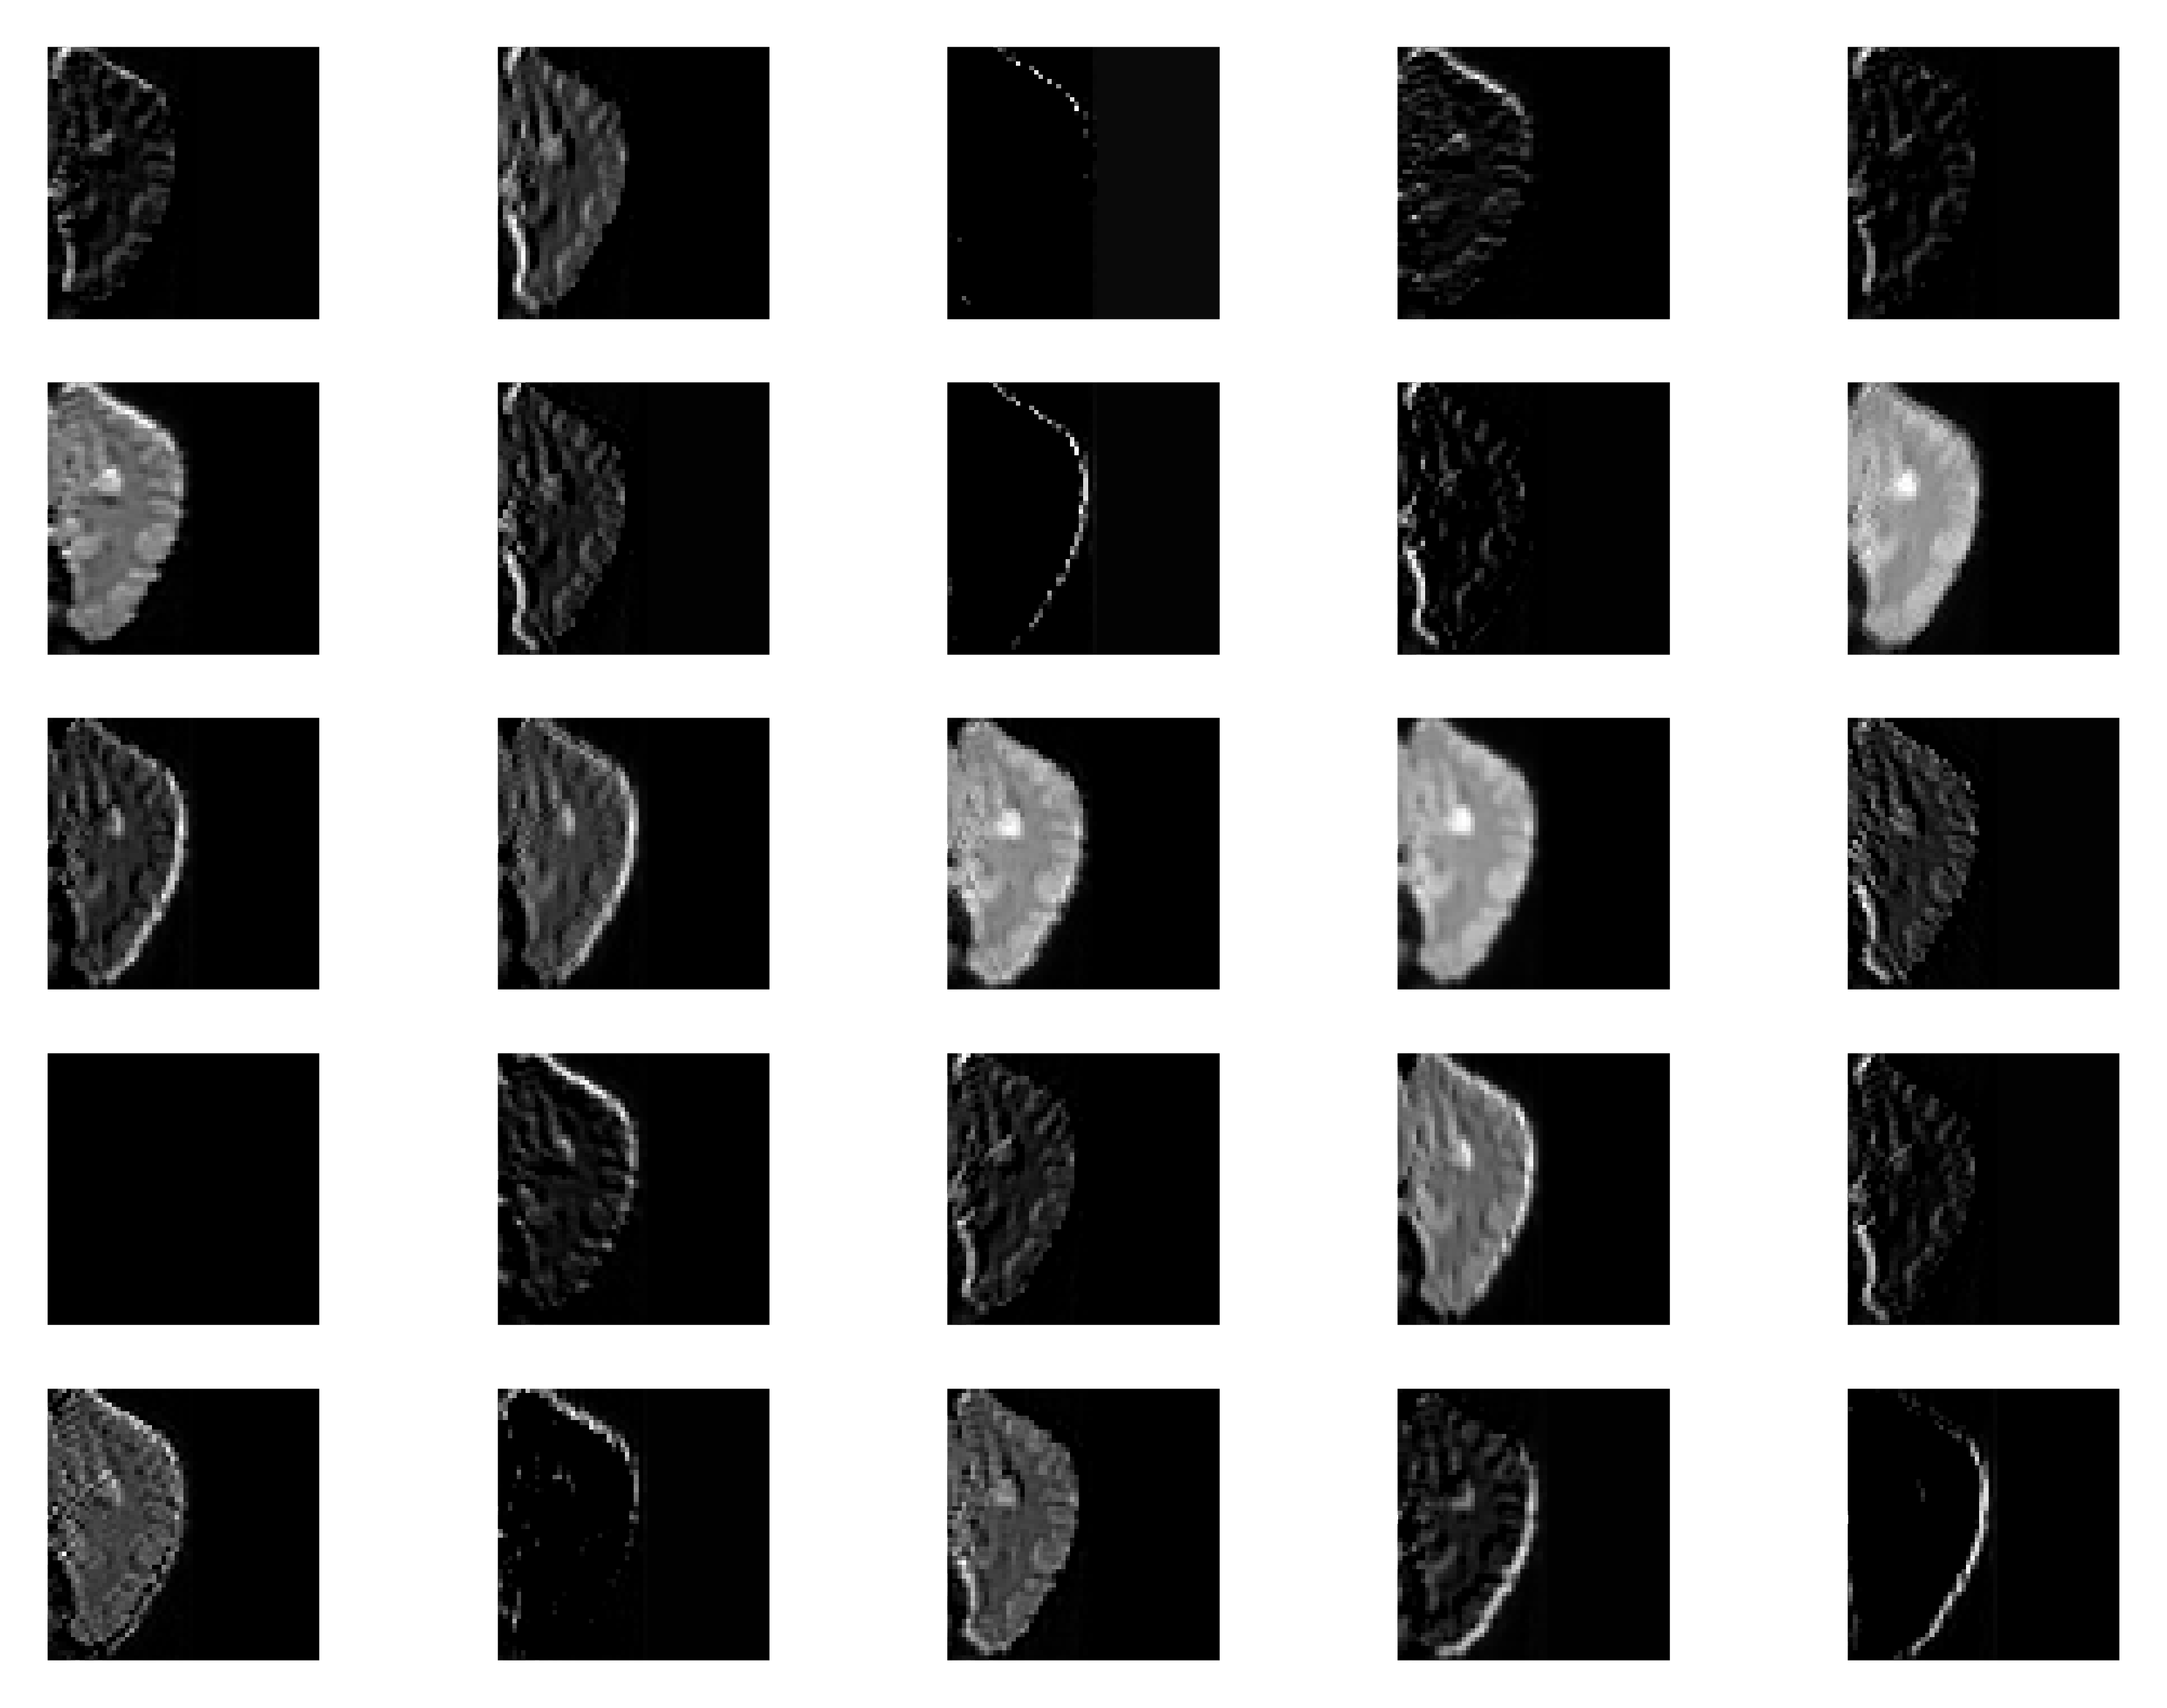

In [66]:
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()
# load the image
image = full_data[5200]
# expand dimensions so that it represents a single 'sample'
image = np.expand_dims(image, axis=0)
# get feature map for first hidden layer
feature_maps = model.predict(image)
# plot all 64 maps in an 8x8 squares
#square = 8
#r, c=10, r=8
#r, c = 8, 4
r, c = 5, 5
ix = 1

for _ in range(r):
  for _ in range(c):
  # specify subplot and turn of axis
    #ax = pyplot.subplot(square, square, ix)
    ax = pyplot.subplot(r, c, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
    ix += 1
# show the figure
pyplot.show()

**Similarly, visualizing 25 feature maps from the Second convolutional layer of our model**

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 160)       46240     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 160)      0         
 2D)                                                             
                                                                 
Total params: 47,136
Trainable params: 47,136
Non-trainable

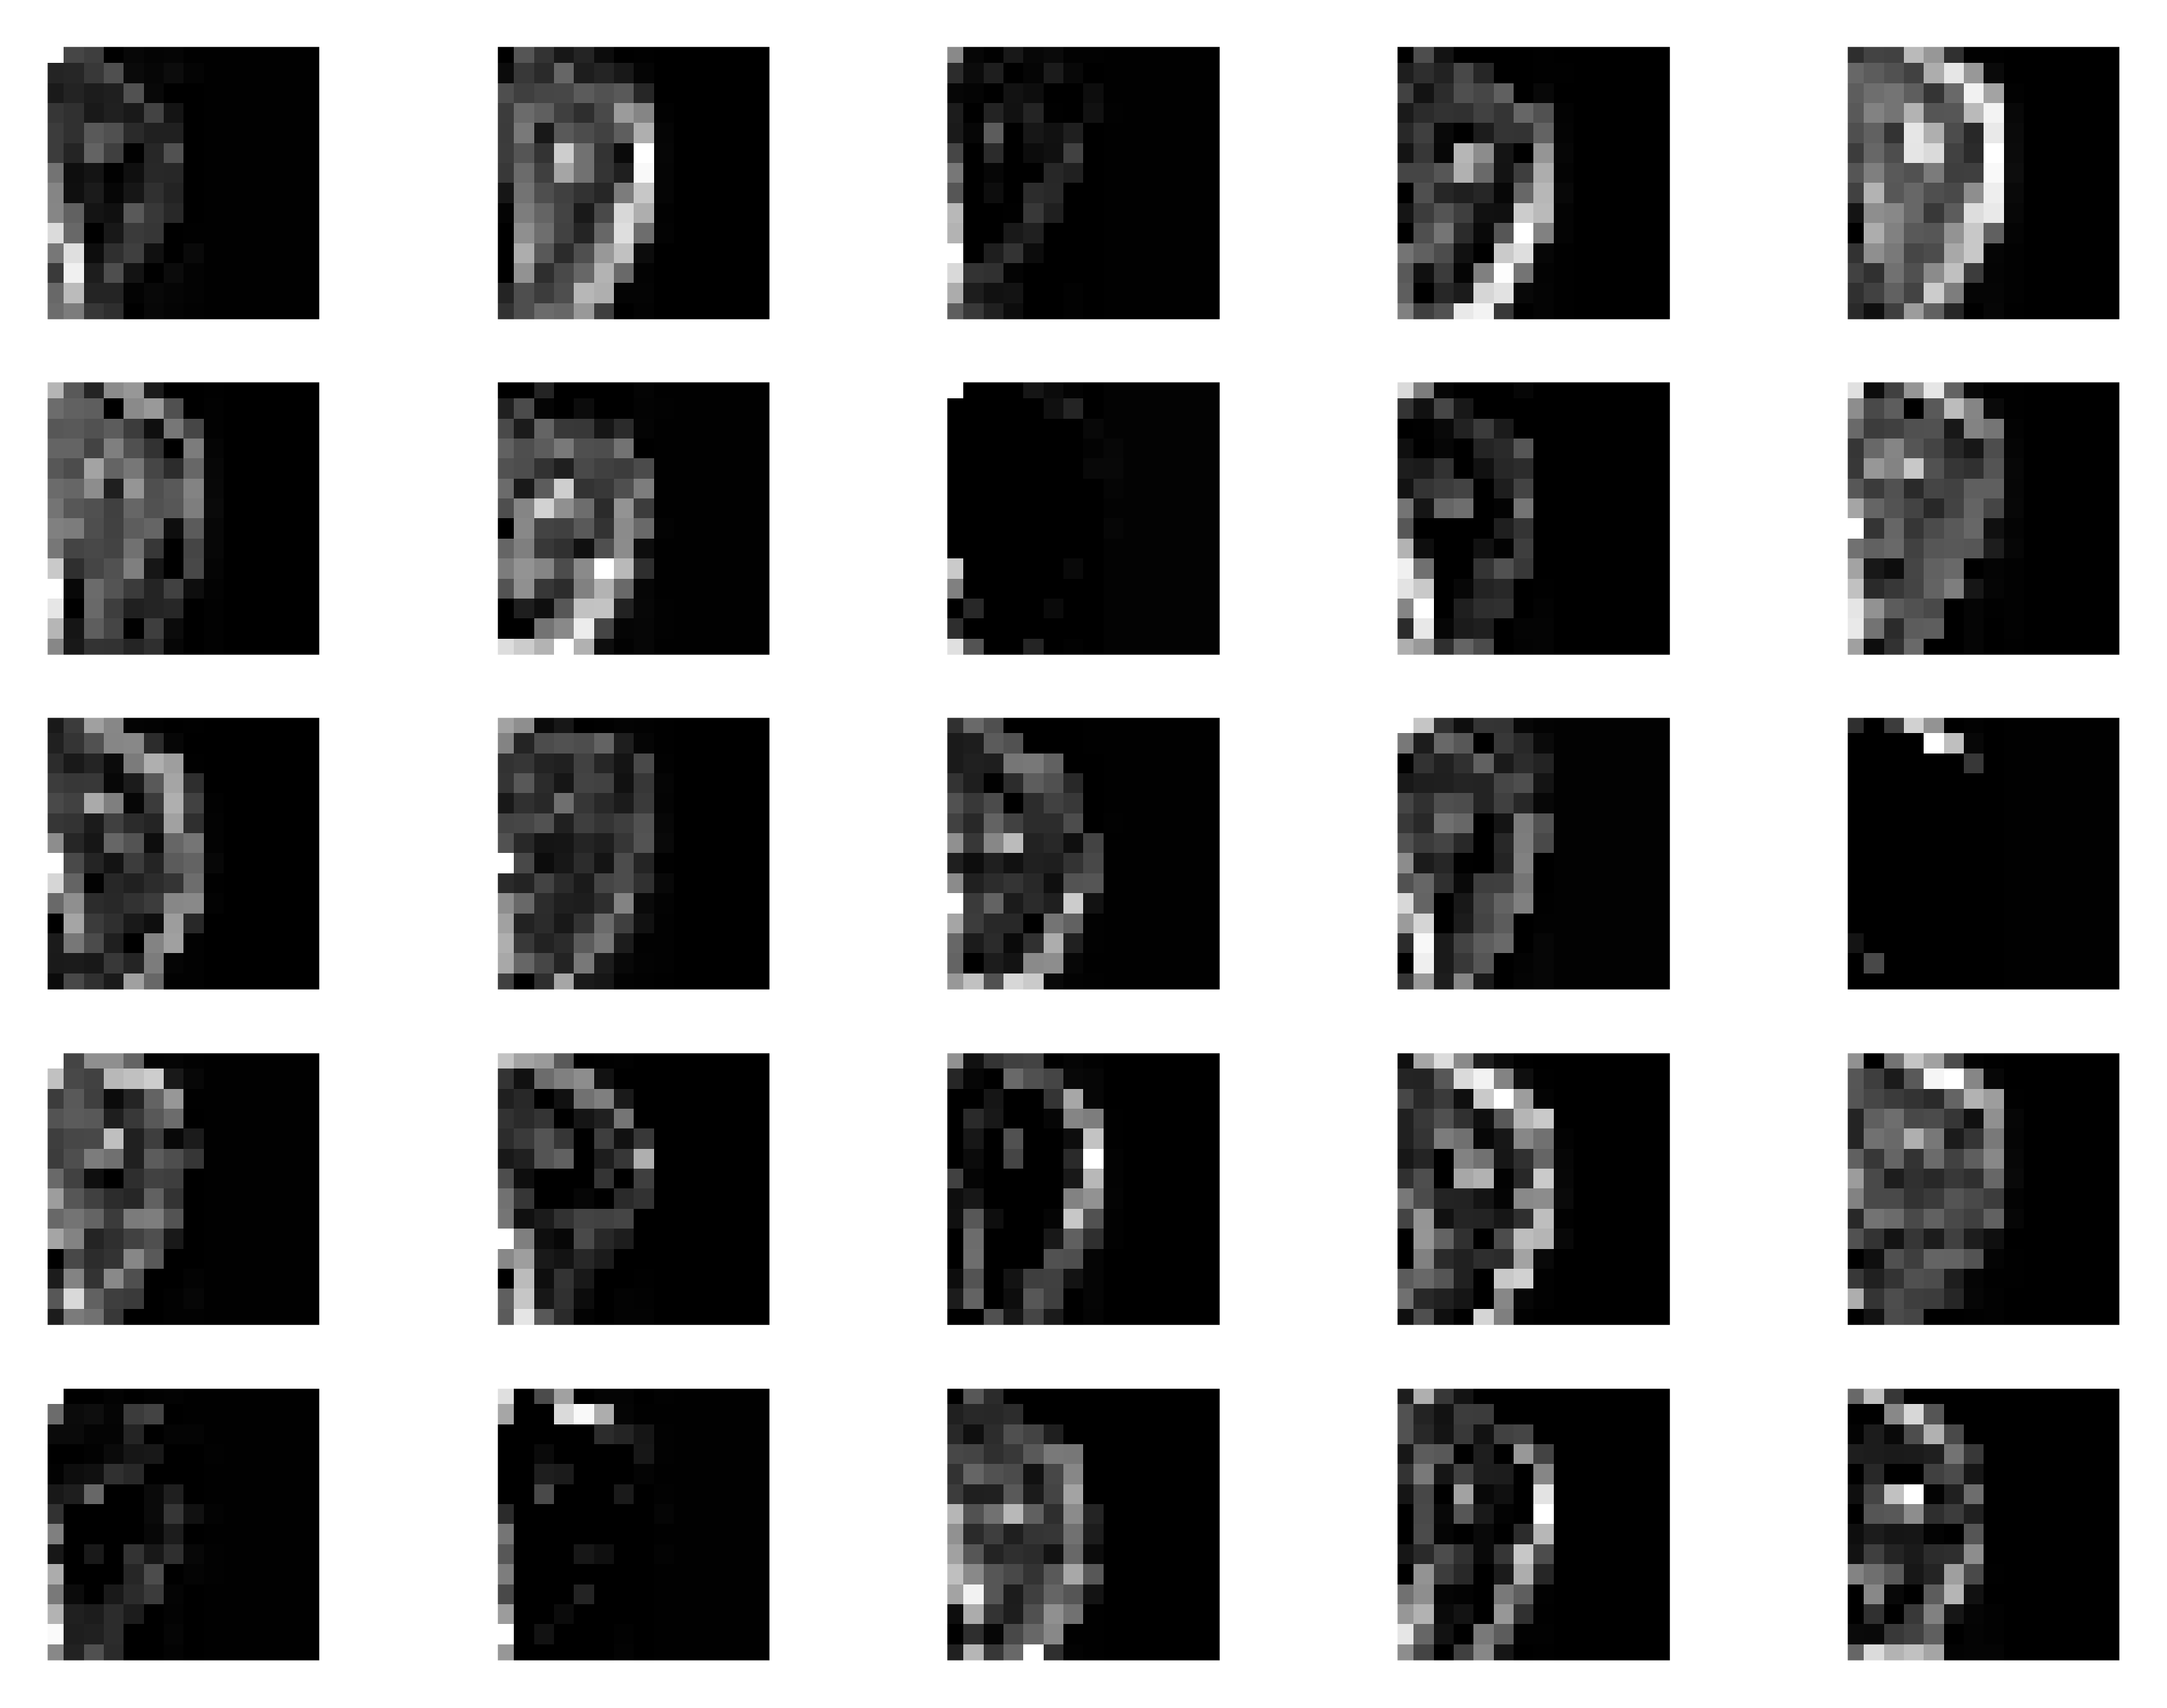

In [67]:
#First Load the Model
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Vit_GradCam/CNN_Bayesian2')
model = Model(inputs=model.inputs, outputs=model.layers[3].output)
model.summary()
# load the image
image = full_data[5200]
# expand dimensions so that it represents a single 'sample'
image = np.expand_dims(image, axis=0)
# get feature map for first hidden layer
feature_maps = model.predict(image)
# plot all 64 maps in an 8x8 squares
#square = 8
#r, c = 16, 12
#r, c = 16, 10
r, c = 5, 5
ix = 1

for _ in range(r):
  for _ in range(c):
  # specify subplot and turn of axis
    #ax = pyplot.subplot(square, square, ix)
    ax = pyplot.subplot(r, c, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
    ix += 1
# show the figure
pyplot.show()

**Visualizeing 25 feature map from the third convolutional layer of our model**

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 160)       46240     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 160)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 192)       2766

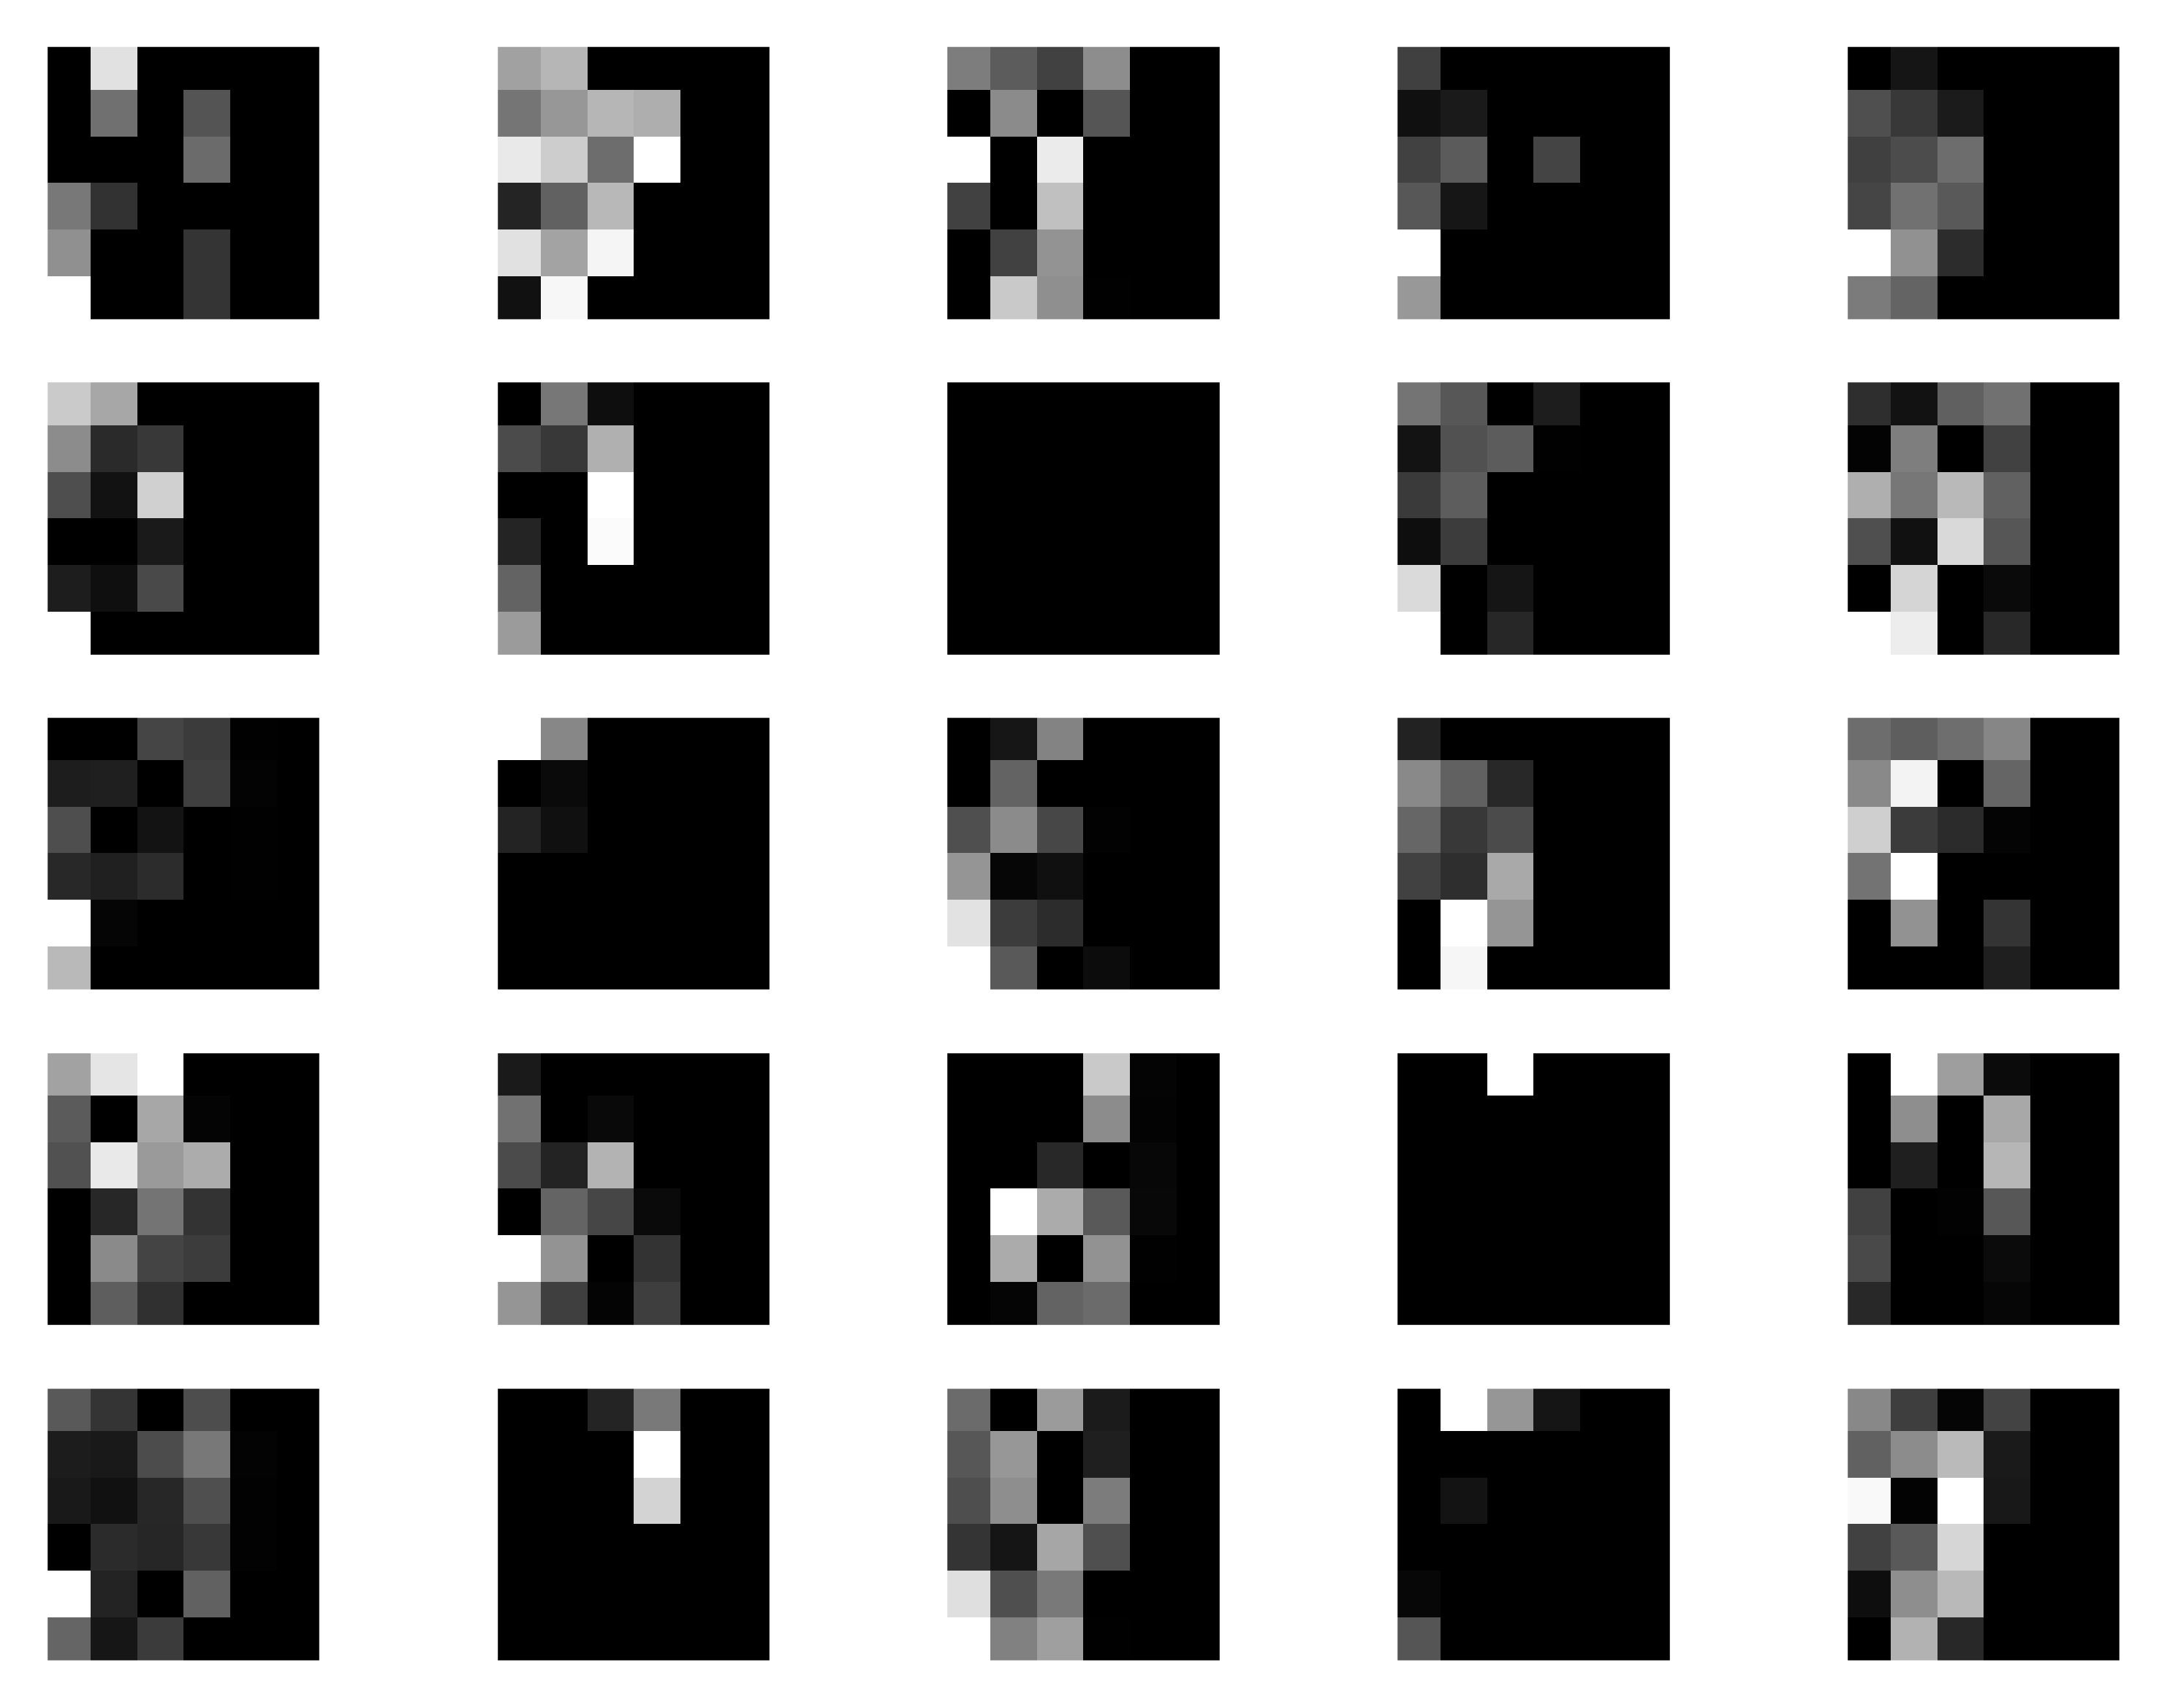

In [68]:
#First Load the Model
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Vit_GradCam/CNN_Bayesian2')
model = Model(inputs=model.inputs, outputs=model.layers[5].output)
model.summary()
# load the image
image = full_data[5200]
# expand dimensions so that it represents a single 'sample'
image = np.expand_dims(image, axis=0)
# get feature map for first hidden layer
feature_maps = model.predict(image)
# plot all 64 maps in an 8x8 squares
#square = 8
#r, c = 16, 8
#r, c = 16, 12
r, c = 5, 5
ix = 1

for _ in range(r):
  for _ in range(c):
  # specify subplot and turn of axis
    #ax = pyplot.subplot(square, square, ix)
    ax = pyplot.subplot(r, c, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
    ix += 1
# show the figure
pyplot.show()

**Visualizing 25 feature maps from each of the three convolutional layers, all at once**

1/1 [==============================] - 0s 56ms/step


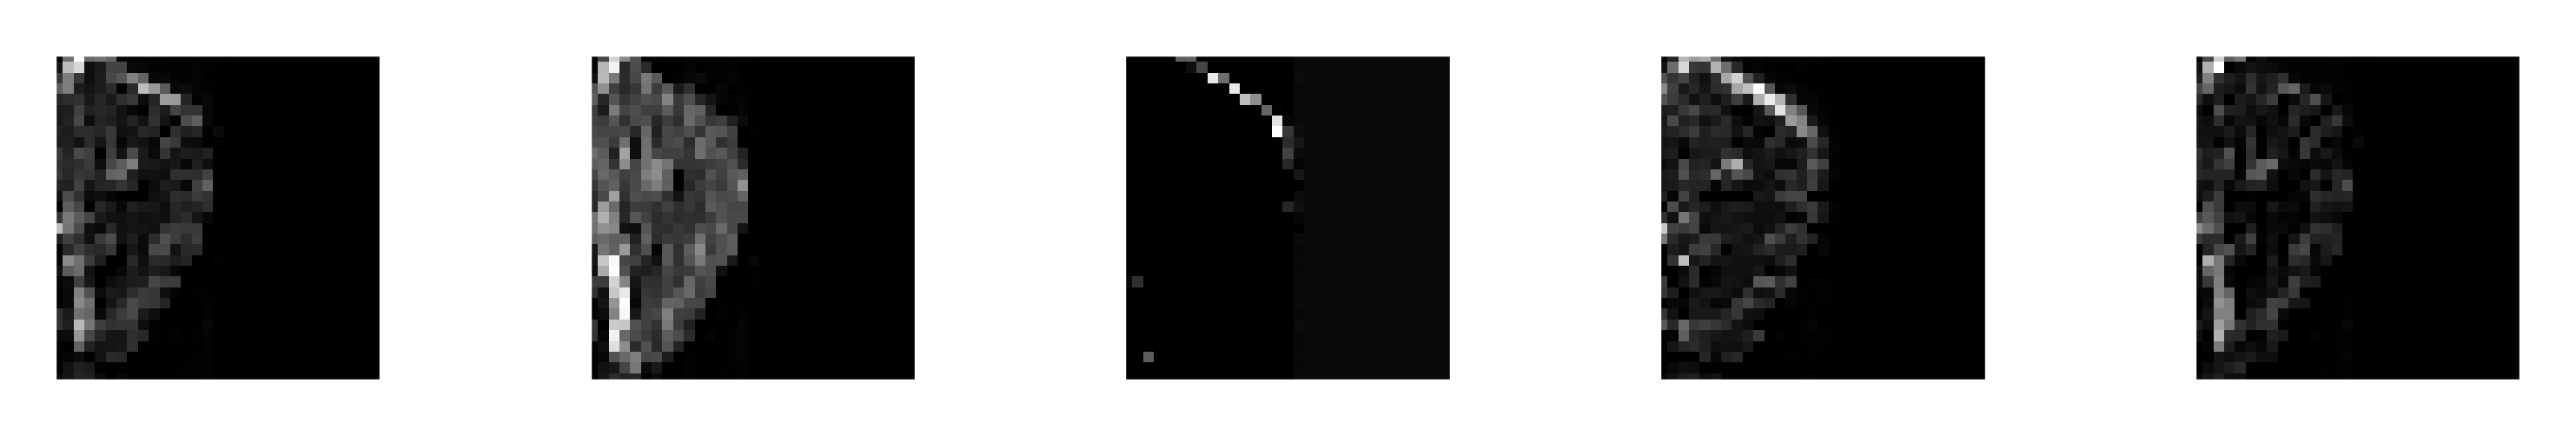

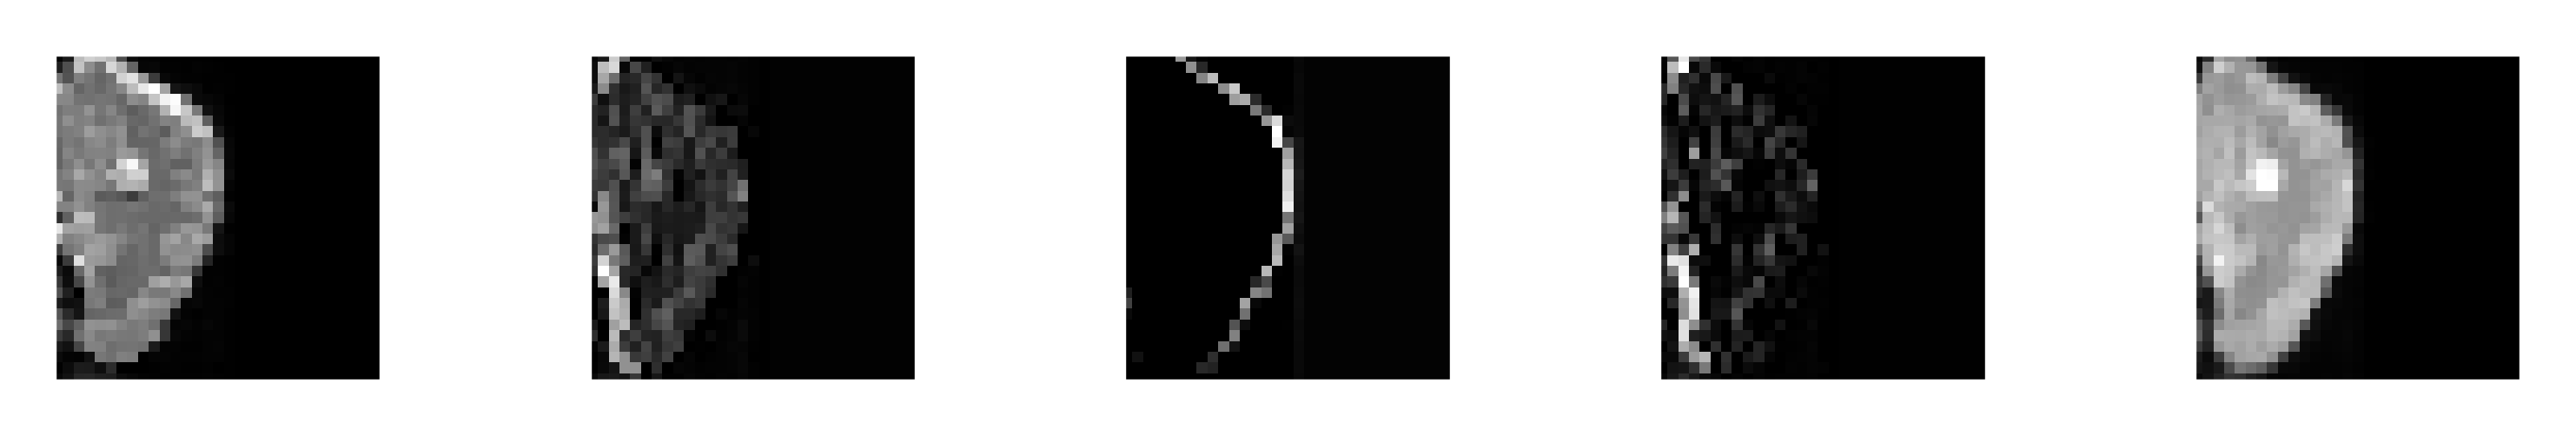

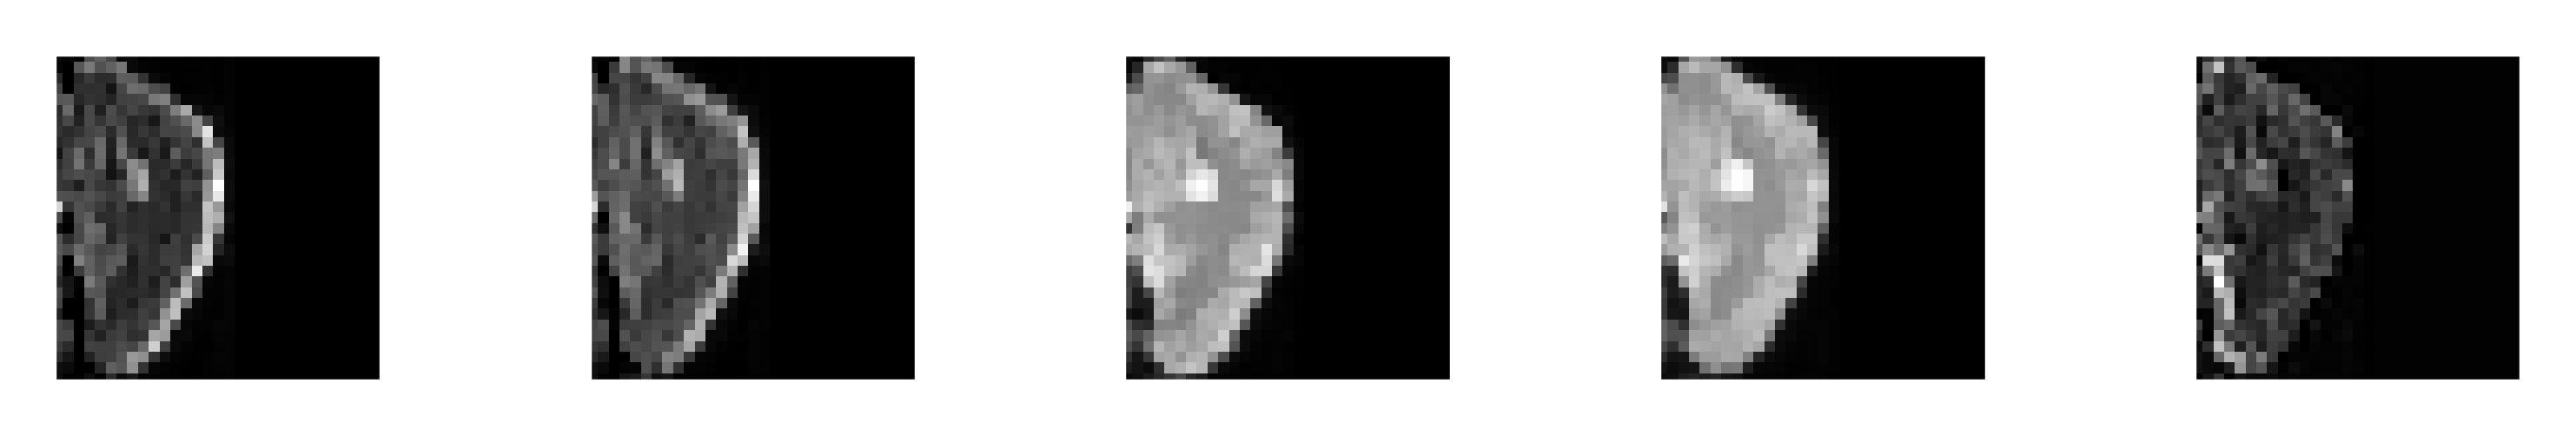

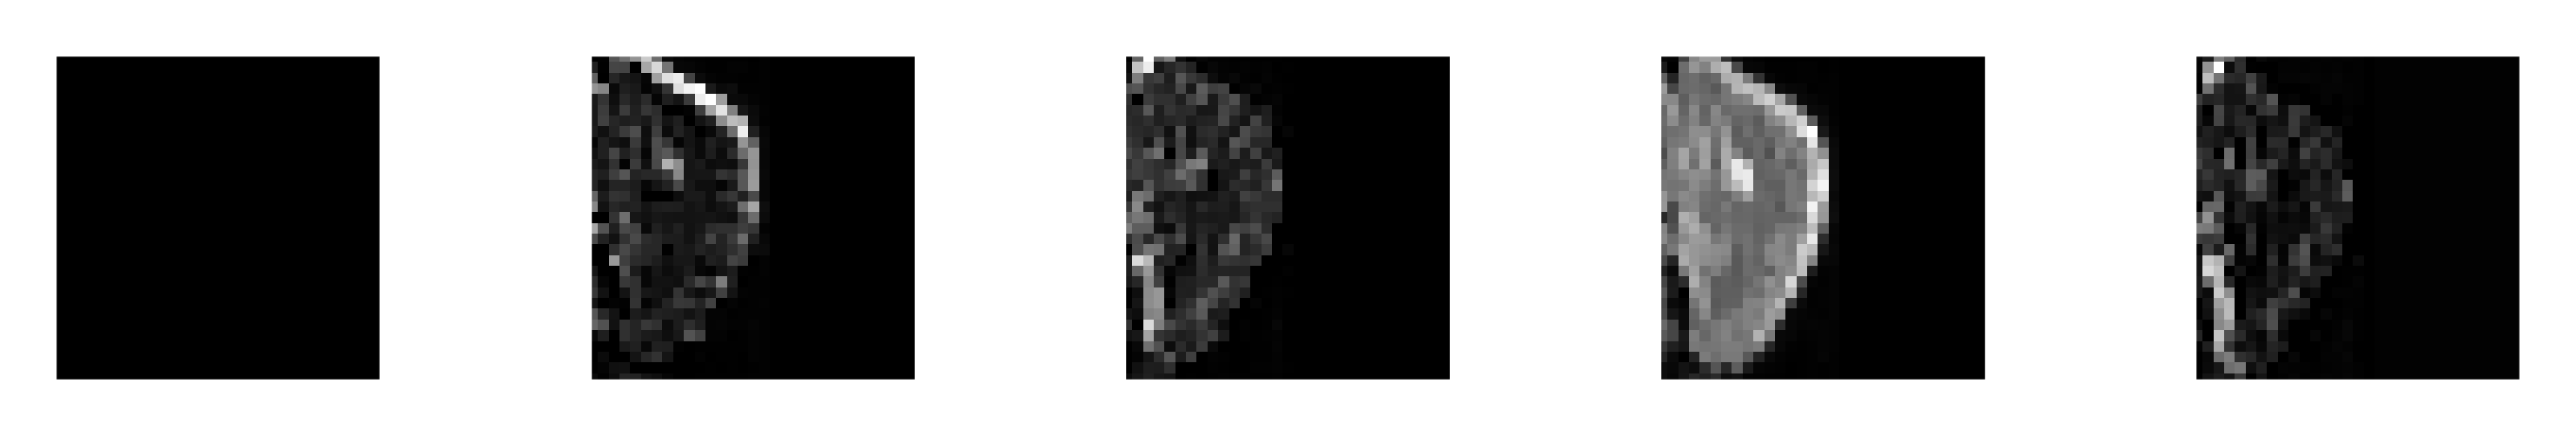

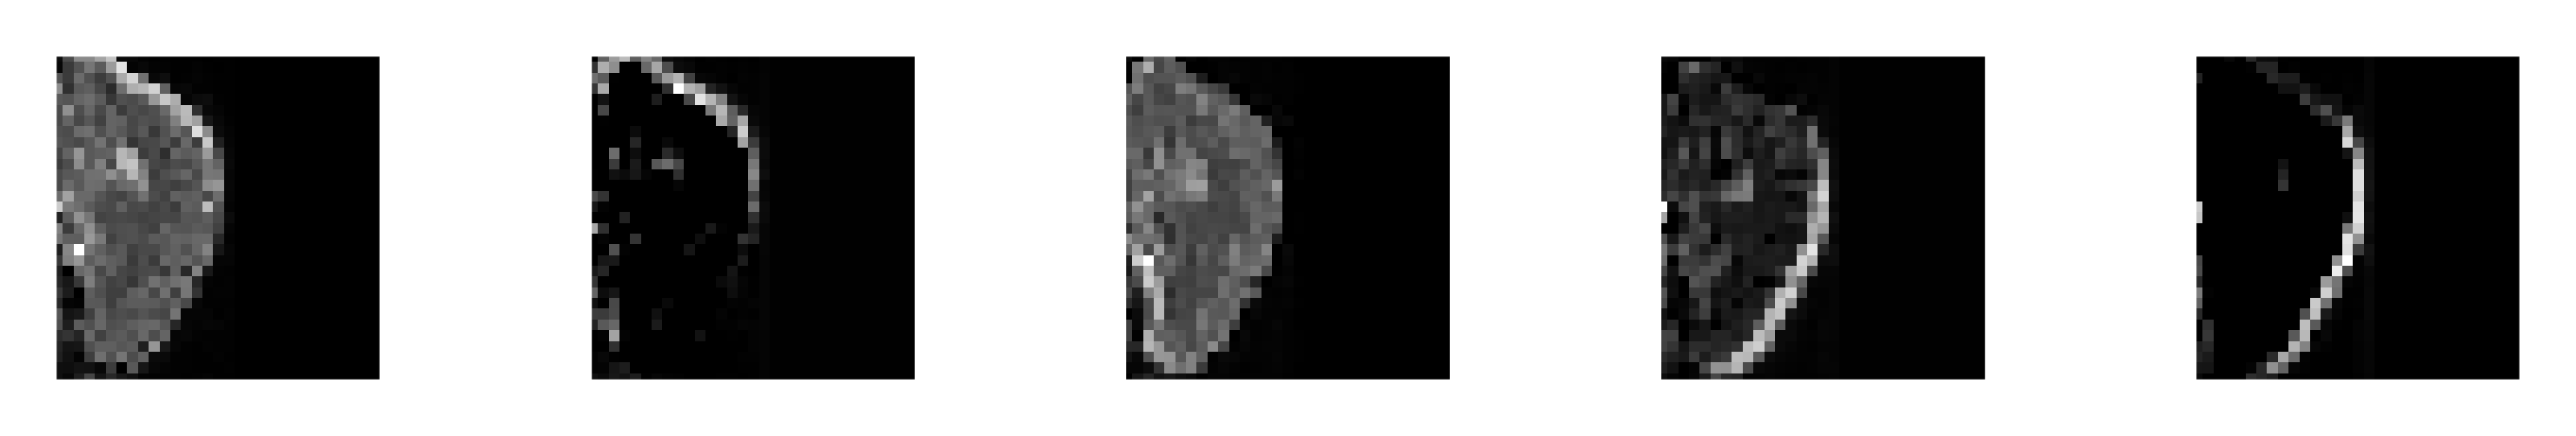

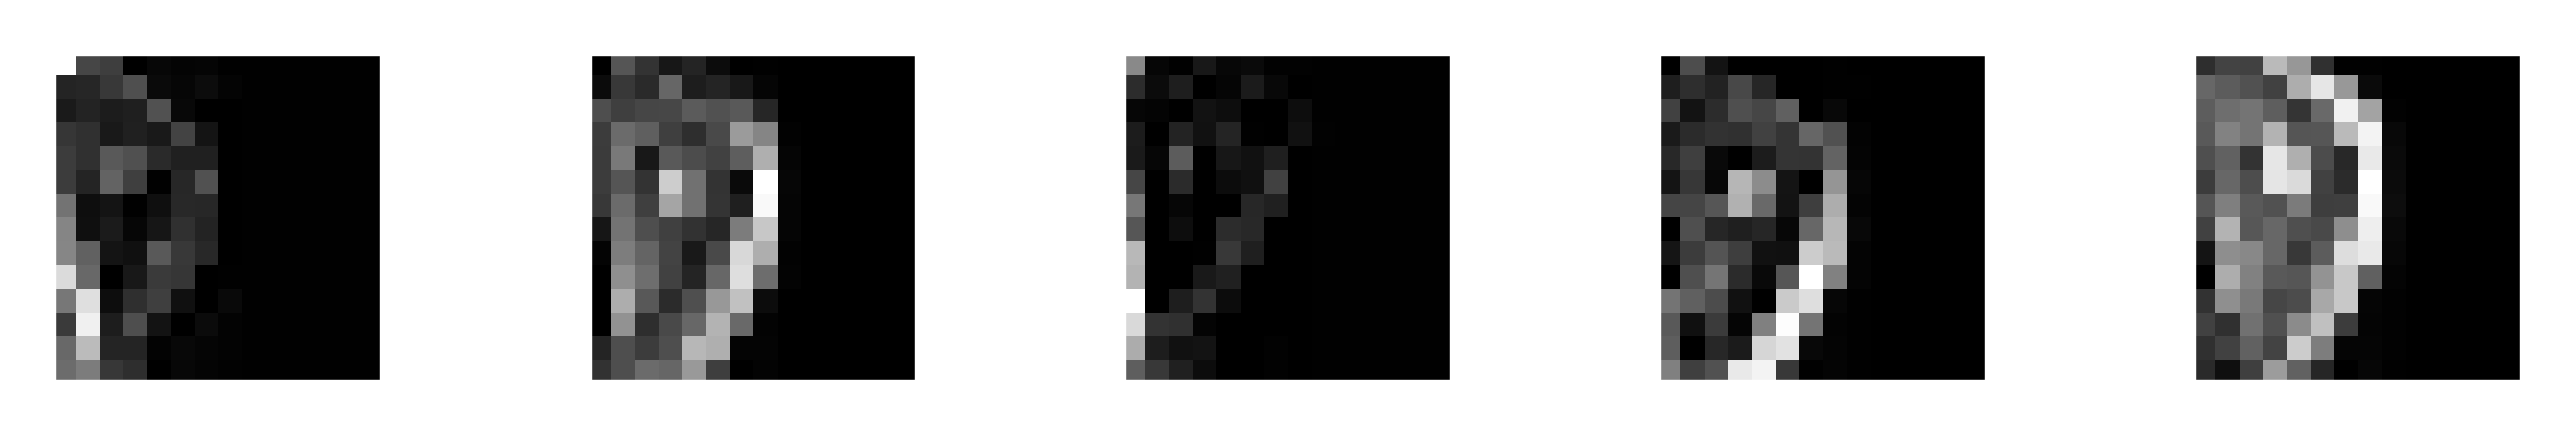

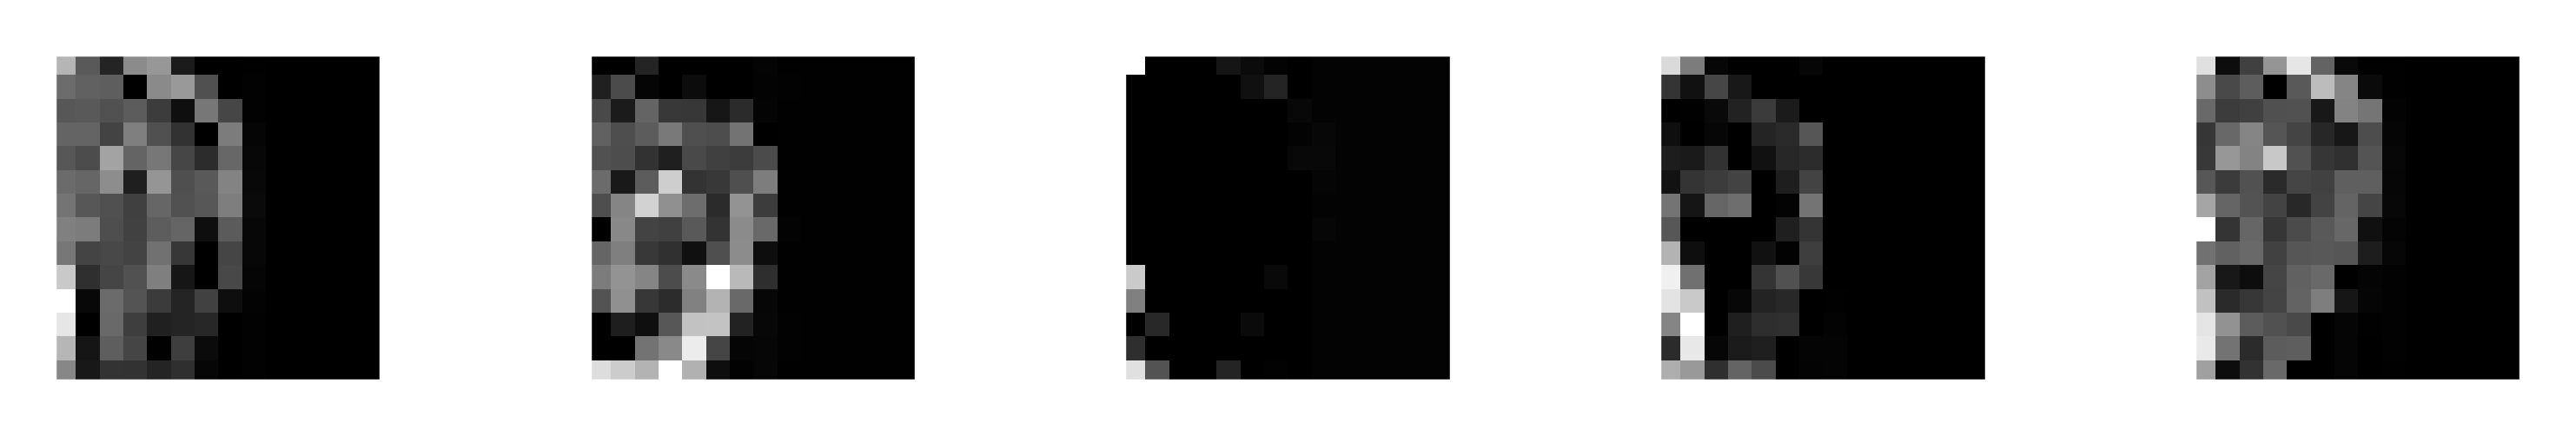

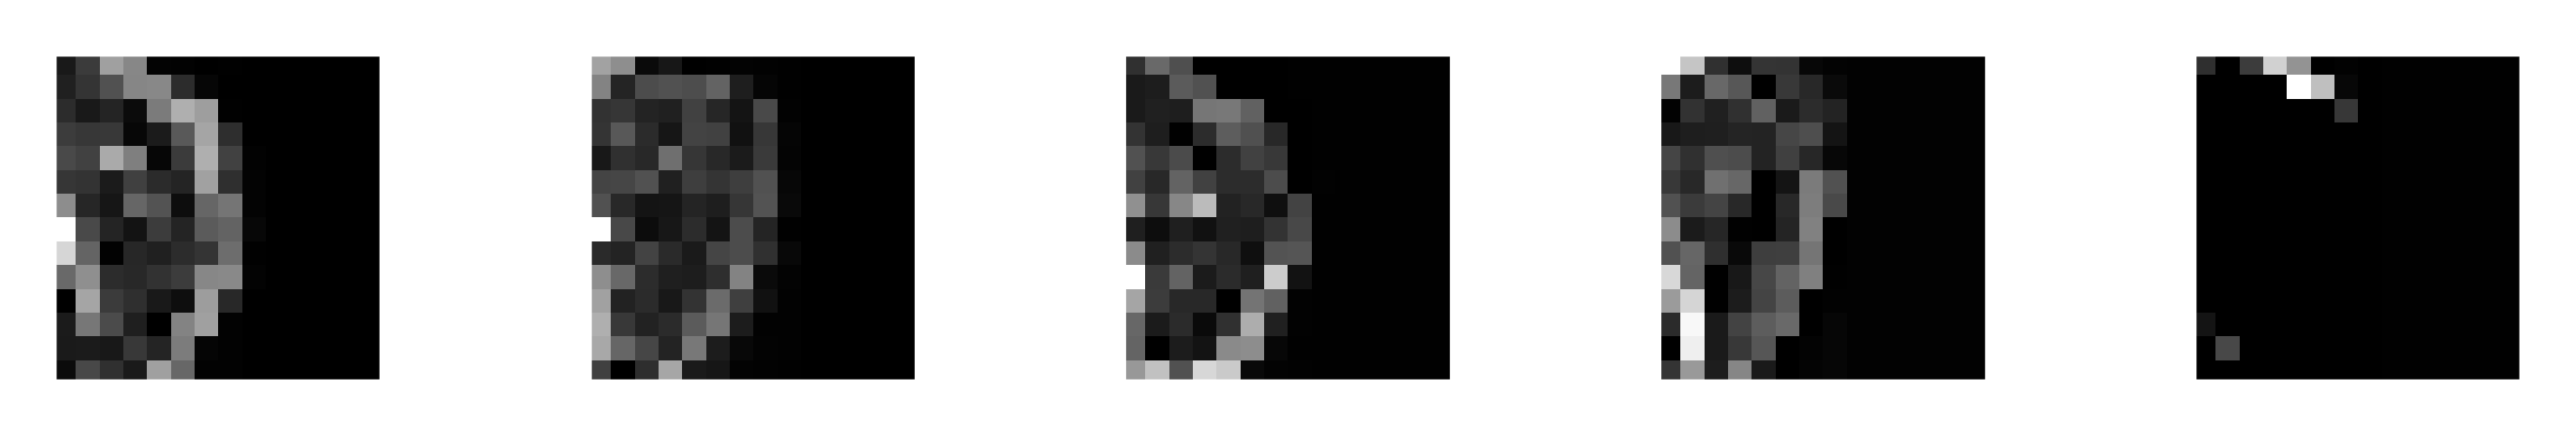

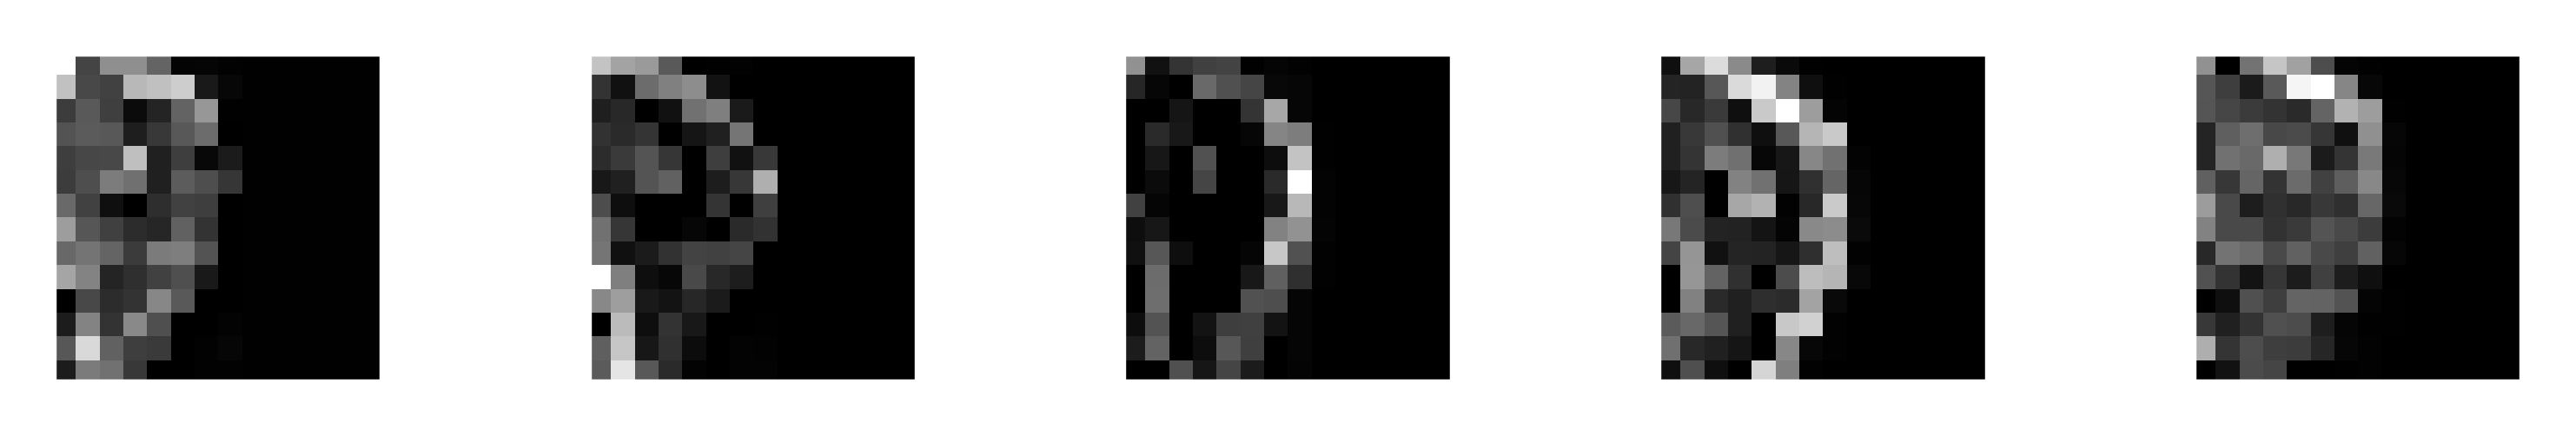

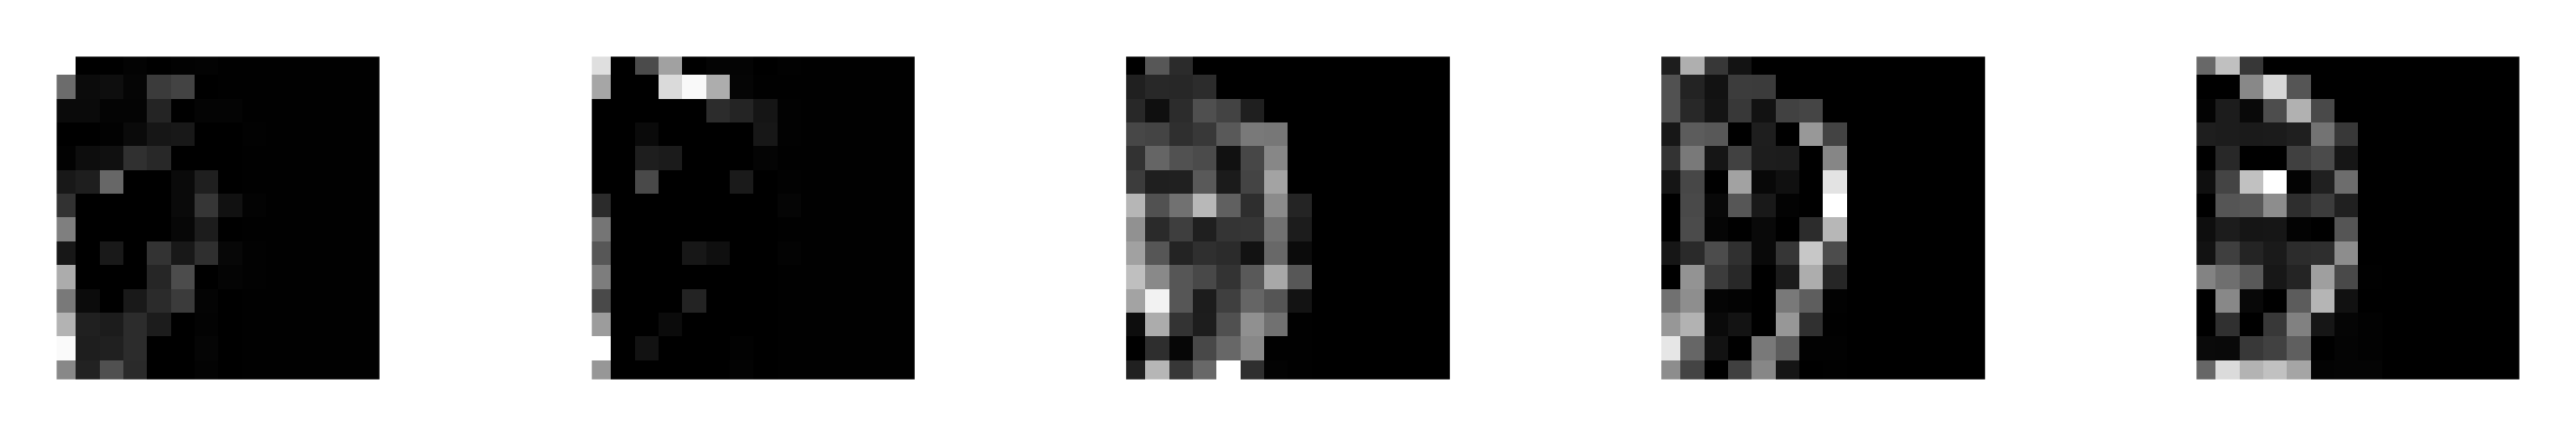

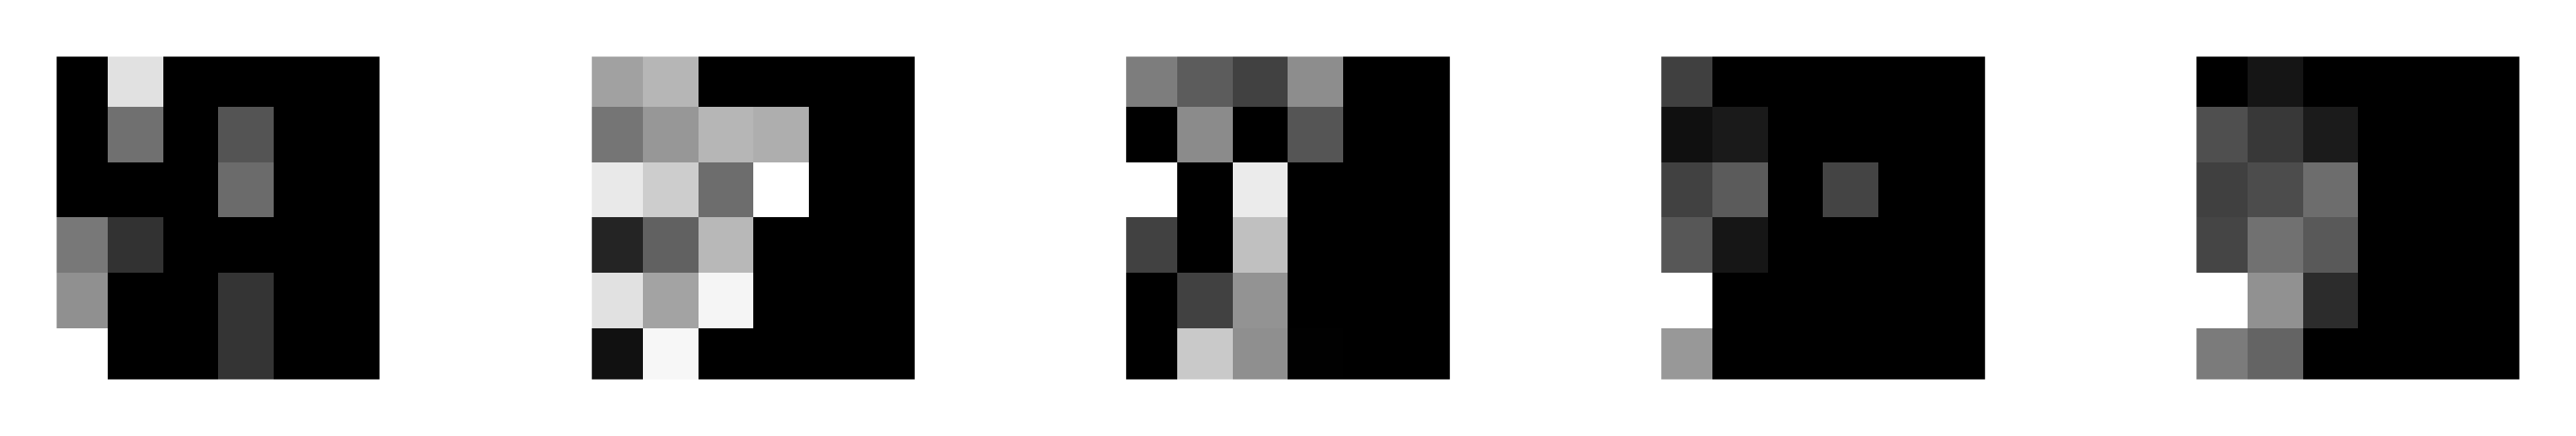

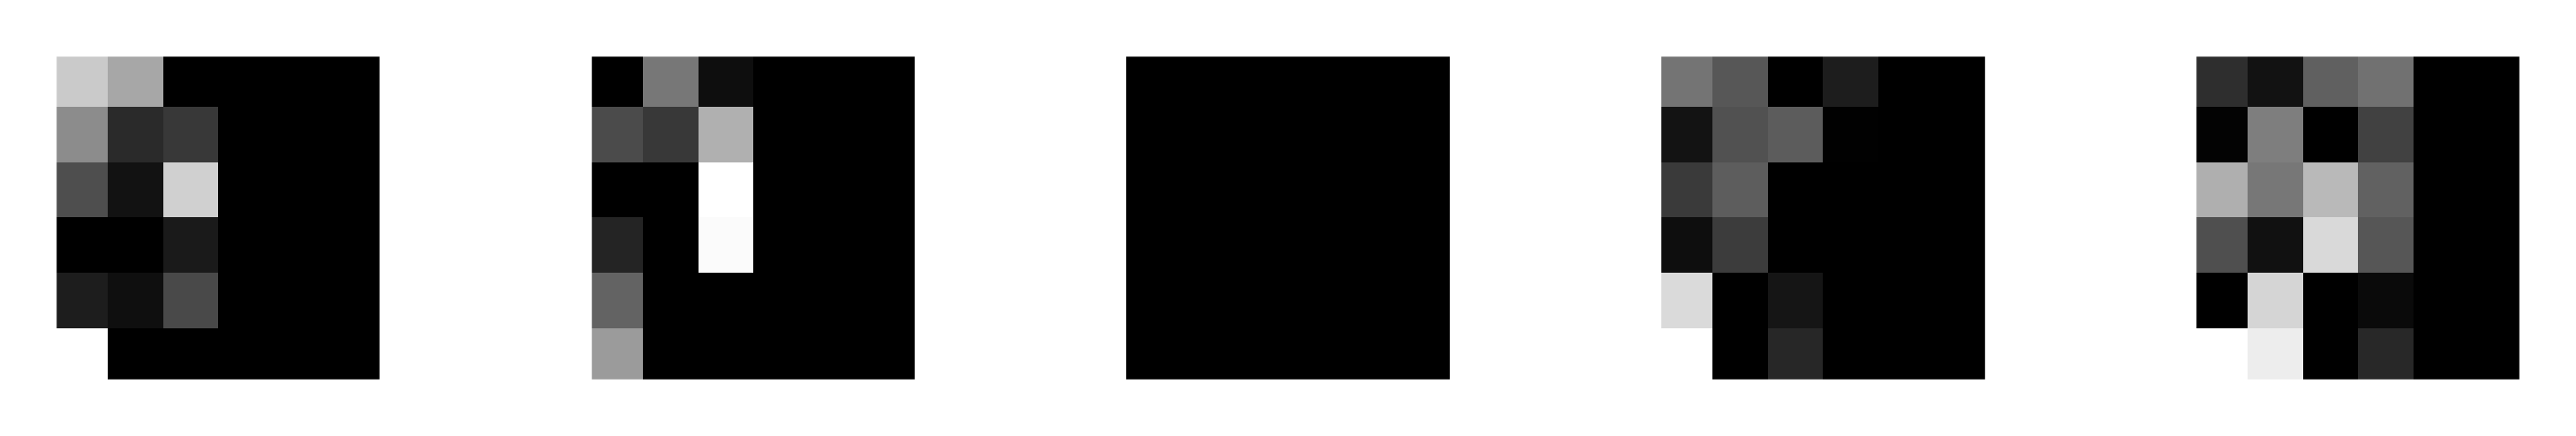

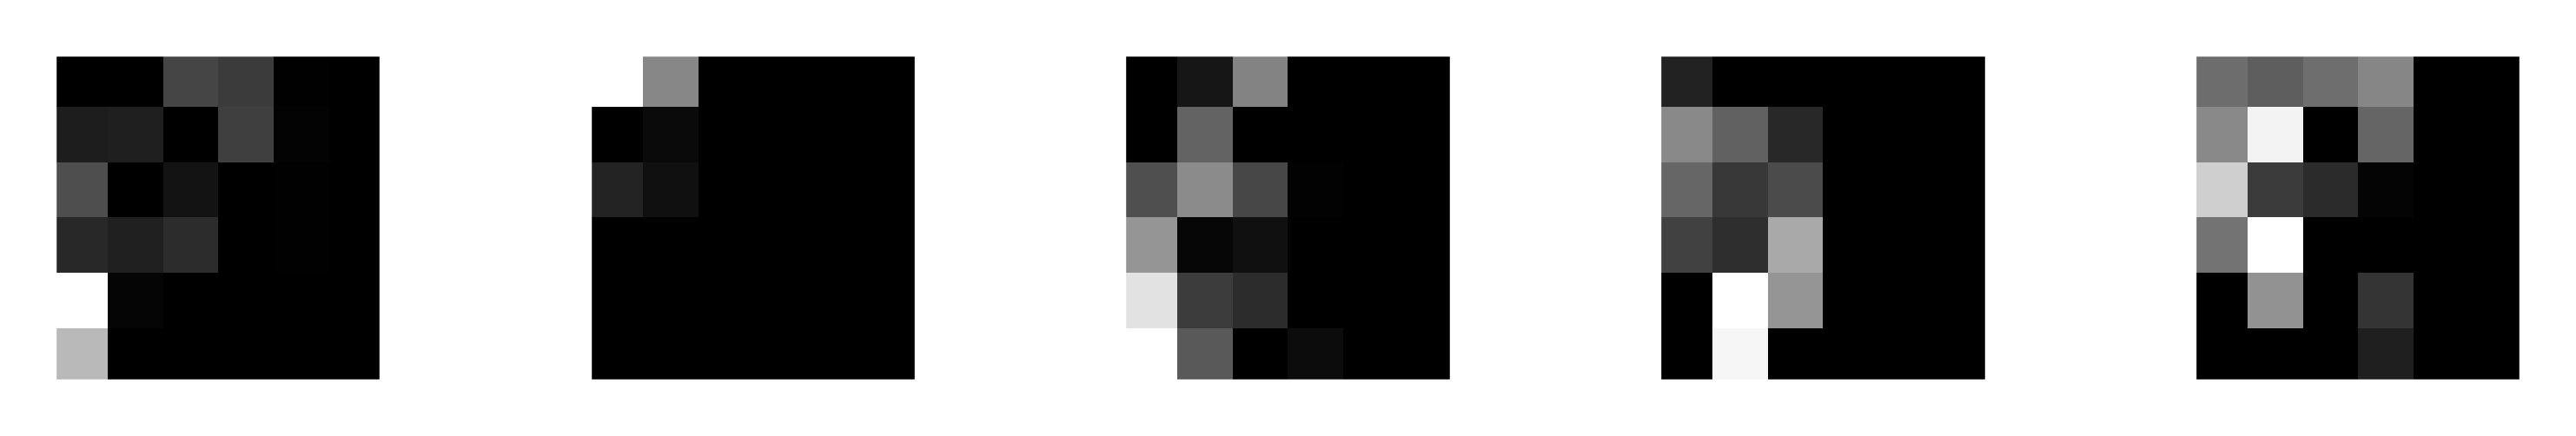

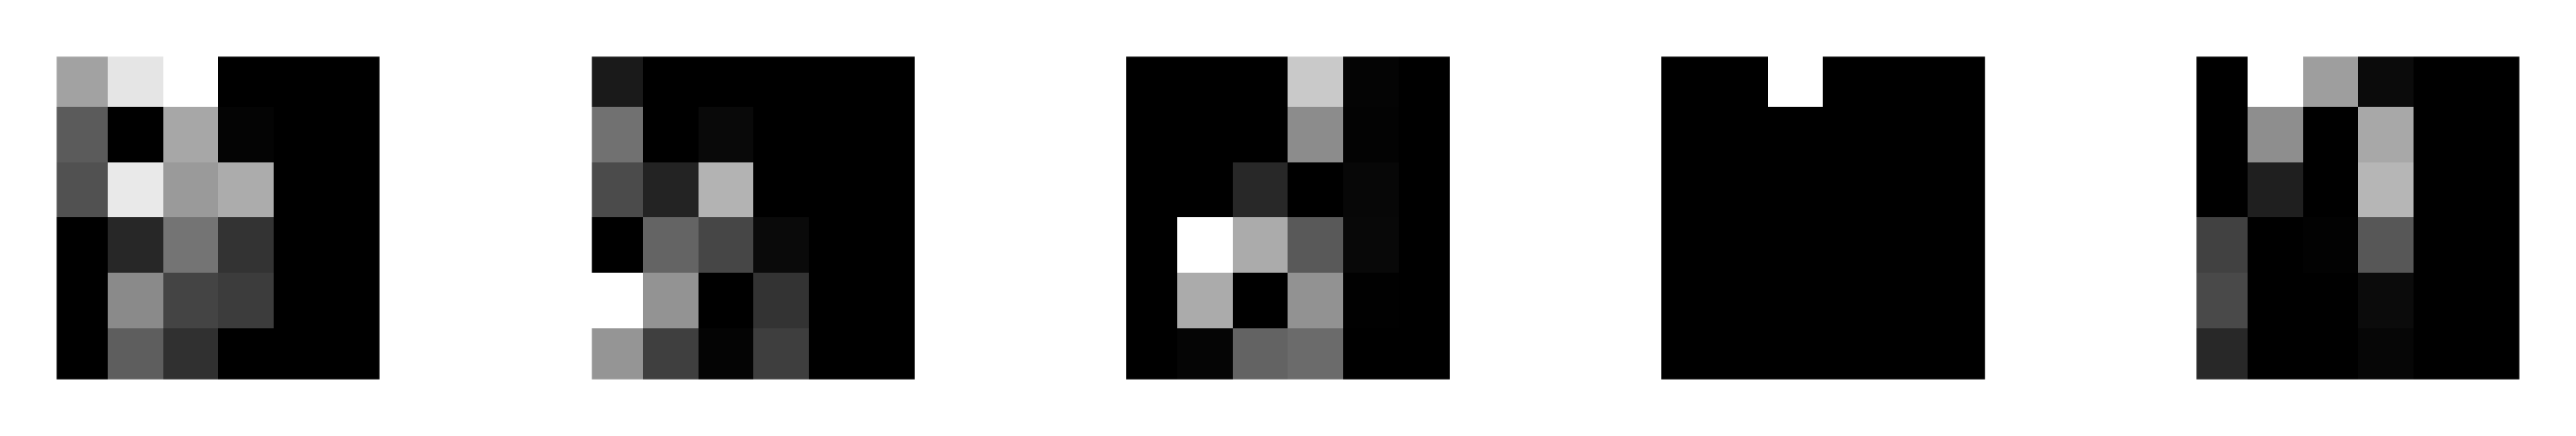

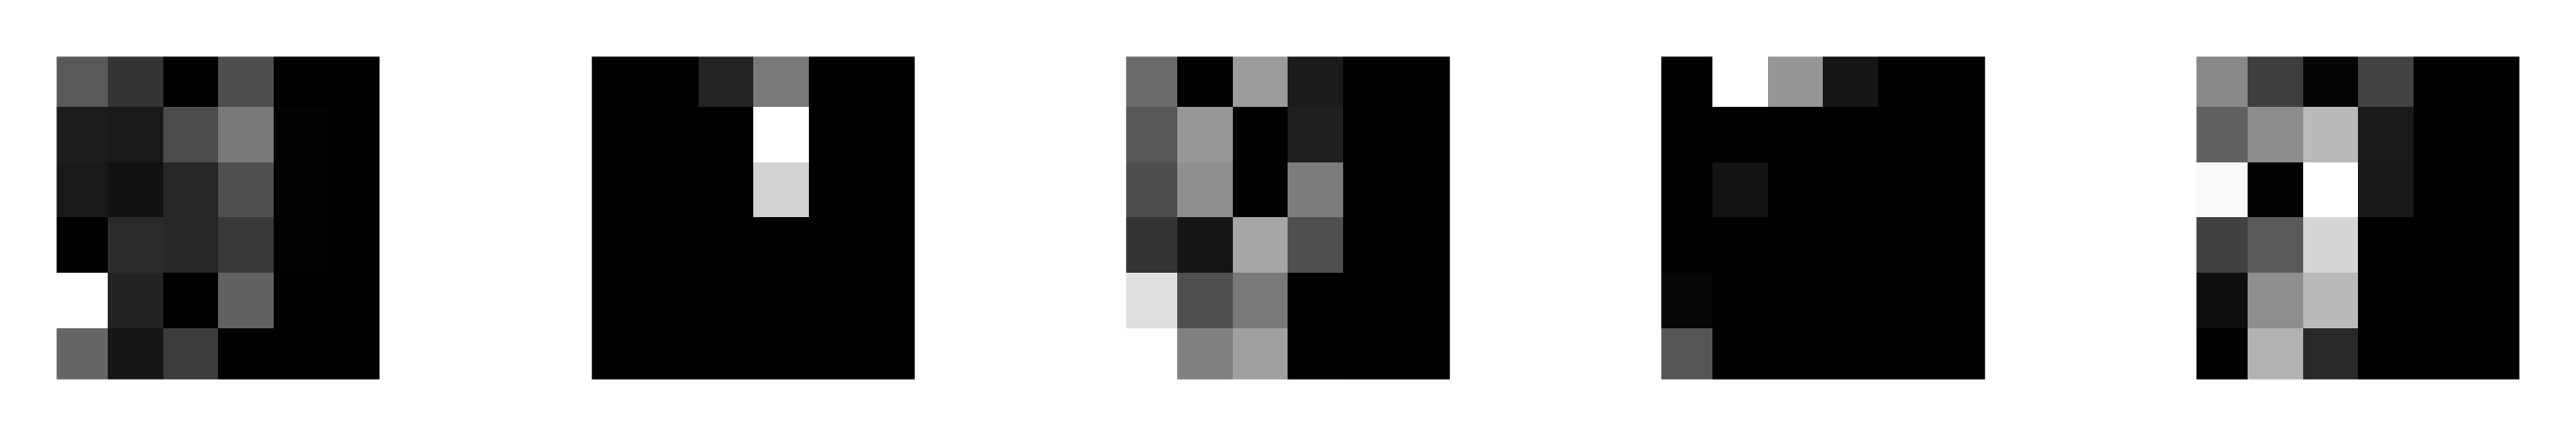

In [70]:
#First Load the Model
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Vit_GradCam/CNN_Bayesian2')
# redefine model to output right after the first convolutional layer
ixs = [1, 3, 5]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
# load the image
image = full_data[5200]
# expand dimensions so that it represents a single 'sample'
image = np.expand_dims(image, axis=0)
# get feature map for first hidden layer
feature_maps = model.predict(image)
# plot all 64 maps in an 8x8 squares
square = 5

for fmap in feature_maps:
  # plot all 64 maps in an 8x8 squares
  ix = 1
  for _ in range(square):
    for _ in range(square):
      # specify subplot and turn of axis
      ax = pyplot.subplot(square, square, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      # plot filter channel in grayscale
      pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
      ix += 1
    # show the figure
    pyplot.show()